In [1]:
import torch
import numpy as np
import os
from torch import nn
import sys
import polars as pl
import sklearn
import shap
from functools import partial
import pandas as pd
import random
from matplotlib import pyplot as plt
import time
from rdkit.Chem import DataStructs
from tqdm import tqdm
from joblib import Parallel, delayed
import math
from skfp import fingerprints as skfps


sys.path.append('../')

In [2]:
PROTEINS = ['BRD4', 'HSA', 'sEH']

In [3]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
# import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names as _continuous_distn_names
from scipy.stats._discrete_distns import _distn_names as _discrete_distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
_all_distn_names = [n for n in _continuous_distn_names + _discrete_distn_names if n not in ['levy_stable', 'studentized_range']]

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _all_distn_names][:]):
#     for ii, distribution in enumerate(['gamma']):
        print("{:>3} / {:<3}: {}".format( ii+1, len(_all_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.001, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def fit_dist(data, bins = 500):
    # Plot for comparison
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots()
    plt.hist(data, bins=bins, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distributions = best_fit_distribution(data, bins, ax)
    best_dist = best_distributions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title('Best fit distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    plt.hist(data, bins=bins, density=True, alpha=0.5, label='Data')

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title('Best fit distribution \n' + dist_str)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    plt.show()
    return best_distributions, best_dist

In [4]:
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv').select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
    ).collect()
print(train_df.estimated_size('gb'), 'GB')
train_df

7.6670590518042445 GB


molecule,bb1,bb2,bb3,BRD4,HSA,sEH
str,u16,u16,u16,u8,u8,u8
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0
…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0


In [6]:
bb1_df = train_df.group_by('bb1').agg(pl.col('BRD4').mean(), pl.col('HSA').mean(), pl.col('sEH').mean()).sort('bb1')
bb1_df

bb1,BRD4,HSA,sEH
u16,f64,f64,f64
7,0.000055,0.000099,0.000003
14,0.01517,0.007672,0.006345
21,0.000072,0.001517,0.001145
36,0.000179,0.00044,0.000058
51,0.001432,0.004146,0.001355
…,…,…,…
2058,0.006873,0.001821,0.00162
2059,0.010803,0.00389,0.002753
2061,0.000747,0.001648,0.000557


In [7]:
bb2_df = train_df.group_by('bb2').agg(pl.col('BRD4').mean(), pl.col('HSA').mean(), pl.col('sEH').mean()).sort('bb2')
bb2_df

bb2,BRD4,HSA,sEH
u16,f64,f64,f64
0,0.000069,0.000665,0.001961
5,0.000714,0.002087,0.003663
15,0.00092,0.001792,0.007932
16,0.002342,0.004431,0.007406
17,0.005468,0.004079,0.00926
…,…,…,…
2093,0.00454,0.003209,0.008866
2097,0.000977,0.001009,0.00588
2101,0.086355,0.006605,0.004004


In [8]:
bb3_df = train_df.group_by('bb3').agg(pl.col('BRD4').mean(), pl.col('HSA').mean(), pl.col('sEH').mean()).sort('bb3')
bb3_df

bb3,BRD4,HSA,sEH
u16,f64,f64,f64
0,0.000222,0.000433,0.002389
3,0.002277,0.002315,0.004153
5,0.000235,0.000204,0.002404
6,0.007129,0.01271,0.008833
9,0.002915,0.006144,0.006187
…,…,…,…
2101,0.060522,0.004729,0.004694
2104,0.000781,0.00232,0.004323
2105,0.002515,0.000934,0.001543


array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

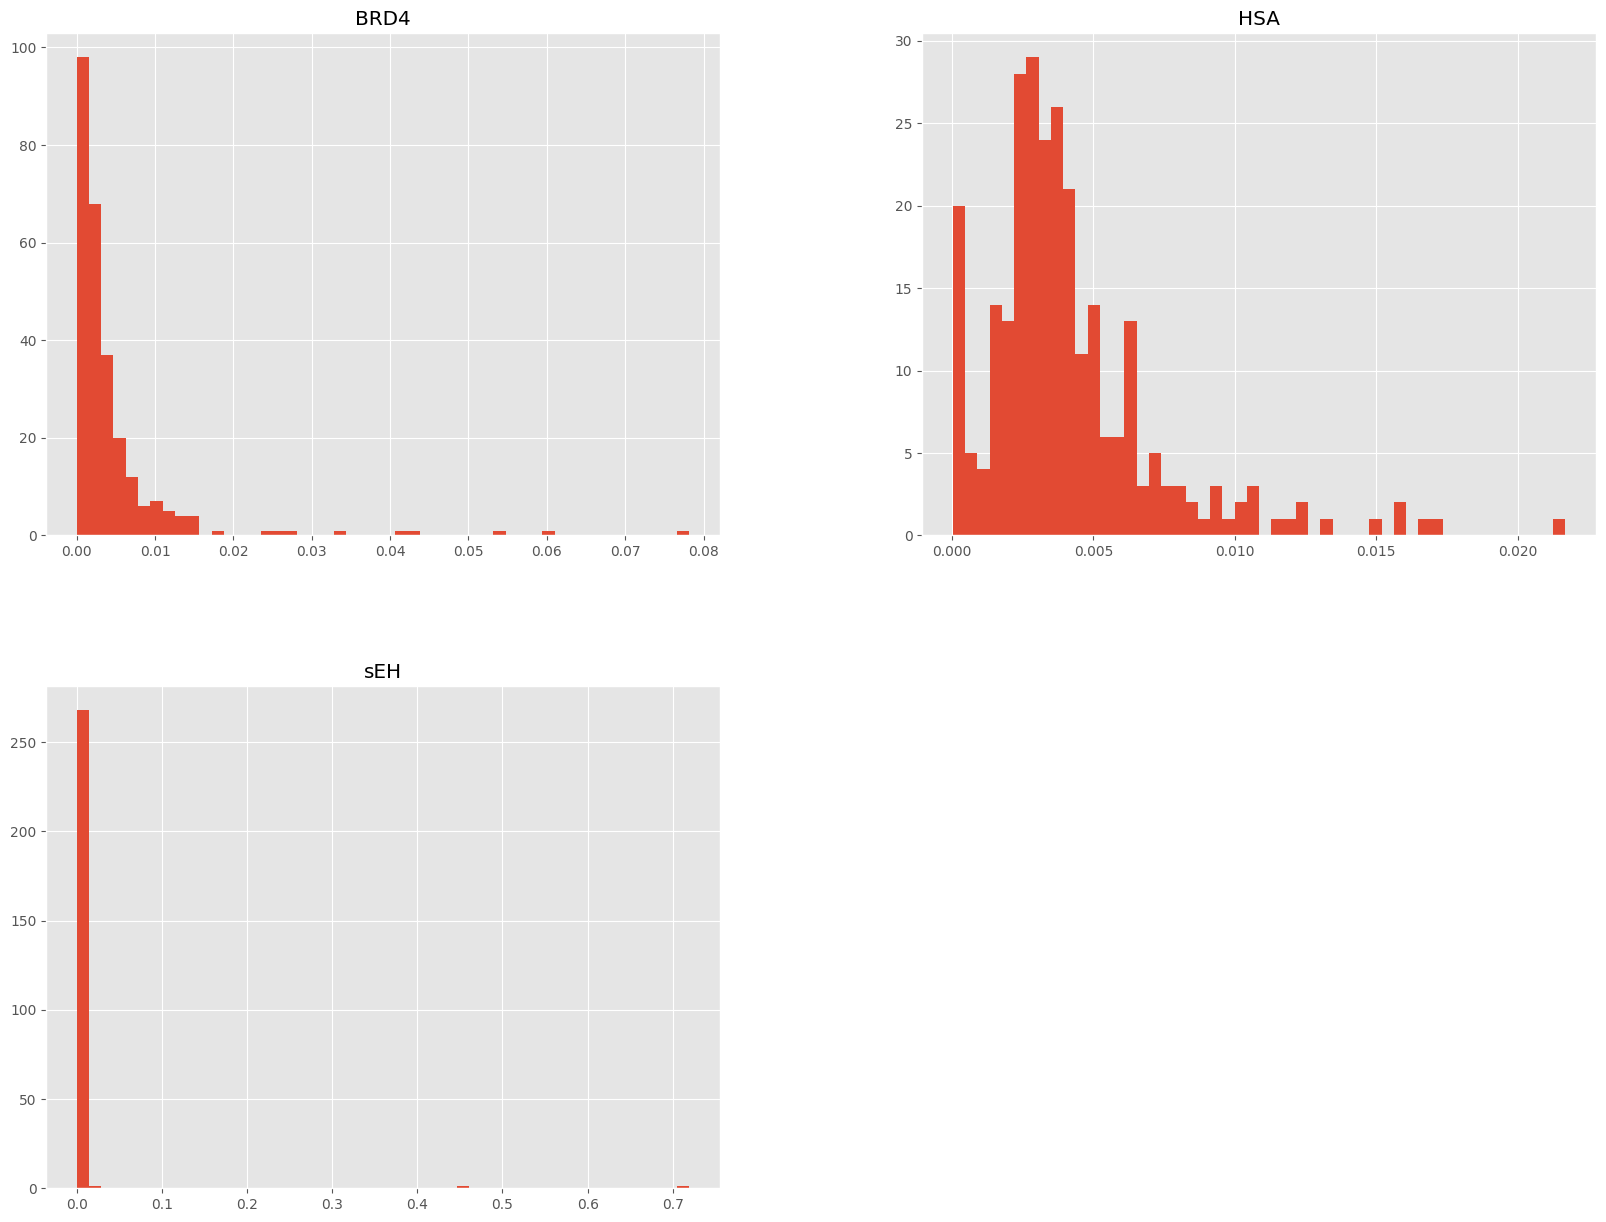

In [9]:
bb1_df.to_pandas()[PROTEINS].hist(bins = 50, log = False, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

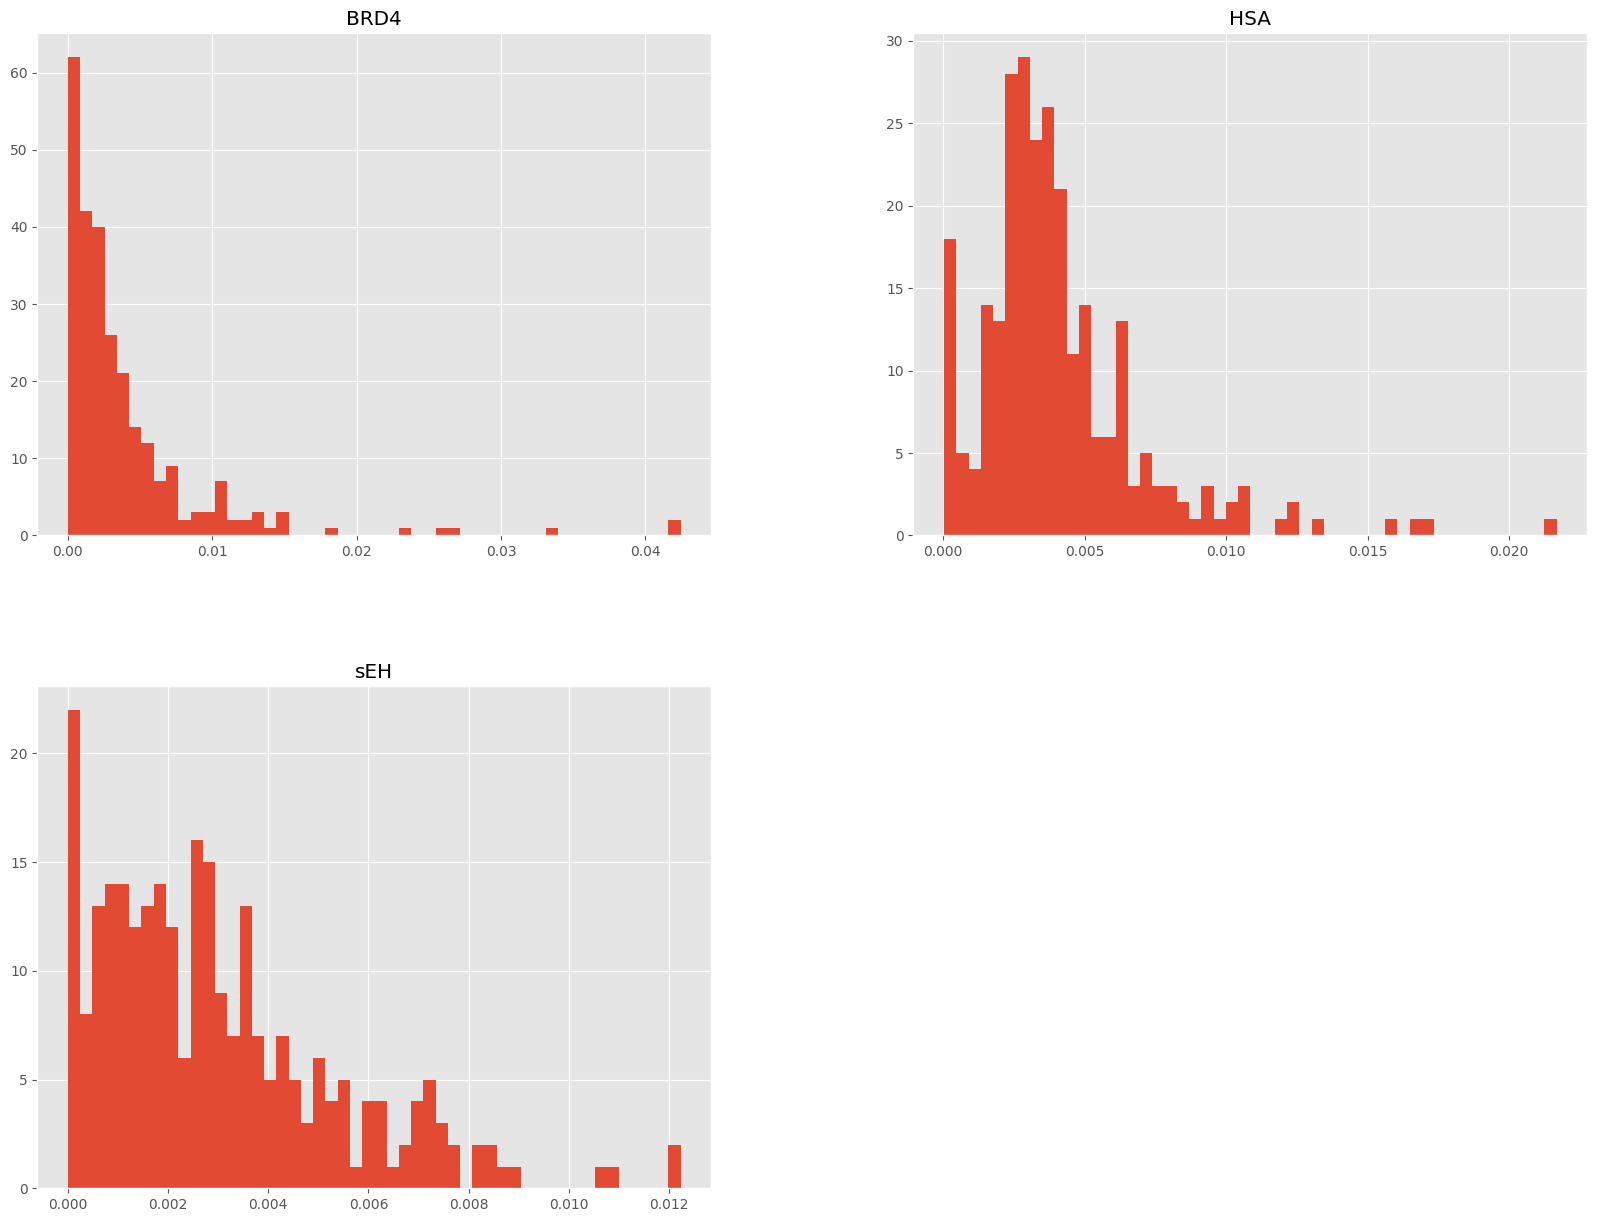

In [10]:
bb1_df.filter(pl.max_horizontal(PROTEINS) < 0.05).to_pandas()[PROTEINS].hist(bins = 50, log = False, figsize = (20, 15))

In [11]:
bb1_df.filter(pl.col('sEH') < 0.15).sort('sEH')

bb1,BRD4,HSA,sEH
u16,f64,f64,f64
1480,0.000047,0.000102,0.000003
7,0.000055,0.000099,0.000003
1253,0.000011,0.000041,0.000006
1060,0.000025,0.000094,0.000006
357,0.000019,0.000113,0.000008
…,…,…,…
582,0.025821,0.009221,0.01078
425,0.005346,0.008426,0.012148
928,0.041714,0.017084,0.01223


In [12]:
bb1_df.filter(pl.col('sEH') >= 0.15).sort('sEH')

bb1,BRD4,HSA,sEH
u16,f64,f64,f64
558,0.000152,0.000284,0.45318
1945,0.000055,0.000127,0.719465


In [10]:
train_df.shape

(98415610, 7)

In [14]:
train_df.filter(pl.col('bb1').is_in([558, 1945]) & (pl.col('sEH') == 1))

molecule,bb1,bb2,bb3,BRD4,HSA,sEH
str,u16,u16,u16,u8,u8,u8
"""C#CCOc1ccc(CNc…",1945,1653,765,0,0,1
"""C#CCOc1ccc(CNc…",1945,1653,205,0,0,1
"""C#CCOc1ccc(CNc…",1945,1653,146,0,0,1
"""C#CCOc1ccc(CNc…",1945,1653,439,0,0,1
"""C#CCOc1ccc(CNc…",1945,1653,196,0,0,1
…,…,…,…,…,…,…
"""O=C(N[Dy])[C@H…",558,1415,110,0,0,1
"""O=C(N[Dy])[C@H…",558,1415,84,0,0,1
"""O=C(N[Dy])[C@H…",558,1415,1474,0,0,1


In [15]:
train_df.filter(pl.col('sEH') == 1)

molecule,bb1,bb2,bb3,BRD4,HSA,sEH
str,u16,u16,u16,u8,u8,u8
"""C#CCOc1ccc(CNc…",1640,1653,266,0,1,1
"""C#CCOc1ccc(CNc…",1640,1653,1372,0,0,1
"""C#CCOc1cccc(CN…",1640,1596,266,0,0,1
"""C#CC[C@@H](CC(…",1640,1982,266,0,0,1
"""C#CC[C@@H](CC(…",1640,2090,266,0,0,1
…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1848,2025,0,1,1
"""[N-]=[N+]=NCCC…",141,84,1372,0,0,1
"""Cc1cc2cc(CNc3n…",141,1110,266,0,0,1


In [16]:
425_047 / 724_532

0.5866504170968294

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

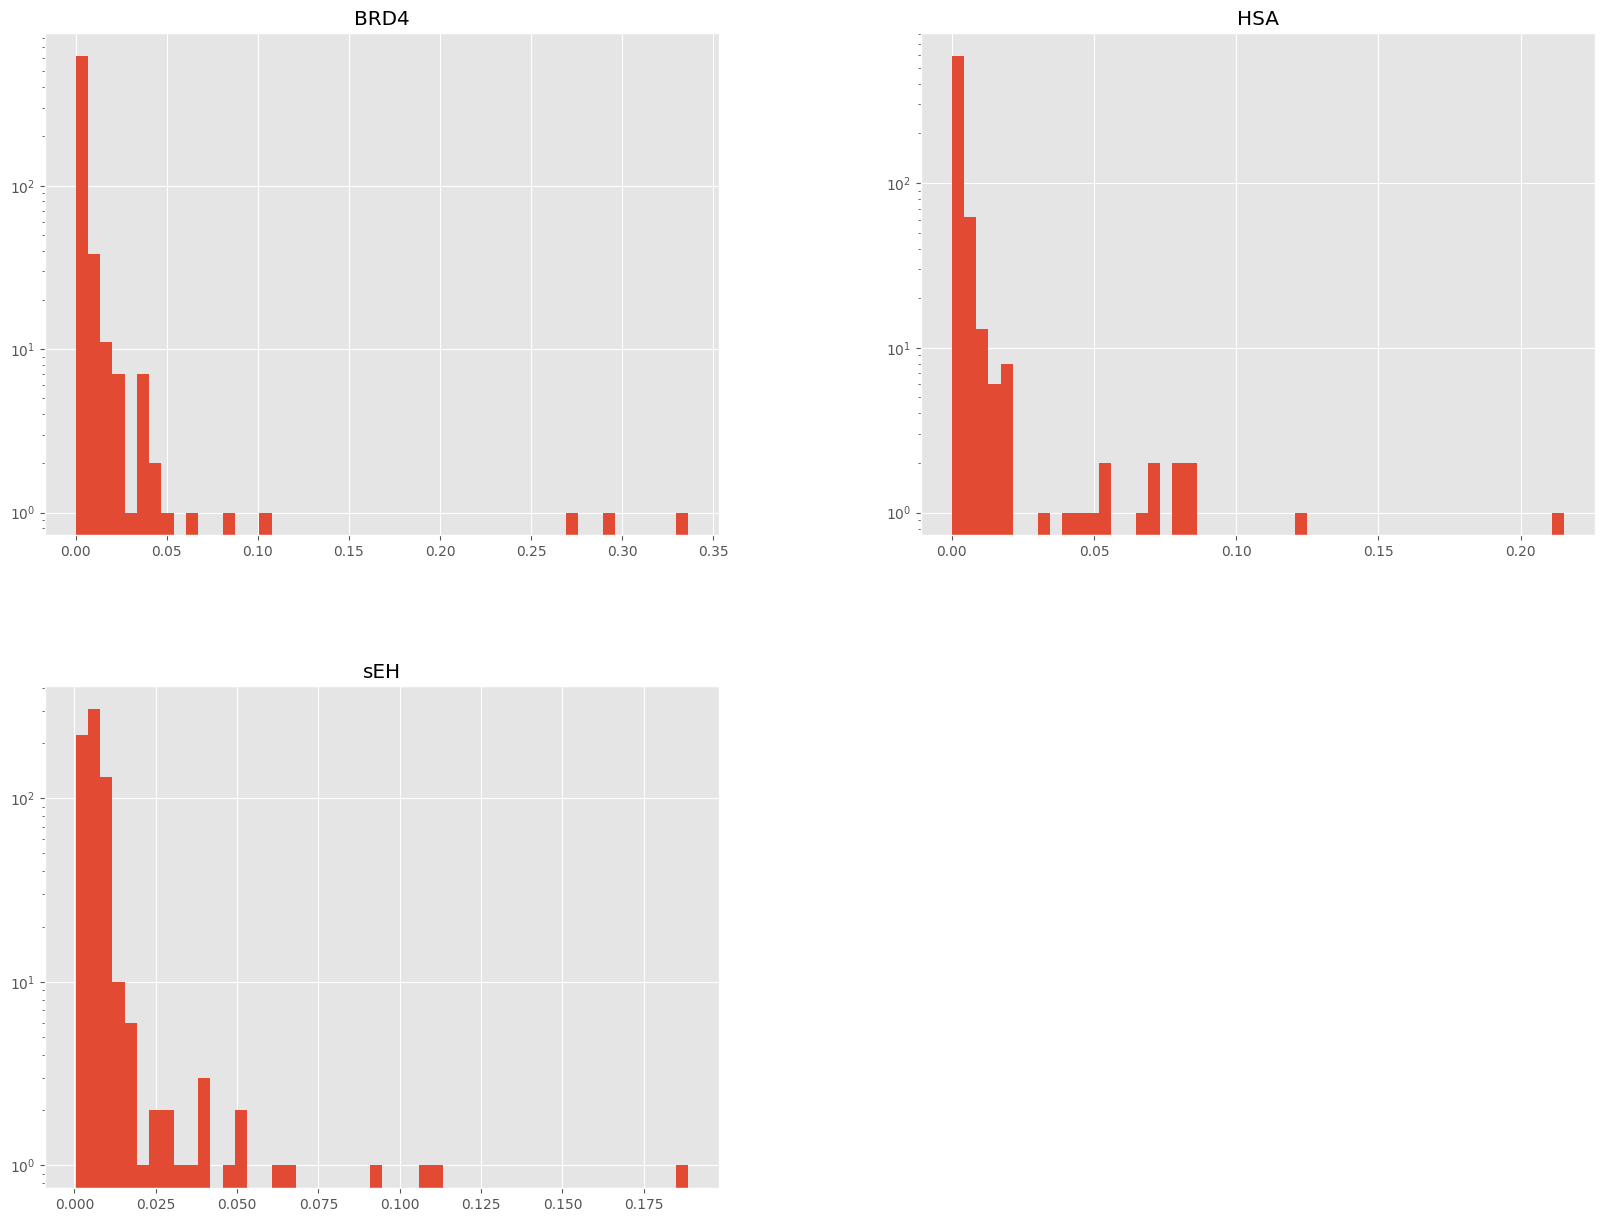

In [14]:
bb2_df.to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

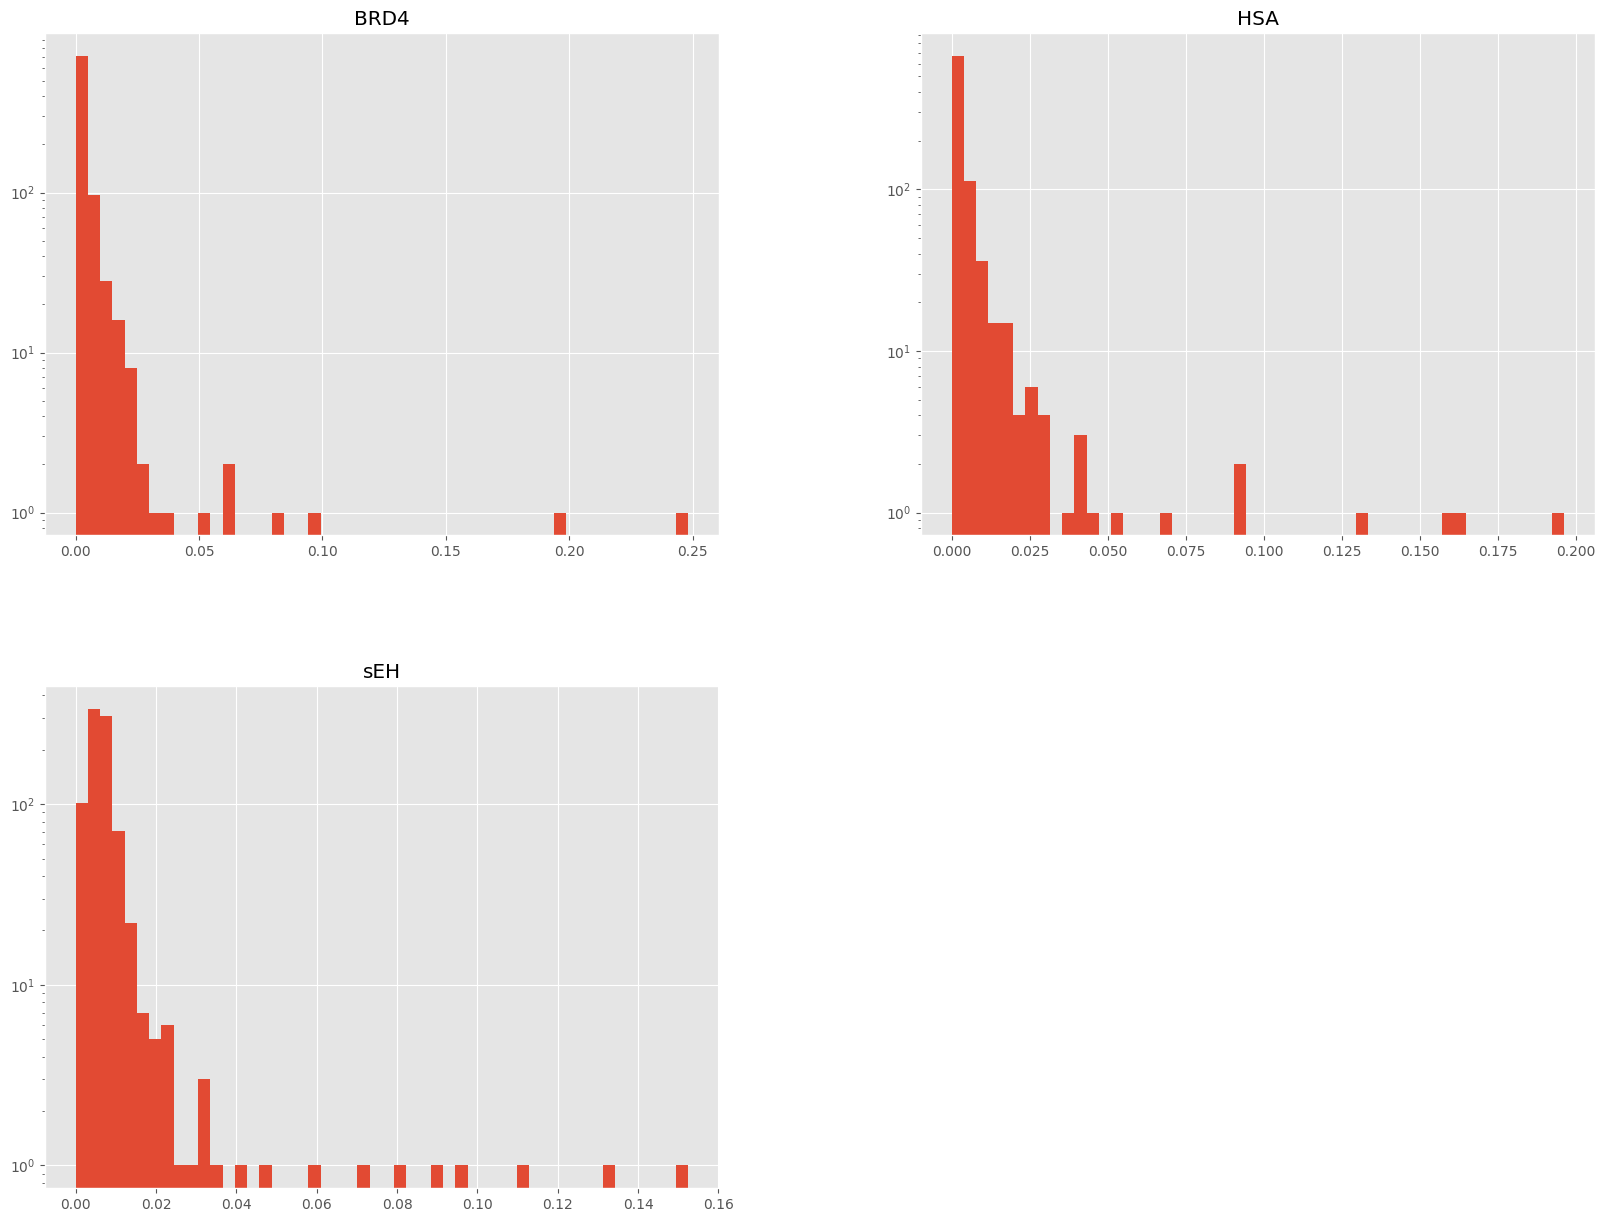

In [15]:
bb3_df.to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

In [16]:
bb23s = list(set(bb2_df['bb2'].to_list() + bb3_df['bb3'].to_list()))
len(bb23s)

874

In [17]:
bb23_pos_fractions = {}
for bb in tqdm(bb23s):
    sub_df = train_df.filter((pl.col('bb2') == bb) | (pl.col('bb3') == bb))
    print(f'bb={bb} num={sub_df.shape[0]}')
    ret = sub_df.select(pl.mean(PROTEINS)).to_dicts()[0]
    print(ret, '\n')
    bb23_pos_fractions[bb] = ret

print(bb23_pos_fractions)    

  1%|▍                                         | 9/874 [00:00<00:19, 44.19it/s]

bb=0 num=235619
{'BRD4': 0.00012732419711483368, 'HSA': 0.0005772030269205795, 'sEH': 0.0021263140918177225} 

bb=3 num=187073
{'BRD4': 0.0022771859113821877, 'HSA': 0.0023146044592218013, 'sEH': 0.004153458810197089} 

bb=5 num=235392
{'BRD4': 0.00038658917890157694, 'HSA': 0.0007986677542142469, 'sEH': 0.0028038336052202285} 

bb=2054 num=235623
{'BRD4': 0.005173518714217203, 'HSA': 0.002792596648035209, 'sEH': 0.005661586517445241} 

bb=6 num=187254
{'BRD4': 0.007129353712070236, 'HSA': 0.012710008864964166, 'sEH': 0.008832922127164173} 

bb=2057 num=48917
{'BRD4': 0.00034752744444671585, 'HSA': 0.011856818692887953, 'sEH': 0.007175419588282193} 

bb=9 num=187333
{'BRD4': 0.0029145959334447216, 'HSA': 0.006144139046510759, 'sEH': 0.006186843748832293} 

bb=2060 num=235569
{'BRD4': 0.0012268167713069206, 'HSA': 0.0024239182574956808, 'sEH': 0.003196515670567859} 

bb=15 num=235574
{'BRD4': 0.0009041744844507458, 'HSA': 0.0015366721285031454, 'sEH': 0.008549330571285456} 

bb=16 num=2

  3%|█▏                                       | 25/874 [00:00<00:13, 64.24it/s]

bb=17 num=235719
{'BRD4': 0.004853236268607961, 'HSA': 0.0033896291771134276, 'sEH': 0.00935011602798247} 

bb=2064 num=235513
{'BRD4': 0.0012695689834531427, 'HSA': 0.003923350303380281, 'sEH': 0.005379745491756294} 

bb=2066 num=235480
{'BRD4': 0.0022379819942245625, 'HSA': 0.0016646848989298453, 'sEH': 0.009830983523016817} 

bb=20 num=187335
{'BRD4': 0.0028344943550324287, 'HSA': 0.0038593962687164707, 'sEH': 0.005717030987268797} 

bb=2069 num=235636
{'BRD4': 0.0016550951467517697, 'HSA': 0.0013368076185302756, 'sEH': 0.0033738477991478383} 

bb=2070 num=235469
{'BRD4': 0.003728728622451363, 'HSA': 0.0009343055773796126, 'sEH': 0.0030322462829501973} 

bb=2071 num=235624
{'BRD4': 0.002470037008114623, 'HSA': 0.0020880725223237024, 'sEH': 0.005198961056598649} 

bb=24 num=235290
{'BRD4': 0.0020230354031195545, 'HSA': 0.0013175230566534915, 'sEH': 0.004139572442517744} 

bb=25 num=235364
{'BRD4': 0.0056763141347019935, 'HSA': 0.001886439727400962, 'sEH': 0.00448666745976445} 

bb=26

  4%|█▌                                       | 32/874 [00:00<00:13, 63.90it/s]

{'BRD4': 0.0013328862080236354, 'HSA': 0.0007428505936437458, 'sEH': 0.0027209556030036632} 

bb=33 num=235545
{'BRD4': 0.003409115031098092, 'HSA': 0.0007981489736568384, 'sEH': 0.007497505784457323} 

bb=2080 num=235344
{'BRD4': 0.0006501121762186417, 'HSA': 0.0010282820042151065, 'sEH': 0.003165578897273778} 

bb=34 num=187242
{'BRD4': 0.006836073103256748, 'HSA': 0.005351363476143173, 'sEH': 0.006788006964249474} 

bb=2081 num=186864
{'BRD4': 0.018847932185974827, 'HSA': 0.008150312526757427, 'sEH': 0.011484288038359448} 

bb=37 num=235445
{'BRD4': 0.0006116078064940857, 'HSA': 0.012393552634373209, 'sEH': 0.006736180424302916} 

bb=2085 num=235511
{'BRD4': 0.0007770337691233106, 'HSA': 0.000785525941463456, 'sEH': 0.0071504091104024866} 

bb=39 num=235348
{'BRD4': 0.0013384434964393154, 'HSA': 0.0015338987371891837, 'sEH': 0.006653976239441168} 

bb=2086 num=235678
{'BRD4': 0.0032374680708424208, 'HSA': 0.0017651202063832857, 'sEH': 0.014388275528475292} 

bb=2088 num=235739
{'BRD

  6%|██▎                                      | 49/874 [00:00<00:11, 70.99it/s]

bb=46 num=235586
{'BRD4': 0.0008574363502075675, 'HSA': 0.0023006460485767407, 'sEH': 0.0033872980567605884} 

bb=2092 num=235367
{'BRD4': 0.0018524262109811487, 'HSA': 0.0013595788704448798, 'sEH': 0.008250944270012365} 

bb=2093 num=235654
{'BRD4': 0.004315649214526382, 'HSA': 0.0030128917820194012, 'sEH': 0.008843473906659764} 

bb=49 num=235661
{'BRD4': 0.01489427609999109, 'HSA': 0.0029236912344426953, 'sEH': 0.008978999495037363} 

bb=2097 num=235322
{'BRD4': 0.0009306397191932756, 'HSA': 0.0010666236051027954, 'sEH': 0.005804812129762623} 

bb=44 num=187100
{'BRD4': 0.0050721539283805454, 'HSA': 0.006579369321218599, 'sEH': 0.006686264029930518} 

bb=47 num=187256
{'BRD4': 0.02243986841543128, 'HSA': 0.006637971546973128, 'sEH': 0.012405476994061606} 

bb=53 num=235571
{'BRD4': 0.00439782485959647, 'HSA': 0.0013711365151058493, 'sEH': 0.008426334311099414} 

bb=2101 num=235663
{'BRD4': 0.07367724250306582, 'HSA': 0.005694572334223022, 'sEH': 0.004345187831776732} 

bb=2096 num=1

  8%|███                                      | 66/874 [00:00<00:10, 76.45it/s]

bb=64 num=235599
{'BRD4': 0.0022623186006731776, 'HSA': 0.0028523041269275335, 'sEH': 0.007869303350184} 

bb=69 num=232882
{'BRD4': 0.0009962126742298675, 'HSA': 0.01105710187992202, 'sEH': 0.01047740916000378} 

bb=70 num=187080
{'BRD4': 0.0039074192858670085, 'HSA': 0.0033033996151379088, 'sEH': 0.0037684413085311095} 

bb=74 num=235522
{'BRD4': 0.0013204711237166805, 'HSA': 0.0010614719644024763, 'sEH': 0.0032820713139324565} 

bb=79 num=235552
{'BRD4': 0.0005179323461486211, 'HSA': 0.0020377666077978536, 'sEH': 0.0032901440021736177} 

bb=80 num=235627
{'BRD4': 0.0008700191404210892, 'HSA': 0.001574522444371825, 'sEH': 0.006446629630729925} 

bb=81 num=187162
{'BRD4': 0.009569250168303395, 'HSA': 0.00562079909383315, 'sEH': 0.006171124480396662} 

bb=84 num=235342
{'BRD4': 0.001695404985085535, 'HSA': 0.002417757986249798, 'sEH': 0.0075762082416228295} 

bb=85 num=235410
{'BRD4': 0.0005989550146552823, 'HSA': 0.0010237458051909434, 'sEH': 0.004434815853192303} 

bb=86 num=235364
{

  9%|███▉                                     | 83/874 [00:01<00:10, 77.48it/s]

bb=101 num=235555
{'BRD4': 0.0014858525609730213, 'HSA': 0.002551421111842245, 'sEH': 0.00721275286026618} 

bb=103 num=235548
{'BRD4': 0.0015920321972591573, 'HSA': 0.0006580399748671184, 'sEH': 0.005344982763598078} 

bb=105 num=186905
{'BRD4': 0.0024664936732564672, 'HSA': 0.008196677456461838, 'sEH': 0.005302158850753056} 

bb=109 num=235674
{'BRD4': 0.0016378556820014088, 'HSA': 0.00843538107725078, 'sEH': 0.010009589517723636} 

bb=110 num=235291
{'BRD4': 0.00192102545358726, 'HSA': 0.0017085226379249525, 'sEH': 0.007399348041361548} 

bb=113 num=235574
{'BRD4': 0.002220109180130235, 'HSA': 0.0009296441882380908, 'sEH': 0.0020672909574061655} 

bb=115 num=235627
{'BRD4': 0.0021771698489561893, 'HSA': 0.0007002593081438035, 'sEH': 0.007371820716641132} 

bb=116 num=234903
{'BRD4': 0.0020817103229843806, 'HSA': 0.002758585458678689, 'sEH': 0.008156558238932667} 

bb=118 num=235683
{'BRD4': 0.0016887089862230198, 'HSA': 0.0011243916616811565, 'sEH': 0.010815374889151954} 

bb=119 nu

 11%|████▋                                    | 99/874 [00:01<00:10, 76.36it/s]

bb=128 num=235523
{'BRD4': 0.0021017055659107602, 'HSA': 0.0019276249028757277, 'sEH': 0.009476781460833974} 

bb=129 num=235681
{'BRD4': 0.001684480293277778, 'HSA': 0.002668861724110132, 'sEH': 0.006911885132870278} 

bb=130 num=235345
{'BRD4': 0.0006671057383840745, 'HSA': 0.0018865920244747073, 'sEH': 0.005413329367524273} 

bb=131 num=235400
{'BRD4': 0.001032285471537808, 'HSA': 0.0030331350892098554, 'sEH': 0.005025488530161428} 

bb=132 num=235647
{'BRD4': 0.00917474018340993, 'HSA': 0.0024400904743111518, 'sEH': 0.005576137188251919} 

bb=135 num=235655
{'BRD4': 0.001531900447688358, 'HSA': 0.0016931531263923957, 'sEH': 0.0055632174152893} 

bb=136 num=235308
{'BRD4': 0.0011686810478181786, 'HSA': 0.0009731925816376833, 'sEH': 0.007241572747207914} 

bb=139 num=235431
{'BRD4': 0.0008792385030008792, 'HSA': 0.005470817352005471, 'sEH': 0.007055145669007055} 

bb=142 num=235643
{'BRD4': 0.0027414351370505384, 'HSA': 0.002032735960754192, 'sEH': 0.003721731602466443} 

bb=143 num=

 13%|█████▎                                  | 115/874 [00:01<00:09, 77.08it/s]

bb=154 num=235654
{'BRD4': 0.0011033124835564004, 'HSA': 0.0014385497381754605, 'sEH': 0.0036112266288711417} 

bb=155 num=235593
{'BRD4': 0.0013497854350511262, 'HSA': 0.0011120873710169657, 'sEH': 0.006583387452088984} 

bb=158 num=235473
{'BRD4': 0.001291018503182955, 'HSA': 0.004051419908014932, 'sEH': 0.007818306132762567} 

bb=2067 num=185975
{'BRD4': 0.012974862212662992, 'HSA': 0.006232020432853878, 'sEH': 0.0074095980642559485} 

bb=176 num=235472
{'BRD4': 0.0024801250254807366, 'HSA': 0.00150761024665353, 'sEH': 0.005966739145206224} 

bb=183 num=235679
{'BRD4': 0.010679780548967028, 'HSA': 0.00421760105906763, 'sEH': 0.005732373270422906} 

bb=187 num=235096
{'BRD4': 0.00023820056487562527, 'HSA': 0.002569163235444244, 'sEH': 0.001718446932317011} 

bb=188 num=187198
{'BRD4': 0.008434919176486928, 'HSA': 0.0048665049840276075, 'sEH': 0.007329138131817648} 

bb=192 num=235418
{'BRD4': 0.005742976322965958, 'HSA': 0.0014399918442939792, 'sEH': 0.0069281023541105605} 

bb=196 n

 15%|█████▉                                  | 131/874 [00:01<00:10, 73.75it/s]

bb=207 num=235668
{'BRD4': 0.0012135716346725054, 'HSA': 0.00210889895955327, 'sEH': 0.0028302527284145493} 

bb=208 num=235330
{'BRD4': 0.0007946288191050865, 'HSA': 0.0012238133684613097, 'sEH': 0.014154591424807716} 

bb=210 num=235578
{'BRD4': 0.009907546545093345, 'HSA': 0.0014814626153545746, 'sEH': 0.0072629872059360384} 

bb=215 num=235690
{'BRD4': 0.0006406720692434978, 'HSA': 0.0012346726632440918, 'sEH': 0.006640078068649497} 

bb=219 num=187090
{'BRD4': 0.004083596130204714, 'HSA': 0.0085787588860976, 'sEH': 0.008573413864984766} 

bb=223 num=187232
{'BRD4': 0.006019270210220475, 'HSA': 0.002147068877115023, 'sEH': 0.0052021022047513245} 

bb=224 num=235383
{'BRD4': 0.0016271353496216804, 'HSA': 0.0013212508974734794, 'sEH': 0.011470666955557538} 

bb=226 num=235498
{'BRD4': 0.0008152935481405362, 'HSA': 0.0017537303926147992, 'sEH': 0.0066964475282168005} 

bb=227 num=187217
{'BRD4': 0.003114033447817239, 'HSA': 0.004080825993365987, 'sEH': 0.005384126441509051} 

bb=229 n

 17%|██████▋                                 | 147/874 [00:02<00:10, 71.78it/s]

bb=240 num=187203
{'BRD4': 0.002948670694379898, 'HSA': 0.0030020886417418523, 'sEH': 0.005047996025704716} 

bb=243 num=235571
{'BRD4': 0.001277746411909785, 'HSA': 0.0020503372656226785, 'sEH': 0.007343858114963217} 

bb=245 num=187202
{'BRD4': 0.003776669052681061, 'HSA': 0.008594993643230308, 'sEH': 0.006249933227209111} 

bb=247 num=187085
{'BRD4': 0.0024855012427506215, 'HSA': 0.004340273137878504, 'sEH': 0.005607076997086886} 

bb=248 num=235387
{'BRD4': 0.0023195843440801745, 'HSA': 0.001597369438414186, 'sEH': 0.0061898065738549704} 

bb=249 num=235305
{'BRD4': 0.0005397250377170056, 'HSA': 0.0010752002719874205, 'sEH': 0.0007989630479590319} 

bb=251 num=235455
{'BRD4': 0.0021108067358943322, 'HSA': 0.0009555966108173536, 'sEH': 0.009110021023125438} 

bb=253 num=235588
{'BRD4': 0.0016554323649761449, 'HSA': 0.0012988777017505135, 'sEH': 0.0075258502130838584} 

bb=254 num=235593
{'BRD4': 0.0012266917947477216, 'HSA': 0.0023982036817732275, 'sEH': 0.00715216496245644} 

bb=26

 19%|███████▌                                | 164/874 [00:02<00:09, 73.56it/s]

bb=267 num=187108
{'BRD4': 0.0034899630160121426, 'HSA': 0.014831006691322658, 'sEH': 0.007279218419308634} 

bb=268 num=187108
{'BRD4': 0.0025012292365906323, 'HSA': 0.003746499347970156, 'sEH': 0.005446052547191996} 

bb=270 num=235591
{'BRD4': 0.0012097236312083228, 'HSA': 0.0014728915790501334, 'sEH': 0.0010951182345675344} 

bb=279 num=235376
{'BRD4': 0.0025746040377948474, 'HSA': 0.0010408877710556725, 'sEH': 0.006364285228740398} 

bb=2091 num=187135
{'BRD4': 0.006994950169663612, 'HSA': 0.0157373019477917, 'sEH': 0.012669997595318887} 

bb=282 num=235489
{'BRD4': 0.000535056839172955, 'HSA': 0.0057624772282357135, 'sEH': 0.0060597310277762445} 

bb=283 num=235427
{'BRD4': 0.0029733208170685606, 'HSA': 0.0028034167703789286, 'sEH': 0.007879300165231685} 

bb=286 num=235522
{'BRD4': 0.0017662893487657204, 'HSA': 0.001418126544441708, 'sEH': 0.00266641757457902} 

bb=287 num=235402
{'BRD4': 0.001448585823399971, 'HSA': 0.0010662611192768115, 'sEH': 0.0036320846891700156} 

bb=288 

 21%|████████▏                               | 180/874 [00:02<00:09, 72.07it/s]

bb=308 num=235532
{'BRD4': 0.001243992323760678, 'HSA': 0.0007854559040809742, 'sEH': 0.004165039145423976} 

bb=313 num=235579
{'BRD4': 0.001320151626418314, 'HSA': 0.0017531274009992403, 'sEH': 0.004032617508351763} 

bb=314 num=235278
{'BRD4': 0.013354414777412253, 'HSA': 0.002431166534907641, 'sEH': 0.009053120138729503} 

bb=316 num=235532
{'BRD4': 0.0026153558752101624, 'HSA': 0.0019742540291765027, 'sEH': 0.0017237572813885162} 

bb=318 num=186895
{'BRD4': 0.015211749913052783, 'HSA': 0.007560394874127184, 'sEH': 0.011236255651569063} 

bb=320 num=235563
{'BRD4': 0.0010825129583168834, 'HSA': 0.0013966539736715868, 'sEH': 0.002729630714501004} 

bb=324 num=234750
{'BRD4': 0.0010820021299254527, 'HSA': 0.0014270500532481364, 'sEH': 0.006602768903088392} 

bb=325 num=235569
{'BRD4': 0.0006876965984488621, 'HSA': 0.0007089218021046912, 'sEH': 0.007225059324444218} 

bb=328 num=186946
{'BRD4': 0.011163651535737593, 'HSA': 0.004814224428444577, 'sEH': 0.00868700052421555} 

bb=329 nu

 22%|████████▌                               | 188/874 [00:02<00:09, 72.21it/s]

bb=339 num=234711
{'BRD4': 0.0018064769013808471, 'HSA': 0.001022534095121234, 'sEH': 0.010280728214698075} 

bb=340 num=187154
{'BRD4': 0.002169336482255255, 'HSA': 0.0038096968272118147, 'sEH': 0.0055515778449832754} 

bb=344 num=234972
{'BRD4': 0.0005787923667500809, 'HSA': 0.00027237287847062627, 'sEH': 0.004123895613094326} 

bb=348 num=187316
{'BRD4': 0.009534690042495035, 'HSA': 0.00838689700826411, 'sEH': 0.008653825620875953} 

bb=354 num=187138
{'BRD4': 0.009773536107044, 'HSA': 0.004461947867349229, 'sEH': 0.014438542679733673} 

bb=358 num=235701
{'BRD4': 0.005197262633590863, 'HSA': 0.0016970653497439554, 'sEH': 0.006660981497745025} 

bb=361 num=235304
{'BRD4': 0.001793424676163601, 'HSA': 0.002171658790330806, 'sEH': 0.006523476014007412} 

bb=365 num=235512
{'BRD4': 0.007056965250178335, 'HSA': 0.0013842182139338973, 'sEH': 0.008415707055266822} 

bb=367 num=235685
{'BRD4': 0.004217493688609797, 'HSA': 0.0013322867386554088, 'sEH': 0.007170587860916053} 

bb=370 num=235

 23%|█████████▎                              | 204/874 [00:02<00:09, 69.23it/s]

bb=385 num=235352
{'BRD4': 0.0013256738842244808, 'HSA': 0.0018695400931370884, 'sEH': 0.006602875692579626} 

bb=386 num=235576
{'BRD4': 0.0021818861004516588, 'HSA': 0.001086698135633511, 'sEH': 0.0030733181648385233} 

bb=389 num=187182
{'BRD4': 0.001260804991932985, 'HSA': 0.0024681860435298267, 'sEH': 0.004044192283446058} 

bb=391 num=235681
{'BRD4': 0.020230735612968377, 'HSA': 0.0010607558521900365, 'sEH': 0.004629138538957319} 

bb=393 num=235294
{'BRD4': 0.002456501228250614, 'HSA': 0.0014535007267503634, 'sEH': 0.009605004802502402} 

bb=395 num=235558
{'BRD4': 0.006074936958201377, 'HSA': 0.0011674407152378607, 'sEH': 0.0063423870129649595} 

bb=397 num=235699
{'BRD4': 0.0011837131256390565, 'HSA': 0.0012897806100153162, 'sEH': 0.005850682438194477} 

bb=399 num=186955
{'BRD4': 0.004498408707977856, 'HSA': 0.030948624000427912, 'sEH': 0.015378032146773288} 

bb=404 num=235300
{'BRD4': 0.001457713557161071, 'HSA': 0.0017212069698257543, 'sEH': 0.006799830004249894} 

bb=406 

 25%|██████████                              | 221/874 [00:03<00:09, 71.79it/s]

bb=421 num=235640
{'BRD4': 0.0010779154642675268, 'HSA': 0.0011118655576302834, 'sEH': 0.005355627227974877} 

bb=423 num=187236
{'BRD4': 0.002382020551603324, 'HSA': 0.004529043559999145, 'sEH': 0.003968253968253968} 

bb=433 num=235557
{'BRD4': 0.0020886664374227893, 'HSA': 0.00148583994532109, 'sEH': 0.0060876985188298375} 

bb=435 num=235578
{'BRD4': 0.0011588518452487074, 'HSA': 0.0022158266052008254, 'sEH': 0.005484383091799744} 

bb=437 num=235562
{'BRD4': 0.0015749569115561933, 'HSA': 0.0015664665778011733, 'sEH': 0.005183348757439655} 

bb=438 num=235561
{'BRD4': 0.0012013873264250024, 'HSA': 0.0017659969179957633, 'sEH': 0.006563055853897716} 

bb=439 num=235543
{'BRD4': 0.0020166169234492218, 'HSA': 0.0010656228374436938, 'sEH': 0.0033284793010193467} 

bb=444 num=235609
{'BRD4': 0.002266466900670178, 'HSA': 0.0009082844882835545, 'sEH': 0.002932825146747365} 

bb=448 num=235502
{'BRD4': 0.0017367156117570127, 'HSA': 0.0011719645693030207, 'sEH': 0.002959635162334078} 

bb=4

 27%|██████████▊                             | 236/874 [00:03<00:09, 68.90it/s]

bb=470 num=235572
{'BRD4': 0.0074796665138471465, 'HSA': 0.0016979946682967415, 'sEH': 0.008825327288472315} 

bb=471 num=187285
{'BRD4': 0.019990922924953948, 'HSA': 0.004330298742558134, 'sEH': 0.005403529380356141} 

bb=474 num=235229
{'BRD4': 0.0011903294236680002, 'HSA': 0.0005866623588078, 'sEH': 0.0039705988632354} 

bb=478 num=235660
{'BRD4': 0.00606382075872019, 'HSA': 0.0032334719511160144, 'sEH': 0.008834761945175252} 

bb=480 num=235577
{'BRD4': 0.002313468632336773, 'HSA': 0.010276894603462986, 'sEH': 0.0053146105095149354} 

bb=483 num=235194
{'BRD4': 0.001373334353767528, 'HSA': 0.0010289378130394482, 'sEH': 0.0048810768982201925} 

bb=487 num=187113
{'BRD4': 0.00459080876261938, 'HSA': 0.011148343514346945, 'sEH': 0.009887073586549304} 

bb=489 num=235627
{'BRD4': 0.0067861492952844965, 'HSA': 0.0038917441549567748, 'sEH': 0.0030344570019564822} 

bb=496 num=187299
{'BRD4': 0.016134629656324912, 'HSA': 0.0031553825701151634, 'sEH': 0.005792876630414471} 

bb=498 num=234

 29%|███████████▌                            | 252/874 [00:03<00:08, 71.44it/s]

bb=510 num=235417
{'BRD4': 0.002527430049656567, 'HSA': 0.0014867235586215099, 'sEH': 0.007705475815255483} 

bb=518 num=235478
{'BRD4': 0.000879063012255922, 'HSA': 0.0007134424447294439, 'sEH': 0.04085307332319792} 

bb=519 num=187388
{'BRD4': 0.007876705018464363, 'HSA': 0.00552329925075245, 'sEH': 0.0066546417059790385} 

bb=524 num=235312
{'BRD4': 0.0001104916026381995, 'HSA': 0.0006926973550010199, 'sEH': 0.0005567076902155436} 

bb=526 num=187079
{'BRD4': 0.004869600543086076, 'HSA': 0.0065266545149375394, 'sEH': 0.006959626681776148} 

bb=528 num=235410
{'BRD4': 0.00044178242215708765, 'HSA': 0.0003568242640499554, 'sEH': 0.00648230746357419} 

bb=531 num=235482
{'BRD4': 0.0032783822118038746, 'HSA': 0.005418673189458218, 'sEH': 0.00347372622960566} 

bb=533 num=234773
{'BRD4': 0.0018187781388830913, 'HSA': 0.0013119055428009183, 'sEH': 0.006112287188049733} 

bb=534 num=187309
{'BRD4': 0.004922347564719261, 'HSA': 0.0032619895466848895, 'sEH': 0.00678557890971603} 

bb=536 num

 31%|████████████▎                           | 269/874 [00:03<00:08, 75.40it/s]

bb=548 num=235658
{'BRD4': 0.005223671591883153, 'HSA': 0.0004498043775301496, 'sEH': 0.002512115014130647} 

bb=551 num=235214
{'BRD4': 0.0034521754657460867, 'HSA': 0.0008970554473798328, 'sEH': 0.0021512324946644334} 

bb=553 num=235316
{'BRD4': 0.0007479304424688504, 'HSA': 0.0015256081184449846, 'sEH': 0.002983222560301892} 

bb=564 num=187154
{'BRD4': 5.343193306047426e-06, 'HSA': 0.0002831892452205136, 'sEH': 0.0001442662192632805} 

bb=566 num=235477
{'BRD4': 0.0018175872802863975, 'HSA': 0.0007728992640470195, 'sEH': 0.0033973594024044812} 

bb=567 num=235485
{'BRD4': 0.0009979404208335988, 'HSA': 0.0006964350170923838, 'sEH': 0.0022506741406034354} 

bb=570 num=235300
{'BRD4': 0.0006842328941776456, 'HSA': 0.0003144921376965576, 'sEH': 0.004751381215469613} 

bb=572 num=235684
{'BRD4': 0.002719743385210706, 'HSA': 0.0022445308124437804, 'sEH': 0.007692503521664602} 

bb=576 num=187105
{'BRD4': 0.000657384890836696, 'HSA': 0.007600010689185217, 'sEH': 0.0031479650463643407} 



 32%|████████████▋                           | 277/874 [00:03<00:08, 72.31it/s]

bb=600 num=187290
{'BRD4': 0.004362219018634204, 'HSA': 0.0045010411661060385, 'sEH': 0.005750440493352555} 

bb=604 num=187304
{'BRD4': 0.008003032503310126, 'HSA': 0.006433391705462777, 'sEH': 0.006577542390979371} 

bb=606 num=235466
{'BRD4': 0.00023357937027001775, 'HSA': 0.0004926401263876738, 'sEH': 0.0035971223021582736} 

bb=609 num=187208
{'BRD4': 0.00398487244134866, 'HSA': 0.005491218324003248, 'sEH': 0.006297807785992052} 

bb=611 num=235667
{'BRD4': 0.003186699877369339, 'HSA': 0.0013451183237364586, 'sEH': 0.005838747045619454} 

bb=612 num=235362
{'BRD4': 0.0010112082664151393, 'HSA': 0.0007265403930965916, 'sEH': 0.0075840619981135445} 

bb=614 num=235449
{'BRD4': 0.001087284295112742, 'HSA': 0.0016861400982803069, 'sEH': 0.0031514255741158384} 

bb=615 num=235266
{'BRD4': 0.0017597102853791028, 'HSA': 0.003149626380352452, 'sEH': 0.003056115205767089} 

bb=616 num=235640
{'BRD4': 0.015362417246647428, 'HSA': 0.0012222033610592429, 'sEH': 0.002805126464097776} 

bb=618 

 34%|█████████████▍                          | 294/874 [00:04<00:07, 75.63it/s]

bb=632 num=235645
{'BRD4': 0.013503363109762566, 'HSA': 0.0026395637505569817, 'sEH': 0.005228203441617688} 

bb=638 num=235517
{'BRD4': 0.0002844805258219152, 'HSA': 0.08034239566570565, 'sEH': 0.017918027148783315} 

bb=641 num=186878
{'BRD4': 0.0015625167221395776, 'HSA': 0.006025321332634125, 'sEH': 0.006094885433277325} 

bb=643 num=235572
{'BRD4': 0.0011419014144295587, 'HSA': 0.002521522082420661, 'sEH': 0.00810792454111694} 

bb=644 num=235469
{'BRD4': 0.0037457159965855378, 'HSA': 0.002870866228675537, 'sEH': 0.0080477684960653} 

bb=654 num=235601
{'BRD4': 0.0012436279981833693, 'HSA': 0.0018972754784572221, 'sEH': 0.006600141765102864} 

bb=655 num=235314
{'BRD4': 0.0041051531145618195, 'HSA': 0.001908088766499231, 'sEH': 0.009238719328216766} 

bb=659 num=234319
{'BRD4': 0.0015961146983385897, 'HSA': 0.0021466462386746273, 'sEH': 0.0038921299595850102} 

bb=661 num=235616
{'BRD4': 0.000314070351758794, 'HSA': 0.0006748268368871384, 'sEH': 0.004520066548961021} 

bb=664 num=

 35%|██████████████▏                         | 310/874 [00:04<00:08, 68.69it/s]

{'BRD4': 0.0019527436047646943, 'HSA': 0.0022753708090301654, 'sEH': 0.004593192565989998} 

bb=678 num=235651
{'BRD4': 0.0028601618495147484, 'HSA': 0.002741342069416213, 'sEH': 0.007714798579254915} 

bb=679 num=187174
{'BRD4': 0.02172844519003708, 'HSA': 0.003472704542297541, 'sEH': 0.005412076463611399} 

bb=683 num=235559
{'BRD4': 0.0010188530262057488, 'HSA': 0.0011249835497688478, 'sEH': 0.007390929660934203} 

bb=684 num=235619
{'BRD4': 0.006111561461512018, 'HSA': 0.0010016170173033584, 'sEH': 0.008713219222558452} 

bb=687 num=233970
{'BRD4': 0.002795230157712527, 'HSA': 0.0005898192075907168, 'sEH': 0.011535666965850323} 

bb=688 num=235688
{'BRD4': 0.004815688537388412, 'HSA': 0.002019619157530294, 'sEH': 0.0033306744509690777} 

bb=691 num=235263
{'BRD4': 0.0013219248245580479, 'HSA': 0.001742730476105465, 'sEH': 0.003243178910410902} 

bb=695 num=234575
{'BRD4': 0.0008227645742299904, 'HSA': 0.0026217627624427154, 'sEH': 0.007217307897261004} 

bb=703 num=235580
{'BRD4': 

 37%|██████████████▉                         | 326/874 [00:04<00:07, 70.69it/s]

bb=715 num=235518
{'BRD4': 0.0012737879907268235, 'HSA': 0.0013502152701704328, 'sEH': 0.005014478723494595} 

bb=718 num=235571
{'BRD4': 0.002033357246859758, 'HSA': 0.0024875727487678875, 'sEH': 0.007140097889808168} 

bb=720 num=187205
{'BRD4': 0.006575679068400951, 'HSA': 0.003792633743756844, 'sEH': 0.004786196949867792} 

bb=721 num=235655
{'BRD4': 0.0028983047251278354, 'HSA': 0.002087797840062804, 'sEH': 0.007451571152744478} 

bb=724 num=235556
{'BRD4': 0.0003183956256686308, 'HSA': 0.0008108475267027798, 'sEH': 0.0023900898300191886} 

bb=725 num=187267
{'BRD4': 0.00430401512279259, 'HSA': 0.017045181478851052, 'sEH': 0.006589521912563345} 

bb=726 num=186893
{'BRD4': 0.003788263872911238, 'HSA': 0.003028470836253899, 'sEH': 0.004510602323254483} 

bb=727 num=235673
{'BRD4': 0.009835662125063116, 'HSA': 0.0015869446224217453, 'sEH': 0.0051215030996338146} 

bb=728 num=187209
{'BRD4': 0.004609821109027878, 'HSA': 0.005539263603779733, 'sEH': 0.006890694357643062} 

bb=729 num=

 39%|███████████████▋                        | 342/874 [00:04<00:07, 70.56it/s]

bb=743 num=235650
{'BRD4': 0.002117547209845109, 'HSA': 0.0022788033099936347, 'sEH': 0.007901548907277742} 

bb=746 num=235520
{'BRD4': 0.0014988111413043478, 'HSA': 0.002025305706521739, 'sEH': 0.00555366847826087} 

bb=747 num=235586
{'BRD4': 0.0036759399964344233, 'HSA': 0.0075428930411824135, 'sEH': 0.02737429219053764} 

bb=749 num=235681
{'BRD4': 0.0021299977511975935, 'HSA': 0.0021087826341537924, 'sEH': 0.006118439755432131} 

bb=752 num=235731
{'BRD4': 0.00364822615608469, 'HSA': 0.0009417514030823269, 'sEH': 0.005832919726298196} 

bb=754 num=235274
{'BRD4': 0.005363958618461878, 'HSA': 0.001959417530198832, 'sEH': 0.0034215425418873315} 

bb=757 num=187153
{'BRD4': 0.0038578061799703985, 'HSA': 0.0056691583891254746, 'sEH': 0.006214167018428772} 

bb=763 num=235337
{'BRD4': 0.0006203869344811908, 'HSA': 0.0009390788528790628, 'sEH': 0.003025448611990465} 

bb=764 num=235692
{'BRD4': 0.00254569522936714, 'HSA': 0.0015528740899139555, 'sEH': 0.003899156526314003} 

bb=765 num

 40%|████████████████                        | 350/874 [00:04<00:07, 72.61it/s]

bb=778 num=234744
{'BRD4': 0.0010479501073509866, 'HSA': 0.0019553215417646456, 'sEH': 0.006875575094571107} 

bb=780 num=186918
{'BRD4': 0.011363271595030975, 'HSA': 0.004622347767470228, 'sEH': 0.007158219112124033} 

bb=781 num=235172
{'BRD4': 0.001182113516915279, 'HSA': 0.0010290340686816457, 'sEH': 0.0018454577925943565} 

bb=783 num=187246
{'BRD4': 0.005260459502472683, 'HSA': 0.004128259081635922, 'sEH': 0.006243124018670626} 

bb=784 num=235692
{'BRD4': 0.0013280043446531914, 'HSA': 0.0019941279296709267, 'sEH': 0.006754578008587479} 

bb=785 num=235667
{'BRD4': 0.002019799123339288, 'HSA': 0.0029236167982789273, 'sEH': 0.008316819919632363} 

bb=790 num=235445
{'BRD4': 0.0009259062626091019, 'HSA': 0.001703157850028669, 'sEH': 0.006094841682770923} 

bb=794 num=235632
{'BRD4': 0.001438684049704624, 'HSA': 0.001998879608881646, 'sEH': 0.0031192707272356896} 

bb=798 num=235419
{'BRD4': 0.0005904366257608774, 'HSA': 0.0005224726976157404, 'sEH': 0.004179781580925923} 

bb=799 n

 42%|████████████████▋                       | 365/874 [00:05<00:07, 63.83it/s]

bb=804 num=235731
{'BRD4': 0.0008950880452719413, 'HSA': 0.0007126767374677069, 'sEH': 0.0028082857154977494} 

bb=806 num=235645
{'BRD4': 0.007536760805448874, 'HSA': 0.0014895287402660782, 'sEH': 0.006340045407286384} 

bb=807 num=235689
{'BRD4': 0.001404393077317991, 'HSA': 0.0017820093428204116, 'sEH': 0.006894679004959926} 

bb=809 num=235694
{'BRD4': 0.03652617376768182, 'HSA': 0.002049267270274169, 'sEH': 0.0009461420316172665} 

bb=811 num=235420
{'BRD4': 0.004774445671565712, 'HSA': 0.0016863478039249, 'sEH': 0.007509982159544643} 

bb=815 num=186918
{'BRD4': 0.012930803881916135, 'HSA': 0.0042960014551835565, 'sEH': 0.007671813308509614} 

bb=816 num=235560
{'BRD4': 0.006006962132789948, 'HSA': 0.0014645950076413654, 'sEH': 0.00728476821192053} 

bb=817 num=235534
{'BRD4': 0.0014774936951777663, 'HSA': 0.002262942929683188, 'sEH': 0.006805811475201032} 

bb=819 num=187230
{'BRD4': 0.01153127169791166, 'HSA': 0.009608502910858303, 'sEH': 0.009090423543235592} 

bb=821 num=2353

 43%|█████████████████▍                      | 380/874 [00:05<00:07, 68.21it/s]

bb=826 num=235425
{'BRD4': 0.006528618455983859, 'HSA': 0.0012020813422533715, 'sEH': 0.0032451948603589255} 

bb=828 num=235592
{'BRD4': 0.0011078474651091718, 'HSA': 0.0013073449013548846, 'sEH': 0.0032641176270841116} 

bb=829 num=235672
{'BRD4': 0.2705879357751451, 'HSA': 0.0010523099901558097, 'sEH': 0.0012856851895855256} 

bb=830 num=235439
{'BRD4': 0.002633378497190355, 'HSA': 0.0009556615513997256, 'sEH': 0.003002900963731582} 

bb=837 num=186745
{'BRD4': 0.007962729925834694, 'HSA': 0.007598597017323088, 'sEH': 0.011893223379474684} 

bb=839 num=235526
{'BRD4': 0.002203578373512903, 'HSA': 0.0005986600205497482, 'sEH': 0.007247607482825675} 

bb=840 num=187099
{'BRD4': 0.004794253309745108, 'HSA': 0.00399788347345523, 'sEH': 0.004265121673552504} 

bb=842 num=235448
{'BRD4': 0.0020514083789201863, 'HSA': 0.008320308518229078, 'sEH': 0.012542047500934388} 

bb=843 num=235527
{'BRD4': 0.00367686082699648, 'HSA': 0.004143898576384024, 'sEH': 0.0074938329788092235} 

bb=844 num=2

 45%|██████████████████                      | 394/874 [00:05<00:07, 61.20it/s]

bb=857 num=235402
{'BRD4': 0.0008708507149471967, 'HSA': 0.001677980645873867, 'sEH': 0.0028292028105113805} 

bb=859 num=235566
{'BRD4': 0.001961233794350628, 'HSA': 0.002738086141463539, 'sEH': 0.007619945153375275} 

bb=869 num=48904
{'BRD4': 0.0002862751513168657, 'HSA': 0.0020039260592180598, 'sEH': 0.002331097660723049} 

bb=878 num=234632
{'BRD4': 0.0013126939206928297, 'HSA': 0.0011336902042347165, 'sEH': 0.007207030584063555} 

bb=882 num=235651
{'BRD4': 0.04978548786128639, 'HSA': 0.0010736215844617677, 'sEH': 0.004646702114567729} 

bb=884 num=235561
{'BRD4': 0.00012311036207182004, 'HSA': 0.00042876367480185597, 'sEH': 0.003353696070232339} 

bb=885 num=187118
{'BRD4': 0.006140510266249104, 'HSA': 0.0024048995820818947, 'sEH': 0.007257452516593807} 

bb=888 num=187311
{'BRD4': 0.0044578268227706865, 'HSA': 0.0058886023778635535, 'sEH': 0.007137861631190907} 

bb=891 num=235360
{'BRD4': 0.0016485384092454114, 'HSA': 0.0015380693405846362, 'sEH': 0.008820530251529572} 

bb=89

 47%|██████████████████▋                     | 408/874 [00:05<00:07, 62.07it/s]

bb=902 num=235465
{'BRD4': 0.02100949185653919, 'HSA': 0.003138470685664536, 'sEH': 0.012095215849489308} 

bb=903 num=235394
{'BRD4': 0.001096034733255733, 'HSA': 0.0012192324358309898, 'sEH': 0.0044945920456766104} 

bb=907 num=187015
{'BRD4': 0.0007806860412266396, 'HSA': 0.005411330641927118, 'sEH': 0.002518514557655803} 

bb=908 num=187029
{'BRD4': 0.00675831020857728, 'HSA': 0.0036251062669425595, 'sEH': 0.0071111966593416} 

bb=909 num=235495
{'BRD4': 0.005320707446017962, 'HSA': 0.0009426951739952016, 'sEH': 0.007138155799486188} 

bb=911 num=235349
{'BRD4': 0.0006968374626618341, 'HSA': 0.0037008867681613262, 'sEH': 0.004610174676756646} 

bb=913 num=235451
{'BRD4': 0.002259493482720396, 'HSA': 0.0022764821555228054, 'sEH': 0.007564206565272604} 

bb=916 num=235612
{'BRD4': 0.006306979271004872, 'HSA': 0.01055973379963669, 'sEH': 0.008908714326944298} 

bb=918 num=187144
{'BRD4': 0.002495404608216133, 'HSA': 0.008303766083871244, 'sEH': 0.00728850510836575} 

bb=920 num=235590

 47%|██████████████████▉                     | 415/874 [00:05<00:07, 57.67it/s]

bb=927 num=235314
{'BRD4': 0.0019165880483099178, 'HSA': 0.0015213714441129724, 'sEH': 0.006888667907561811} 

bb=931 num=235485
{'BRD4': 0.002543686434380109, 'HSA': 0.0012782130496634605, 'sEH': 0.009393379620782641} 

bb=933 num=187295
{'BRD4': 0.0027763688299207133, 'HSA': 0.010737072532635682, 'sEH': 0.00682346031661283} 

bb=935 num=235581
{'BRD4': 0.0016894401500969942, 'HSA': 0.0028440324134798647, 'sEH': 0.008073656194684631} 

bb=937 num=186183
{'BRD4': 0.0059833604571845975, 'HSA': 0.005354946477390524, 'sEH': 0.0074818861013089275} 

bb=941 num=235387
{'BRD4': 0.0007646981354110465, 'HSA': 0.0020731816115588373, 'sEH': 0.004996027818018837} 

bb=942 num=187281
{'BRD4': 0.007058911475269782, 'HSA': 0.007149684164437396, 'sEH': 0.007005515775759421} 

bb=951 num=235624
{'BRD4': 0.00211353682137643, 'HSA': 0.0006153872271075951, 'sEH': 0.007910908905714189} 

bb=952 num=187119
{'BRD4': 0.022878489089830537, 'HSA': 0.00785596331746108, 'sEH': 0.007850619124728115} 

bb=954 num=

 49%|███████████████████▋                    | 430/874 [00:06<00:07, 61.83it/s]

bb=959 num=235603
{'BRD4': 0.0027079451450108868, 'HSA': 0.0008743521941571203, 'sEH': 0.003730852323612178} 

bb=960 num=235548
{'BRD4': 0.0015962776164518484, 'HSA': 0.009688046597721059, 'sEH': 0.009722009951262588} 

bb=961 num=235539
{'BRD4': 0.002118545124162028, 'HSA': 0.000692029770016855, 'sEH': 0.007901027006143356} 

bb=963 num=187261
{'BRD4': 0.0013991167408056136, 'HSA': 0.009185041199181891, 'sEH': 0.007011604124724315} 

bb=964 num=235615
{'BRD4': 0.0008148886955414553, 'HSA': 0.0006196549455679816, 'sEH': 0.0025804808692146087} 

bb=965 num=235402
{'BRD4': 0.0010917494328850222, 'HSA': 0.0015165546596885328, 'sEH': 0.0070007901377218545} 

bb=966 num=235597
{'BRD4': 0.0014431423150549456, 'HSA': 0.0027886602970326447, 'sEH': 0.007432182922532969} 

bb=967 num=235363
{'BRD4': 0.00045461691089933423, 'HSA': 0.02005412915369026, 'sEH': 0.013982656577286999} 

bb=972 num=235558
{'BRD4': 0.0007047096681072177, 'HSA': 0.000462731047130643, 'sEH': 0.004525424736158398} 

bb=97

 51%|████████████████████▍                   | 446/874 [00:06<00:06, 68.27it/s]

bb=996 num=186119
{'BRD4': 0.008027122432422268, 'HSA': 0.0033312020803894283, 'sEH': 0.005265448449647806} 

bb=998 num=234940
{'BRD4': 0.0018132289095088108, 'HSA': 0.0008385119605005533, 'sEH': 0.0027581510172810077} 

bb=1001 num=235541
{'BRD4': 0.0010104397960440008, 'HSA': 0.05186782768180487, 'sEH': 0.035709282035823915} 

bb=1002 num=235525
{'BRD4': 0.0009595584332873368, 'HSA': 0.0011081626154336058, 'sEH': 0.0024031419169939497} 

bb=1010 num=235509
{'BRD4': 0.0015498346135391853, 'HSA': 0.0005859648675846783, 'sEH': 0.0017791252138984073} 

bb=1011 num=234756
{'BRD4': 0.0024493516672630306, 'HSA': 0.002909403806505478, 'sEH': 0.008238341086063828} 

bb=1018 num=235601
{'BRD4': 0.0016808078064184787, 'HSA': 0.0006366696236433632, 'sEH': 0.0027589017024545735} 

bb=1021 num=235390
{'BRD4': 0.0025702026424232124, 'HSA': 0.0010663154764433494, 'sEH': 0.009456646416585241} 

bb=1023 num=235653
{'BRD4': 0.011130772788803877, 'HSA': 0.0029492516539148662, 'sEH': 0.00795661417423075

 52%|████████████████████▋                   | 453/874 [00:06<00:07, 58.81it/s]

bb=1043 num=235460
{'BRD4': 0.0030875732608511, 'HSA': 0.0008451541663127495, 'sEH': 0.012511679266117388} 

bb=1044 num=235251
{'BRD4': 0.002350680762249682, 'HSA': 0.0010329392861241822, 'sEH': 0.0014622679606037807} 

bb=1049 num=186934
{'BRD4': 0.018461061123177164, 'HSA': 0.00706666524013823, 'sEH': 0.009473931975991527} 

bb=1050 num=235434
{'BRD4': 0.00356787889599633, 'HSA': 0.0014526364076556488, 'sEH': 0.0032535657551585584} 

bb=1056 num=187195
{'BRD4': 0.0027885360185902403, 'HSA': 0.006410427628943081, 'sEH': 0.0065279521354737035} 

bb=1058 num=235301
{'BRD4': 0.0016617013952341894, 'HSA': 0.0021589368510971053, 'sEH': 0.006685054462156982} 

bb=1059 num=186427
{'BRD4': 0.004495057046457863, 'HSA': 0.003749456891973802, 'sEH': 0.005868248697881745} 

bb=1061 num=235401
{'BRD4': 0.0006626989689933348, 'HSA': 0.009150343456484892, 'sEH': 0.005386553158227875} 

bb=1062 num=235666
{'BRD4': 0.003496473823122555, 'HSA': 0.004807651506793513, 'sEH': 0.004048101974828783} 

bb=1

 53%|█████████████████████▎                  | 467/874 [00:06<00:06, 59.71it/s]

bb=1065 num=235310
{'BRD4': 0.0012409162381539246, 'HSA': 0.0008456929157281884, 'sEH': 0.008023458416556882} 

bb=1069 num=235589
{'BRD4': 0.0013837657955167687, 'HSA': 0.0006833935370496925, 'sEH': 0.002585010335796663} 

bb=1070 num=235738
{'BRD4': 0.0004708617193664153, 'HSA': 0.0014507631353451714, 'sEH': 0.002846380303557339} 

bb=1075 num=235485
{'BRD4': 0.000845064441471856, 'HSA': 0.0013801303692379558, 'sEH': 0.008072701021296473} 

bb=1076 num=235533
{'BRD4': 0.0013628663499382252, 'HSA': 0.001596379275940102, 'sEH': 0.003213986999698556} 

bb=1081 num=235601
{'BRD4': 0.027830951481530215, 'HSA': 0.0014558512060644903, 'sEH': 0.004702866286645642} 

bb=1083 num=235613
{'BRD4': 0.0032171399710542287, 'HSA': 0.002903065620318064, 'sEH': 0.0029497523481301965} 

bb=1085 num=235225
{'BRD4': 0.0005314061005420342, 'HSA': 0.0011138271867361038, 'sEH': 0.0034435115315123816} 

bb=1091 num=235521
{'BRD4': 0.23246759312333082, 'HSA': 0.0012822635773455445, 'sEH': 0.004997431226939424

 55%|█████████████████████▉                  | 480/874 [00:07<00:07, 54.89it/s]

bb=1102 num=235041
{'BRD4': 0.0002765474959687884, 'HSA': 0.0027739841134100007, 'sEH': 0.001816704319671887} 

bb=1104 num=235469
{'BRD4': 0.003839146554323499, 'HSA': 0.0014779015496732054, 'sEH': 0.014558179632987781} 

bb=1106 num=235344
{'BRD4': 0.0012917261540553403, 'HSA': 0.001686892378815691, 'sEH': 0.007265959616561289} 

bb=1108 num=235565
{'BRD4': 0.005425254176129731, 'HSA': 0.0012438180544647973, 'sEH': 0.0084520196124212} 

bb=1109 num=235503
{'BRD4': 0.007210099234404657, 'HSA': 0.0016602760899011903, 'sEH': 0.0027940196090920286} 

bb=1110 num=235457
{'BRD4': 0.0012486356319837593, 'HSA': 0.008969790662413943, 'sEH': 0.006124260480682248} 

bb=1113 num=186970
{'BRD4': 0.004572926137883083, 'HSA': 0.005835160720971279, 'sEH': 0.005840509172594534} 

bb=1115 num=235658
{'BRD4': 0.01897665260674367, 'HSA': 0.0018628690729786386, 'sEH': 0.006110550034371844} 

bb=1118 num=235413
{'BRD4': 0.0017840985841903378, 'HSA': 0.002484994456550828, 'sEH': 0.008928988628495452} 

bb=

 57%|██████████████████████▌                 | 494/874 [00:07<00:06, 59.16it/s]

bb=1128 num=235316
{'BRD4': 0.0003229699637933672, 'HSA': 0.036108891873055805, 'sEH': 0.012039130360876438} 

bb=1131 num=235456
{'BRD4': 0.004569855939113889, 'HSA': 0.0014992185376460994, 'sEH': 0.008574850502854036} 

bb=1132 num=235644
{'BRD4': 0.0008402505474359627, 'HSA': 0.0009845359949754715, 'sEH': 0.001493778750997267} 

bb=1134 num=235564
{'BRD4': 0.005098402132753732, 'HSA': 0.0016768266797982715, 'sEH': 0.008948735800037357} 

bb=1135 num=235677
{'BRD4': 0.0010480445694743229, 'HSA': 0.00042430954229729674, 'sEH': 0.00863469918574999} 

bb=1137 num=235638
{'BRD4': 0.0032549928279819043, 'HSA': 0.0025844727930130116, 'sEH': 0.007935901679695125} 

bb=1139 num=235288
{'BRD4': 0.0037868484580599097, 'HSA': 0.0009052735371119649, 'sEH': 0.006319914317772262} 

bb=1140 num=235535
{'BRD4': 0.0028658161207463857, 'HSA': 0.001575137453032458, 'sEH': 0.0036555076740187233} 

bb=1141 num=235307
{'BRD4': 0.0012621808955959662, 'HSA': 0.002549860395143366, 'sEH': 0.006455396567037954

 57%|██████████████████████▉                 | 501/874 [00:07<00:06, 59.64it/s]

bb=1150 num=235476
{'BRD4': 0.0023187076389950567, 'HSA': 0.002012943994292412, 'sEH': 0.009406478791893866} 

bb=1152 num=186999
{'BRD4': 0.0067059182134663825, 'HSA': 0.0033850448398119776, 'sEH': 0.0056096556666078426} 

bb=1155 num=235542
{'BRD4': 0.001226957400378701, 'HSA': 0.012244100839765307, 'sEH': 0.014065432067317082} 

bb=1156 num=187330
{'BRD4': 0.003779426680190039, 'HSA': 0.0028826135696364704, 'sEH': 0.004863075855442268} 

bb=1158 num=235425
{'BRD4': 0.0007858128915790592, 'HSA': 0.05326961877455665, 'sEH': 0.048924285865987044} 

bb=1161 num=235698
{'BRD4': 0.0988468294173052, 'HSA': 0.0016758733633717724, 'sEH': 0.003882086398696637} 

bb=1163 num=235269
{'BRD4': 0.0015599165210886262, 'HSA': 0.0009521016368497337, 'sEH': 0.007038751386710531} 

bb=1165 num=187082
{'BRD4': 0.006296704119049401, 'HSA': 0.0016303011513667802, 'sEH': 0.0035973530323601417} 

bb=1168 num=235585
{'BRD4': 0.0017827960184222255, 'HSA': 0.0009762930577074092, 'sEH': 0.00502578687098075} 

b

 59%|███████████████████████▌                | 516/874 [00:07<00:05, 62.59it/s]

bb=1172 num=187295
{'BRD4': 5.339170826770603e-06, 'HSA': 0.0019274406684641875, 'sEH': 0.0001922101497637417} 

bb=1176 num=235540
{'BRD4': 0.0033837140188503014, 'HSA': 0.0016982253545045427, 'sEH': 0.003961110639381846} 

bb=1177 num=235581
{'BRD4': 0.000997533756966818, 'HSA': 0.0007852925320802612, 'sEH': 0.006036140435773683} 

bb=1178 num=235621
{'BRD4': 0.0028223290793265455, 'HSA': 0.004167710008870177, 'sEH': 0.0043247418523815785} 

bb=1179 num=235583
{'BRD4': 0.002767602076550515, 'HSA': 0.00204174324972515, 'sEH': 0.007139734191346574} 

bb=1181 num=235652
{'BRD4': 0.0019308132330724968, 'HSA': 0.0032717736323052637, 'sEH': 0.00890720214553664} 

bb=1186 num=187326
{'BRD4': 0.010393645302841037, 'HSA': 0.003368459263529889, 'sEH': 0.005007313453551563} 

bb=1188 num=235094
{'BRD4': 0.0013866793708048695, 'HSA': 0.0022288956757722444, 'sEH': 0.007252418181663505} 

bb=1189 num=235667
{'BRD4': 0.0022871254778989, 'HSA': 0.0012093335087220527, 'sEH': 0.007421488795631124} 

b

 61%|████████████████████████▎               | 531/874 [00:07<00:05, 60.03it/s]

bb=1213 num=235597
{'BRD4': 0.0015959456190019399, 'HSA': 0.0018760850095714291, 'sEH': 0.007461894676078218} 

bb=1215 num=187309
{'BRD4': 0.005653759296136331, 'HSA': 0.005119882119919491, 'sEH': 0.00625704050526136} 

bb=1217 num=235606
{'BRD4': 0.0016340840216293303, 'HSA': 0.0011926691170853034, 'sEH': 0.021599619704082237} 

bb=1219 num=235573
{'BRD4': 0.002818659184201925, 'HSA': 0.0017913767706825485, 'sEH': 0.006388677819614302} 

bb=1220 num=187105
{'BRD4': 0.002527992303786644, 'HSA': 0.004430667272387162, 'sEH': 0.005210977793217712} 

bb=1221 num=235663
{'BRD4': 0.002389004637978809, 'HSA': 0.0025205484102298623, 'sEH': 0.007625295443069128} 

bb=1222 num=235453
{'BRD4': 0.0004841730621397901, 'HSA': 0.0008494264248066493, 'sEH': 0.0014185421294271043} 

bb=1226 num=235659
{'BRD4': 0.007476905189277728, 'HSA': 0.001476709991979937, 'sEH': 0.008278911478025452} 

bb=1227 num=235635
{'BRD4': 0.0015277866191355275, 'HSA': 0.0020922188978717083, 'sEH': 0.00727820569949286} 

b

 62%|████████████████████████▉               | 545/874 [00:08<00:05, 63.44it/s]

bb=1232 num=186813
{'BRD4': 0.0037524155171213994, 'HSA': 0.007606537018301724, 'sEH': 0.005915005915005915} 

bb=1233 num=235415
{'BRD4': 0.0010704500562835843, 'HSA': 0.0011341673215385596, 'sEH': 0.0023447953613830895} 

bb=1238 num=235304
{'BRD4': 0.0011899500220990719, 'HSA': 0.002107911467718356, 'sEH': 0.006485227620439941} 

bb=1240 num=235601
{'BRD4': 0.00468164396585753, 'HSA': 0.002826813128976532, 'sEH': 0.002873502234710379} 

bb=1242 num=229291
{'BRD4': 0.0011252077054921476, 'HSA': 0.001596224884535372, 'sEH': 0.007566803755925876} 

bb=1250 num=235683
{'BRD4': 0.004760631865683991, 'HSA': 0.0019942040792080887, 'sEH': 0.0070094151890463035} 

bb=1254 num=235461
{'BRD4': 0.002552439682155431, 'HSA': 0.002552439682155431, 'sEH': 0.010158794874735094} 

bb=1257 num=235371
{'BRD4': 0.0017759197182320677, 'HSA': 0.00260015040085652, 'sEH': 0.0075710261671998675} 

bb=1258 num=235563
{'BRD4': 9.33932748351821e-05, 'HSA': 0.0005518693512988033, 'sEH': 0.001027326023187003} 

b

 63%|█████████████████████████▎              | 552/874 [00:08<00:05, 61.60it/s]

bb=1275 num=235500
{'BRD4': 0.0007983014861995754, 'HSA': 0.07121868365180467, 'sEH': 0.010641188959660297} 

bb=1278 num=187262
{'BRD4': 0.002969102113616217, 'HSA': 0.0033749506039666348, 'sEH': 0.005137187469961872} 

bb=1280 num=235423
{'BRD4': 0.001091652047590932, 'HSA': 0.009965041648437069, 'sEH': 0.007526877153039423} 

bb=1283 num=187162
{'BRD4': 0.006272640813840416, 'HSA': 0.004375888267917633, 'sEH': 0.005396394567273271} 

bb=1285 num=235353
{'BRD4': 0.0027490620472226824, 'HSA': 0.0016060980739569923, 'sEH': 0.006097224169651545} 

bb=1286 num=235565
{'BRD4': 0.0010697684290960033, 'HSA': 0.004028612060365504, 'sEH': 0.007310084265489355} 

bb=1294 num=235482
{'BRD4': 0.0006242515351491834, 'HSA': 0.01774233274730128, 'sEH': 0.006386900060301849} 

bb=1298 num=235385
{'BRD4': 0.0011258151538968073, 'HSA': 0.06363192217006182, 'sEH': 0.08259659706438388} 

bb=1299 num=235315
{'BRD4': 0.00018273378237681405, 'HSA': 0.023666149629220406, 'sEH': 0.024962284597241993} 

bb=13

 65%|█████████████████████████▊              | 565/874 [00:08<00:05, 52.00it/s]

bb=1308 num=187292
{'BRD4': 0.007773957243235162, 'HSA': 0.023642227110608035, 'sEH': 0.012830233005147042} 

bb=1311 num=235643
{'BRD4': 0.001043952080053301, 'HSA': 0.0014428605984476517, 'sEH': 0.006267956187962299} 

bb=1313 num=235427
{'BRD4': 0.0025952843131841295, 'HSA': 0.001342241968848093, 'sEH': 0.004409010011595951} 

bb=1317 num=235454
{'BRD4': 0.00021235570429892887, 'HSA': 0.001558690869554138, 'sEH': 0.0014270303328888022} 

bb=1321 num=235611
{'BRD4': 0.0006875740097024332, 'HSA': 0.0009846738904380526, 'sEH': 0.0032680986880918124} 

bb=1324 num=235558
{'BRD4': 0.002640538635919816, 'HSA': 0.0018084717988775588, 'sEH': 0.007488601533380314} 

bb=1329 num=235542
{'BRD4': 0.0017194385714649617, 'HSA': 0.0016684922434215554, 'sEH': 0.005914019580372078} 

bb=1331 num=235291
{'BRD4': 0.0004122554623848766, 'HSA': 0.000986013064673107, 'sEH': 0.006693838693362687} 

bb=1332 num=187223
{'BRD4': 0.0038456813532525384, 'HSA': 0.020488935654273246, 'sEH': 0.01607174332213457} 

 66%|██████████████████████████▌             | 581/874 [00:08<00:04, 62.25it/s]

{'BRD4': 0.0003229123293025943, 'HSA': 0.0004248846438192031, 'sEH': 0.0031144044391947586} 

bb=1338 num=235682
{'BRD4': 0.0030804219244575316, 'HSA': 0.002393055048752132, 'sEH': 0.006445125211089519} 

bb=1339 num=235286
{'BRD4': 0.0026945929634572393, 'HSA': 0.0028178472157289426, 'sEH': 0.003221611145584523} 

bb=1342 num=235283
{'BRD4': 0.0014450682794762053, 'HSA': 0.0014578188819421717, 'sEH': 0.00369767471513029} 

bb=1343 num=235562
{'BRD4': 0.002390028952038105, 'HSA': 0.0014518470721084046, 'sEH': 0.004092340869919596} 

bb=1348 num=235579
{'BRD4': 0.005874886980588253, 'HSA': 0.0041514736033347625, 'sEH': 0.00629088331302875} 

bb=1349 num=235198
{'BRD4': 0.0009736477350997882, 'HSA': 0.0022194066276073777, 'sEH': 0.004991539043699351} 

bb=1351 num=187259
{'BRD4': 0.004459064717850678, 'HSA': 0.0063494945503286895, 'sEH': 0.007230627099365051} 

bb=1352 num=235691
{'BRD4': 0.002957261838593752, 'HSA': 0.0009631254481503324, 'sEH': 0.002482063379594469} 

bb=1354 num=23550

 68%|███████████████████████████▎            | 597/874 [00:08<00:04, 68.73it/s]

bb=1362 num=235350
{'BRD4': 0.0008200552368812407, 'HSA': 0.002192479286169535, 'sEH': 0.0032249840662842573} 

bb=1366 num=235421
{'BRD4': 0.0017033314785002188, 'HSA': 0.0437981318573959, 'sEH': 0.023952833434570407} 

bb=1367 num=186242
{'BRD4': 0.003919631447256795, 'HSA': 0.015308040076889209, 'sEH': 0.007049967246915304} 

bb=1370 num=235278
{'BRD4': 0.0024906706109368492, 'HSA': 0.000654544836321288, 'sEH': 0.004509558904784978} 

bb=1371 num=187309
{'BRD4': 0.001201223646487889, 'HSA': 0.003923997245193771, 'sEH': 0.003923997245193771} 

bb=1372 num=235202
{'BRD4': 0.0022746405217642708, 'HSA': 0.0015476058877050365, 'sEH': 0.07580292684586015} 

bb=1375 num=235660
{'BRD4': 0.0022829500127302046, 'HSA': 0.0028133752015615716, 'sEH': 0.008677756089281168} 

bb=1381 num=187157
{'BRD4': 0.0059148201777117606, 'HSA': 0.010082444151167201, 'sEH': 0.006871236448543202} 

bb=1383 num=235552
{'BRD4': 0.0016769121043336502, 'HSA': 0.0009764298329031382, 'sEH': 0.0036637345469365573} 

b

 70%|████████████████████████████            | 614/874 [00:09<00:03, 74.65it/s]

bb=1397 num=187114
{'BRD4': 0.021788855991534573, 'HSA': 0.0063597592911273345, 'sEH': 0.01443505029019742} 

bb=1398 num=235557
{'BRD4': 0.0011929172132435037, 'HSA': 0.001795743705345203, 'sEH': 0.001040087961724763} 

bb=1399 num=235148
{'BRD4': 9.355809957983909e-05, 'HSA': 0.000812254409988603, 'sEH': 0.0007059383877387858} 

bb=1400 num=235328
{'BRD4': 0.002179936089203155, 'HSA': 0.0010198531411476747, 'sEH': 0.004678576285014958} 

bb=1401 num=235459
{'BRD4': 0.0014185059819331602, 'HSA': 0.0022424286181458343, 'sEH': 0.007309128128463979} 

bb=1402 num=235518
{'BRD4': 0.0018300087466775364, 'HSA': 0.004050645810511298, 'sEH': 0.0039402508513149736} 

bb=1403 num=187093
{'BRD4': 0.0047676823825584065, 'HSA': 0.002116594420956423, 'sEH': 0.003516967497447793} 

bb=1404 num=235304
{'BRD4': 0.0005099785808996022, 'HSA': 0.0024648964743480776, 'sEH': 0.003200115595145004} 

bb=1405 num=235479
{'BRD4': 0.0030066375345572218, 'HSA': 0.0011933123548172023, 'sEH': 0.002934444260422373}

 71%|████████████████████████████▍           | 622/874 [00:09<00:03, 70.11it/s]

{'BRD4': 0.00062452204945195, 'HSA': 0.0016653921318718669, 'sEH': 0.006296201886311496} 

bb=1418 num=235582
{'BRD4': 0.001523885526058867, 'HSA': 0.0008956541671265207, 'sEH': 0.002860999567029739} 

bb=1419 num=187048
{'BRD4': 0.003132885676403918, 'HSA': 0.017990034643513963, 'sEH': 0.007051665882554211} 

bb=1424 num=235322
{'BRD4': 0.0009433882084972931, 'HSA': 0.001746543034650394, 'sEH': 0.006714204366782536} 

bb=1425 num=235641
{'BRD4': 0.0038787817060698267, 'HSA': 0.006374102978683675, 'sEH': 0.007019152015141678} 

bb=1427 num=235417
{'BRD4': 0.002977694898839081, 'HSA': 0.0009047774799610903, 'sEH': 0.01070016184047881} 

bb=1430 num=235391
{'BRD4': 0.01376433253607827, 'HSA': 0.0017120450654443033, 'sEH': 0.003169195083924194} 

bb=1434 num=187318
{'BRD4': 0.003405972730864092, 'HSA': 0.003528758581663268, 'sEH': 0.006512988607608452} 

bb=1435 num=235523
{'BRD4': 0.00045430807182313403, 'HSA': 0.00014860544405429619, 'sEH': 0.004385983534516798} 

bb=1436 num=235364
{'B

 73%|█████████████████████████████▏          | 639/874 [00:09<00:03, 73.36it/s]

bb=1446 num=187027
{'BRD4': 0.01250621568008897, 'HSA': 0.009597544739529586, 'sEH': 0.01013222689772065} 

bb=1448 num=235362
{'BRD4': 0.00165277317493903, 'HSA': 0.0016187829811099498, 'sEH': 0.00713369192987823} 

bb=1449 num=235569
{'BRD4': 0.0006961866799111938, 'HSA': 0.00042450407311658156, 'sEH': 0.006889701106682119} 

bb=1455 num=235337
{'BRD4': 0.000913583499407233, 'HSA': 0.002422058579823827, 'sEH': 0.0048483663852262925} 

bb=1456 num=187181
{'BRD4': 0.016021925302247556, 'HSA': 0.005118040826793318, 'sEH': 0.015295355832055603} 

bb=1458 num=185803
{'BRD4': 0.0043325457608327095, 'HSA': 0.020484061075440117, 'sEH': 0.00849286610011679} 

bb=1460 num=235592
{'BRD4': 0.001837923189242419, 'HSA': 0.0019482834731230263, 'sEH': 0.007665795103399097} 

bb=1462 num=187259
{'BRD4': 0.007492296765442516, 'HSA': 0.0074495751873074195, 'sEH': 0.006995658419622021} 

bb=1465 num=235321
{'BRD4': 0.0007946592101852364, 'HSA': 0.0017253028841454864, 'sEH': 0.003531346543657387} 

bb=14

 75%|██████████████████████████████          | 657/874 [00:09<00:02, 78.67it/s]

bb=1481 num=235403
{'BRD4': 0.0010237762475414501, 'HSA': 0.028037025866280377, 'sEH': 0.018381244079302302} 

bb=1482 num=235609
{'BRD4': 0.0015873756944768662, 'HSA': 0.022354833643876082, 'sEH': 0.012834823797053594} 

bb=1484 num=235670
{'BRD4': 0.002444095557347138, 'HSA': 0.0012559935503033903, 'sEH': 0.008864089616837103} 

bb=1485 num=235461
{'BRD4': 0.0014142469453540076, 'HSA': 0.0022636445101311894, 'sEH': 0.0037713251876106873} 

bb=1486 num=235300
{'BRD4': 0.005962600934976626, 'HSA': 0.001852953676158096, 'sEH': 0.007926051848703783} 

bb=1488 num=235404
{'BRD4': 0.0009812917367589336, 'HSA': 0.04007578460858779, 'sEH': 0.028274795670421914} 

bb=1491 num=235555
{'BRD4': 0.0018042495383243829, 'HSA': 0.001354248477001125, 'sEH': 0.001502833733098427} 

bb=1492 num=235528
{'BRD4': 0.0015114975714140145, 'HSA': 0.0007854692435718896, 'sEH': 0.004564213172106926} 

bb=1496 num=235643
{'BRD4': 0.0028050907516879347, 'HSA': 0.0013919361067377346, 'sEH': 0.002686266937698128} 


 77%|██████████████████████████████▉         | 675/874 [00:09<00:02, 82.67it/s]

bb=1519 num=234489
{'BRD4': 0.0012409963793610789, 'HSA': 0.0016717202086238587, 'sEH': 0.004669728643987564} 

bb=1523 num=235629
{'BRD4': 0.0013283594124662075, 'HSA': 0.0009633788710218182, 'sEH': 0.007473613180041506} 

bb=1525 num=186807
{'BRD4': 0.0014346357470544466, 'HSA': 0.0030994555878527037, 'sEH': 0.004378850899591557} 

bb=1527 num=235583
{'BRD4': 0.0014686968074945986, 'HSA': 0.006014865249190307, 'sEH': 0.00497489207625338} 

bb=1529 num=235506
{'BRD4': 0.0013545302455139148, 'HSA': 0.0019914566932477304, 'sEH': 0.006156955661426885} 

bb=1531 num=235640
{'BRD4': 0.0008275335257171958, 'HSA': 0.002996095739263283, 'sEH': 0.00344593447631981} 

bb=1532 num=187322
{'BRD4': 0.0018470868344348235, 'HSA': 0.00883505407800472, 'sEH': 0.006133823042675179} 

bb=1533 num=235425
{'BRD4': 0.004094722310714665, 'HSA': 0.0018137411065095041, 'sEH': 0.009302325581395349} 

bb=1534 num=235435
{'BRD4': 0.001299721791577293, 'HSA': 0.0016267759678892262, 'sEH': 0.007441544375305286} 



 79%|███████████████████████████████▊        | 694/874 [00:10<00:02, 81.72it/s]

bb=1553 num=187029
{'BRD4': 0.00493506354629496, 'HSA': 0.0007859743676114399, 'sEH': 0.00198899635885344} 

bb=1556 num=235263
{'BRD4': 0.0022655496189371046, 'HSA': 0.0011816562740422421, 'sEH': 0.010877188508180207} 

bb=1561 num=235514
{'BRD4': 0.0017918255390337728, 'HSA': 0.0006921032295320024, 'sEH': 0.003477500275992085} 

bb=1563 num=235457
{'BRD4': 0.0014227650908658481, 'HSA': 0.0010192943934561299, 'sEH': 0.003542048017260052} 

bb=1564 num=234764
{'BRD4': 0.0009754476836312211, 'HSA': 0.0021936923889523097, 'sEH': 0.007475592509924861} 

bb=1572 num=235454
{'BRD4': 0.0038478853618965914, 'HSA': 0.0016351389231017523, 'sEH': 0.008804267500233592} 

bb=1573 num=235402
{'BRD4': 0.004056889915973526, 'HSA': 0.0029481482740163637, 'sEH': 0.00799483436844207} 

bb=1574 num=235426
{'BRD4': 0.0009047428916092531, 'HSA': 0.0014144571967412266, 'sEH': 0.00646912405596663} 

bb=1579 num=235393
{'BRD4': 0.008267025782414941, 'HSA': 0.0038361378630630476, 'sEH': 0.006295854167286198} 


 81%|████████████████████████████████▌       | 712/874 [00:10<00:01, 81.35it/s]

bb=1606 num=235479
{'BRD4': 0.0048114693879284355, 'HSA': 0.002764577733046259, 'sEH': 0.007826600248854463} 

bb=1610 num=186218
{'BRD4': 0.0026957651784467666, 'HSA': 0.006358139385021856, 'sEH': 0.006503130739241104} 

bb=1612 num=235647
{'BRD4': 0.003191213976838237, 'HSA': 0.0014725415558016863, 'sEH': 0.008058664018638048} 

bb=1615 num=235611
{'BRD4': 0.0012181095110160392, 'HSA': 0.002224004821506636, 'sEH': 0.0041254440582146} 

bb=1616 num=235540
{'BRD4': 0.016978007981659167, 'HSA': 0.0011632843678356117, 'sEH': 0.002059098242336758} 

bb=1617 num=187327
{'BRD4': 0.009843749165897068, 'HSA': 0.0026744676421444854, 'sEH': 0.007558974413725731} 

bb=1620 num=235494
{'BRD4': 0.0014267879436418763, 'HSA': 0.0020764860251216593, 'sEH': 0.0038344925985375426} 

bb=1621 num=235432
{'BRD4': 0.012933670868870841, 'HSA': 0.0006116415780352713, 'sEH': 0.0009684324985558463} 

bb=1624 num=235509
{'BRD4': 0.000547749767524808, 'HSA': 0.00031421304493671156, 'sEH': 0.01095499535049616} 



 84%|█████████████████████████████████▍      | 730/874 [00:10<00:01, 82.98it/s]

bb=1653 num=235349
{'BRD4': 0.00045464395429766006, 'HSA': 0.0013596828539743104, 'sEH': 0.007312544349030589} 

bb=1657 num=187088
{'BRD4': 0.0033192935944582227, 'HSA': 0.008001582143162576, 'sEH': 0.00742431369195245} 

bb=1663 num=187281
{'BRD4': 0.0027712368045877587, 'HSA': 0.003385287348956915, 'sEH': 0.0050725914534843364} 

bb=1665 num=187132
{'BRD4': 0.011697625205737127, 'HSA': 0.0034307333860590385, 'sEH': 0.011018959878588376} 

bb=1668 num=235365
{'BRD4': 0.0027744142077199244, 'HSA': 0.0015380366664542306, 'sEH': 0.007983345017313534} 

bb=1670 num=235546
{'BRD4': 0.001770354835148973, 'HSA': 0.001379772953053756, 'sEH': 0.009306037886442563} 

bb=1673 num=235694
{'BRD4': 0.006614508642561966, 'HSA': 0.0014637623359101206, 'sEH': 0.005952633499367825} 

bb=1676 num=187098
{'BRD4': 0.003677217287197084, 'HSA': 0.004762210178622967, 'sEH': 0.005692204085559439} 

bb=1677 num=235652
{'BRD4': 0.0018247245938926892, 'HSA': 0.00046254646682396077, 'sEH': 0.004103508563474955} 

 85%|█████████████████████████████████▊      | 739/874 [00:10<00:01, 83.10it/s]

bb=1694 num=187185
{'BRD4': 0.001431738654272511, 'HSA': 0.006111600822715496, 'sEH': 0.004247135187114352} 

bb=1696 num=234941
{'BRD4': 0.0024176282556045985, 'HSA': 0.002796446767486305, 'sEH': 0.0047373595924083065} 

bb=1697 num=235656
{'BRD4': 0.010871779203584887, 'HSA': 0.0016761720473911124, 'sEH': 0.008164443086532913} 

bb=1699 num=235589
{'BRD4': 0.0005263403639388936, 'HSA': 0.033762187538467416, 'sEH': 0.021758231496377164} 

bb=1701 num=235571
{'BRD4': 0.0022328724673240765, 'HSA': 0.0006367507036095275, 'sEH': 0.008511234404914017} 

bb=1702 num=187207
{'BRD4': 0.00486627102619026, 'HSA': 0.007387544269177969, 'sEH': 0.007782828633544686} 

bb=1705 num=187319
{'BRD4': 0.01691232603206295, 'HSA': 0.003843710461832489, 'sEH': 0.0044736518986328135} 

bb=1706 num=235552
{'BRD4': 0.0024962640945523705, 'HSA': 0.0018254992528189105, 'sEH': 0.0048736584703165334} 

bb=1707 num=235549
{'BRD4': 0.0006283193730391554, 'HSA': 0.00015707984325978884, 'sEH': 0.07061800304819804} 



 87%|██████████████████████████████████▋     | 757/874 [00:10<00:01, 82.63it/s]

{'BRD4': 0.004215649129922037, 'HSA': 0.00266279609598873, 'sEH': 0.006099350576583403} 

bb=1728 num=235468
{'BRD4': 0.0009512969915232643, 'HSA': 0.0005733263118555388, 'sEH': 0.005525166901659674} 

bb=1732 num=235579
{'BRD4': 0.0012352544157161716, 'HSA': 0.0007725646173894956, 'sEH': 0.006456432873897928} 

bb=1734 num=235398
{'BRD4': 0.0006499630413172585, 'HSA': 0.005819930500683948, 'sEH': 0.006754517880355823} 

bb=1736 num=235319
{'BRD4': 0.0005524415793029887, 'HSA': 0.0023627501391727825, 'sEH': 0.0059196239997620255} 

bb=1740 num=235593
{'BRD4': 0.0017869800885425289, 'HSA': 0.0023812252486279306, 'sEH': 0.007364395376772655} 

bb=1741 num=235477
{'BRD4': 0.0010701682117574115, 'HSA': 0.0005690576999027505, 'sEH': 0.005588656216955371} 

bb=1747 num=235421
{'BRD4': 0.0013422761775712447, 'HSA': 0.001996423428666092, 'sEH': 0.002956405758194893} 

bb=1749 num=235447
{'BRD4': 0.0016606709790313744, 'HSA': 0.0009556290800052666, 'sEH': 0.01551516901892995} 

bb=1750 num=2355

 89%|███████████████████████████████████▍    | 775/874 [00:11<00:01, 79.90it/s]

{'BRD4': 0.0003447527356768007, 'HSA': 0.0009916961408974636, 'sEH': 0.021430000297934463} 

bb=1770 num=235467
{'BRD4': 0.0032191347407492343, 'HSA': 0.0019747990164226833, 'sEH': 0.019663052572122634} 

bb=1776 num=235197
{'BRD4': 0.0030995293307312594, 'HSA': 0.004277265441310901, 'sEH': 0.0046939374226712075} 

bb=1780 num=235635
{'BRD4': 0.0015829566914931992, 'HSA': 0.0027839667282025166, 'sEH': 0.007965709678103847} 

bb=1783 num=235579
{'BRD4': 0.002737935045144092, 'HSA': 0.0018125554484907398, 'sEH': 0.007449730239112994} 

bb=1784 num=235534
{'BRD4': 0.0021780294989258452, 'HSA': 0.0021780294989258452, 'sEH': 0.00810498696578838} 

bb=1787 num=187077
{'BRD4': 0.007793582321717795, 'HSA': 0.008210522939752081, 'sEH': 0.0064893065422259285} 

bb=1788 num=235538
{'BRD4': 0.001430767009994141, 'HSA': 0.00221195730625207, 'sEH': 0.007408571016141769} 

bb=1790 num=235764
{'BRD4': 0.0016499550397855482, 'HSA': 0.002320116726896388, 'sEH': 0.003304151609236355} 

bb=1792 num=235189

 91%|████████████████████████████████████▎   | 793/874 [00:11<00:01, 80.54it/s]

bb=1807 num=187067
{'BRD4': 1.0691356572778738e-05, 'HSA': 0.00044903697605670696, 'sEH': 0.0006575184292258923} 

bb=1812 num=235486
{'BRD4': 0.0016646424840542537, 'HSA': 0.0013546452867686401, 'sEH': 0.008416636233151864} 

bb=1813 num=186106
{'BRD4': 0.0032024760082963472, 'HSA': 0.005899863518639915, 'sEH': 0.006297486378730401} 

bb=1815 num=235297
{'BRD4': 0.003578456163911992, 'HSA': 0.0005227435963909442, 'sEH': 0.0024819695958724504} 

bb=1819 num=235299
{'BRD4': 0.0006417366839638077, 'HSA': 0.0015682174594877157, 'sEH': 0.006098623453563339} 

bb=1821 num=235298
{'BRD4': 0.0006587391308043417, 'HSA': 0.0030684493705853853, 'sEH': 0.0036421899038665863} 

bb=1822 num=235213
{'BRD4': 0.0011691530655193378, 'HSA': 0.0013689719530808246, 'sEH': 0.005709718425427166} 

bb=1824 num=235403
{'BRD4': 0.0016397412097551858, 'HSA': 0.0011554653084285247, 'sEH': 0.004655845507491409} 

bb=1827 num=235670
{'BRD4': 0.002482284550430687, 'HSA': 0.0014087495226375864, 'sEH': 0.004107438367

 93%|█████████████████████████████████████   | 811/874 [00:11<00:00, 80.17it/s]

bb=1855 num=186918
{'BRD4': 0.006478776789822275, 'HSA': 0.002840817898757744, 'sEH': 0.006056131565713307} 

bb=1856 num=235428
{'BRD4': 0.0005521858062762288, 'HSA': 0.001469663761319809, 'sEH': 0.004876225427731621} 

bb=1859 num=235413
{'BRD4': 0.0007985965091137703, 'HSA': 0.0005182381601695743, 'sEH': 0.008398006907010234} 

bb=1863 num=235669
{'BRD4': 0.0030678621286635067, 'HSA': 0.0013748095846292895, 'sEH': 0.0037425372026019545} 

bb=1869 num=235674
{'BRD4': 0.001251729083394859, 'HSA': 0.010217503840050239, 'sEH': 0.008265655099841306} 

bb=1870 num=235622
{'BRD4': 0.0016212408009438847, 'HSA': 0.0013581074772304794, 'sEH': 0.0006535892234171682} 

bb=1871 num=187190
{'BRD4': 0.0026336876969923605, 'HSA': 0.004273732571184358, 'sEH': 0.005438324696832096} 

bb=1872 num=235050
{'BRD4': 0.00021697511167836632, 'HSA': 0.0009700063816209317, 'sEH': 0.0004296958094022548} 

bb=1873 num=235458
{'BRD4': 0.0016308641031521545, 'HSA': 0.0004077160257880386, 'sEH': 0.0079886858802843

 95%|█████████████████████████████████████▉  | 829/874 [00:11<00:00, 81.97it/s]

bb=1894 num=187121
{'BRD4': 0.009961468782231819, 'HSA': 0.006664137109143282, 'sEH': 0.01352600723595962} 

bb=1896 num=235269
{'BRD4': 0.002307996378613417, 'HSA': 0.002214486396422818, 'sEH': 0.010919415647620383} 

bb=1898 num=235322
{'BRD4': 0.0008923942512812232, 'HSA': 0.0010581246122334503, 'sEH': 0.0054903493935968585} 

bb=1899 num=235157
{'BRD4': 0.0008292332356680856, 'HSA': 0.00039548046624170234, 'sEH': 0.000654881632271206} 

bb=1904 num=235685
{'BRD4': 0.002690031185692768, 'HSA': 0.0018456838576914102, 'sEH': 0.00871502216942105} 

bb=1906 num=235693
{'BRD4': 0.009147492712978324, 'HSA': 0.0021129180756322844, 'sEH': 0.009758456975811755} 

bb=1907 num=235676
{'BRD4': 0.003610889526298817, 'HSA': 0.0018499974541319438, 'sEH': 0.007374531135966327} 

bb=1908 num=235380
{'BRD4': 0.003063131956835755, 'HSA': 0.0010026340385759199, 'sEH': 0.005786387968391537} 

bb=1909 num=235646
{'BRD4': 0.0025546794768423822, 'HSA': 0.0018756948982796228, 'sEH': 0.009934393115096373} 



 96%|██████████████████████████████████████▎ | 838/874 [00:11<00:00, 82.02it/s]

bb=1931 num=235352
{'BRD4': 0.0010239980964682688, 'HSA': 0.0009815085488969714, 'sEH': 0.003263197253475645} 

bb=1932 num=187144
{'BRD4': 0.0050869918351643655, 'HSA': 0.0056908049416492116, 'sEH': 0.0071068268285384515} 

bb=1935 num=235504
{'BRD4': 0.00877692098648006, 'HSA': 0.0011125076431822813, 'sEH': 0.006972280725592772} 

bb=1937 num=235295
{'BRD4': 0.001049746063452262, 'HSA': 0.0008457468284493933, 'sEH': 0.01645593829023141} 

bb=1939 num=235557
{'BRD4': 0.000513676095382434, 'HSA': 0.002810360125150176, 'sEH': 0.007458916525511872} 

bb=1941 num=235691
{'BRD4': 0.004989583819492471, 'HSA': 0.0023208353310054265, 'sEH': 0.005074440687170914} 

bb=1943 num=235129
{'BRD4': 0.00338962867192052, 'HSA': 0.0017267117199494745, 'sEH': 0.004027576351704809} 

bb=1944 num=235538
{'BRD4': 0.001354346220142822, 'HSA': 0.0007726990973855599, 'sEH': 0.003591777123011998} 

bb=1947 num=235549
{'BRD4': 0.003476983557561272, 'HSA': 0.0006537917800542562, 'sEH': 0.006661034434448883} 

bb

 98%|███████████████████████████████████████▏| 856/874 [00:12<00:00, 82.45it/s]

{'BRD4': 0.0006288934025682647, 'HSA': 0.0014150101557785955, 'sEH': 0.0029744958229580088} 

bb=1976 num=235389
{'BRD4': 0.0023917855124920874, 'HSA': 0.0029525593804298417, 'sEH': 0.007948544749329833} 

bb=1977 num=235667
{'BRD4': 0.002660533719188516, 'HSA': 0.0027878319832645216, 'sEH': 0.0069377553921423024} 

bb=1979 num=186666
{'BRD4': 0.0035517983992799976, 'HSA': 0.002560723431155111, 'sEH': 0.004644659445212304} 

bb=1980 num=235691
{'BRD4': 0.0005048983626867381, 'HSA': 0.004739256059841063, 'sEH': 0.0032457751887004596} 

bb=1982 num=235661
{'BRD4': 0.0024569190489728892, 'HSA': 0.0026266543891437276, 'sEH': 0.004561637267091288} 

bb=1991 num=235453
{'BRD4': 0.003992304196591251, 'HSA': 0.0015629446216442347, 'sEH': 0.008787316364624787} 

bb=1992 num=234758
{'BRD4': 0.003961526337760588, 'HSA': 0.002564342855195563, 'sEH': 0.008591826476626995} 

bb=1995 num=235703
{'BRD4': 0.0027280094016622616, 'HSA': 0.0012770308396583836, 'sEH': 0.005744517464775586} 

bb=1996 num=23

100%|████████████████████████████████████████| 874/874 [00:12<00:00, 70.70it/s]

{'BRD4': 0.14772659732540863, 'HSA': 0.0005221821269369561, 'sEH': 0.003922734026745913} 

bb=2019 num=235542
{'BRD4': 0.0008236323033684014, 'HSA': 0.0019699246843450425, 'sEH': 0.004665834543308624} 

bb=2025 num=235667
{'BRD4': 6.364913203800278e-05, 'HSA': 0.19778331289488982, 'sEH': 0.17088094642016066} 

bb=2026 num=235657
{'BRD4': 0.001816198967142924, 'HSA': 0.0013706361364186083, 'sEH': 0.003700293222777172} 

bb=2029 num=235091
{'BRD4': 0.0018248252804233254, 'HSA': 0.0005232016538276668, 'sEH': 0.004151583854762624} 

bb=2033 num=235438
{'BRD4': 0.0016012708228918017, 'HSA': 0.0017839091395611584, 'sEH': 0.001100077302729381} 

bb=2035 num=235440
{'BRD4': 0.0009471627590893646, 'HSA': 0.0023827726809378187, 'sEH': 0.002106693849813116} 

bb=2039 num=235085
{'BRD4': 0.001833379415955931, 'HSA': 0.001131505625624774, 'sEH': 0.009243465129633963} 

bb=2041 num=235483
{'BRD4': 0.0012612375415635099, 'HSA': 0.004467413783585227, 'sEH': 0.004582071741909183} 

bb=2043 num=235464
{

In [18]:
bb23_df = pl.DataFrame(
    {
        'bb23': pl.Series(bb23_pos_fractions.keys()).cast(pl.UInt16),
        **{protein: pl.Series([v[protein] for v in bb23_pos_fractions.values()]) for protein in PROTEINS}
    }    
).sort('bb23')
bb23_df

bb23,BRD4,HSA,sEH
u16,f64,f64,f64
0,0.000127,0.000577,0.002126
3,0.002277,0.002315,0.004153
5,0.000387,0.000799,0.002804
6,0.007129,0.01271,0.008833
9,0.002915,0.006144,0.006187
…,…,…,…
2101,0.073677,0.005695,0.004345
2104,0.000866,0.003023,0.003864
2105,0.002515,0.000934,0.001543


array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

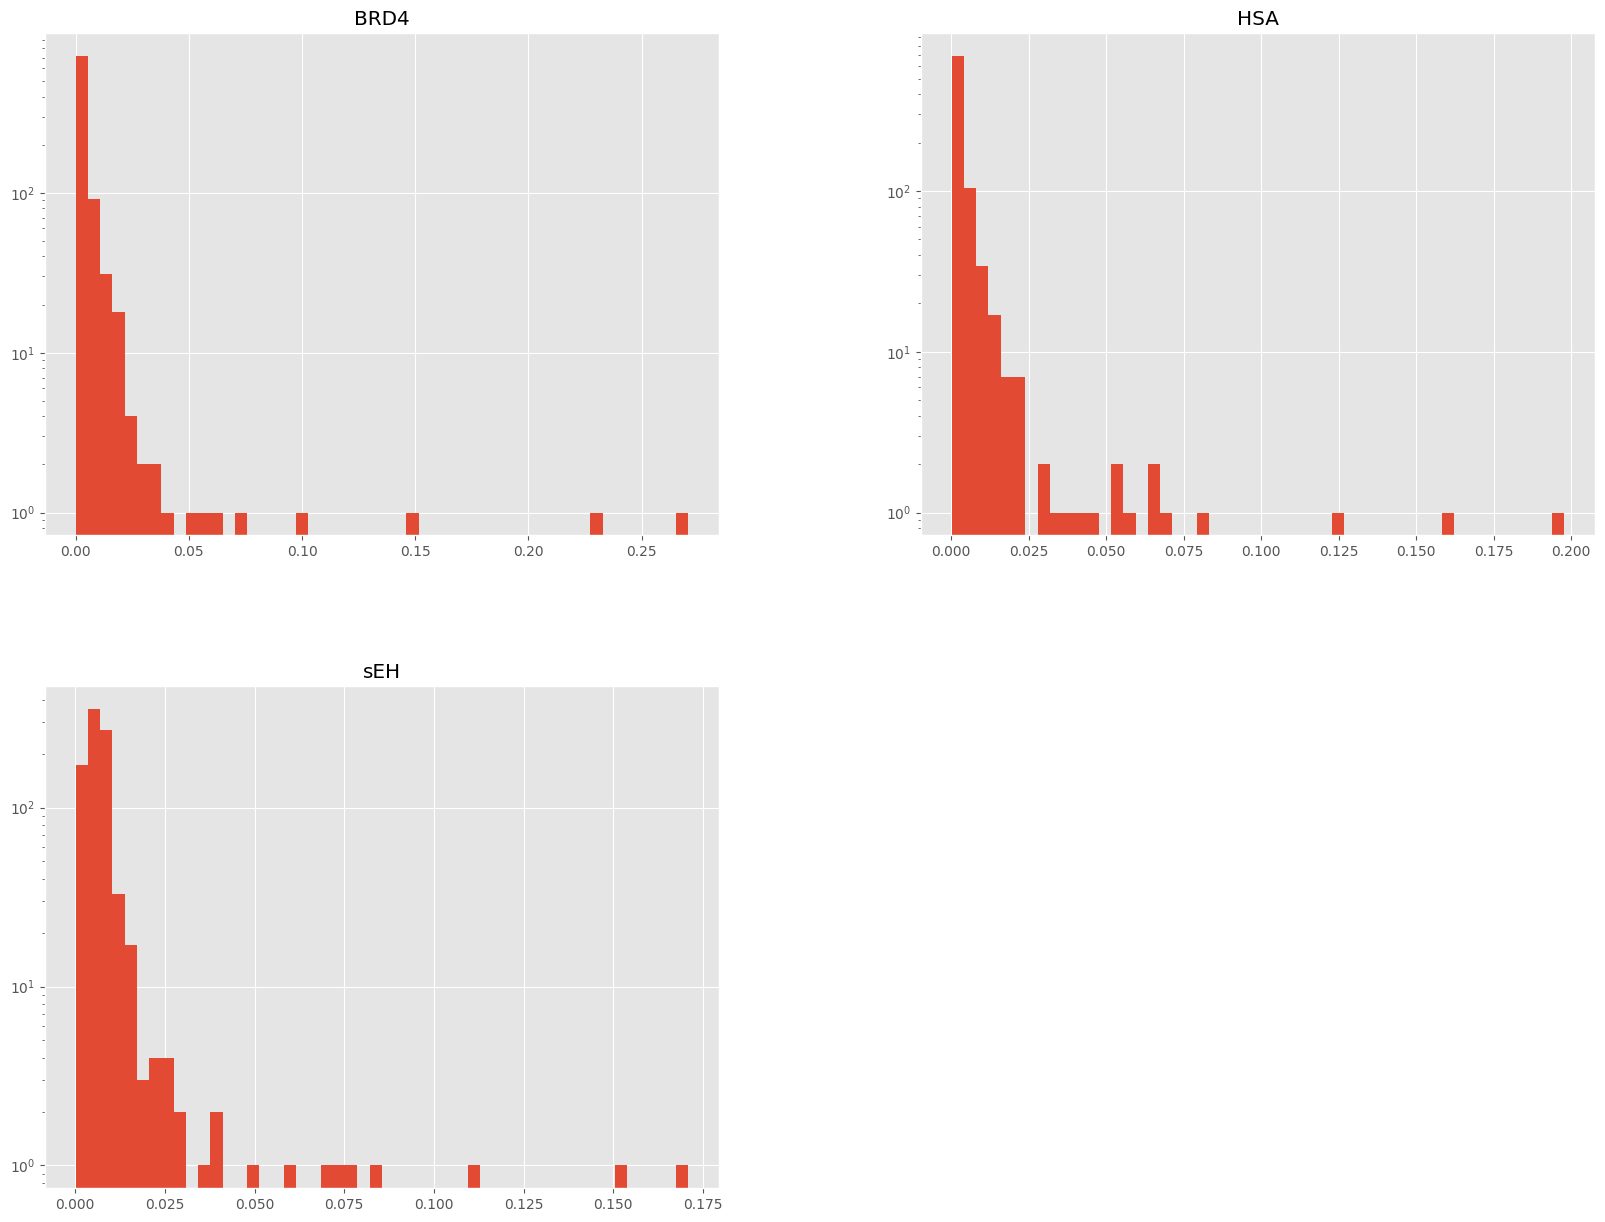

In [19]:
bb23_df.to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

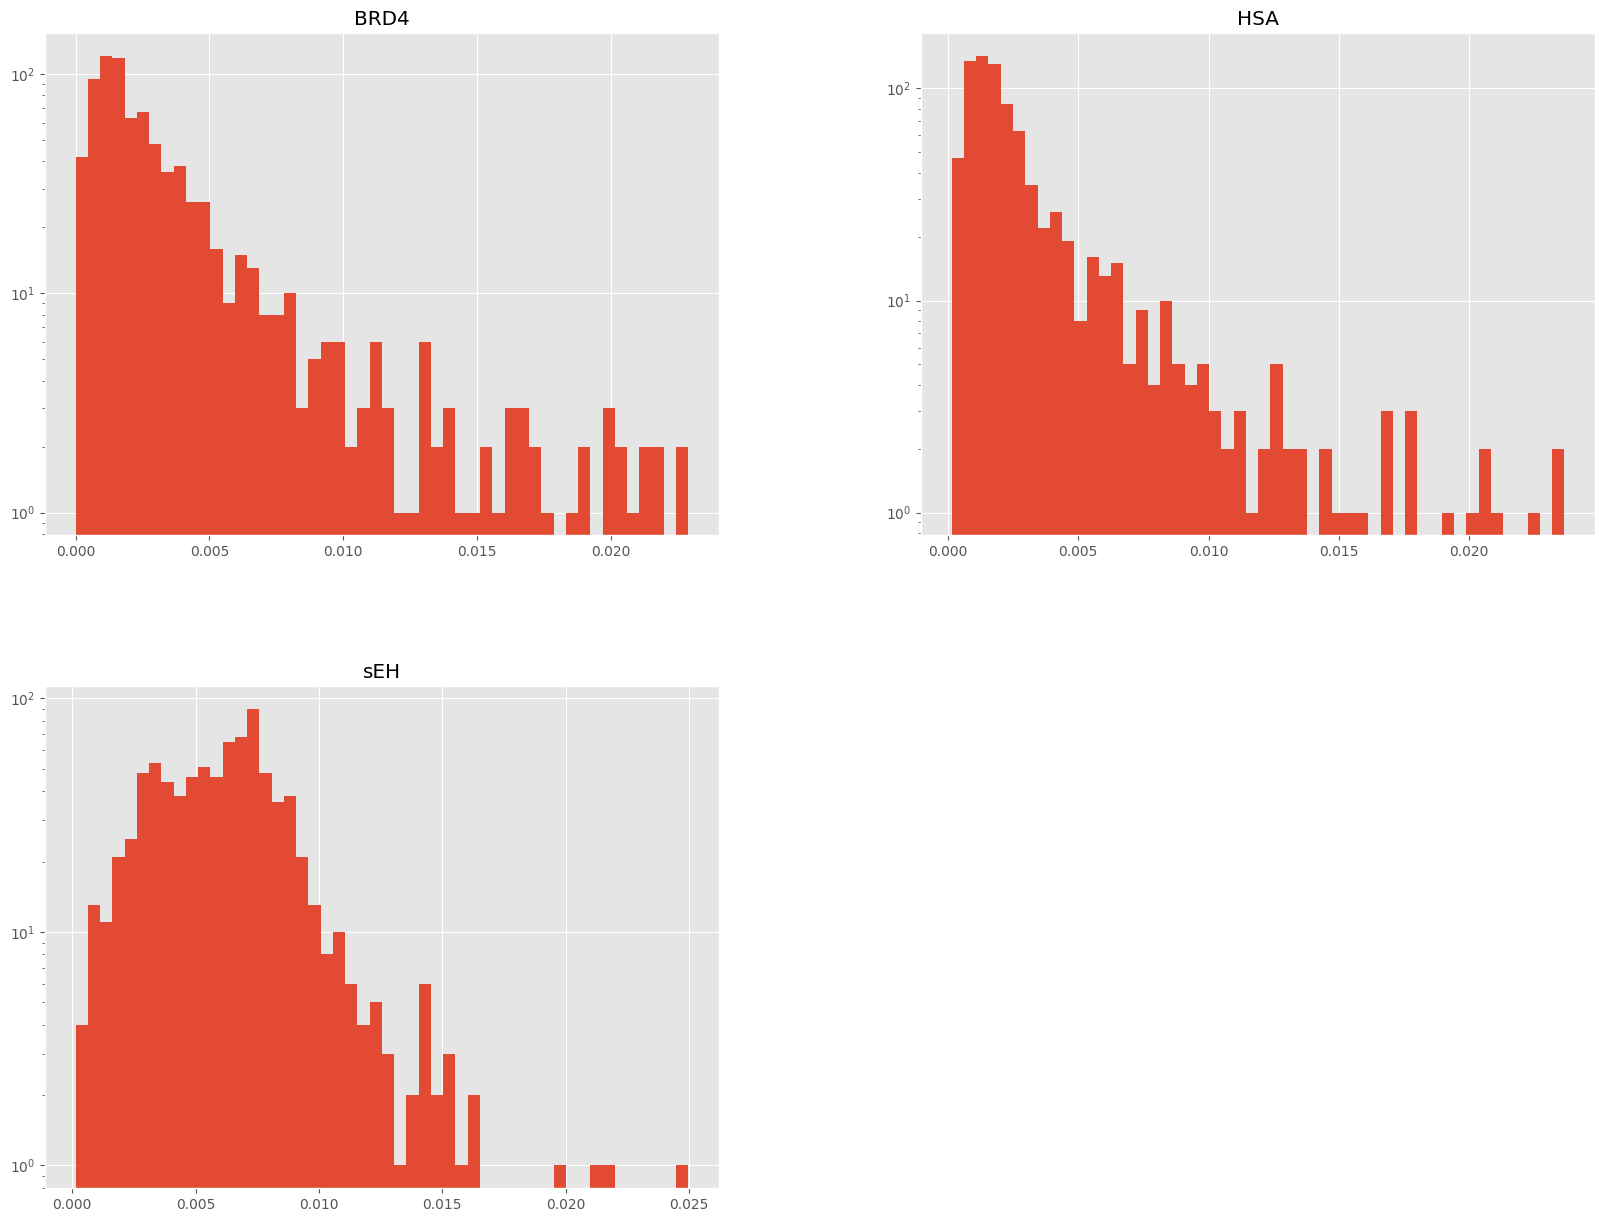

In [20]:
bb23_df.filter(pl.max_horizontal(PROTEINS) < 0.025).to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

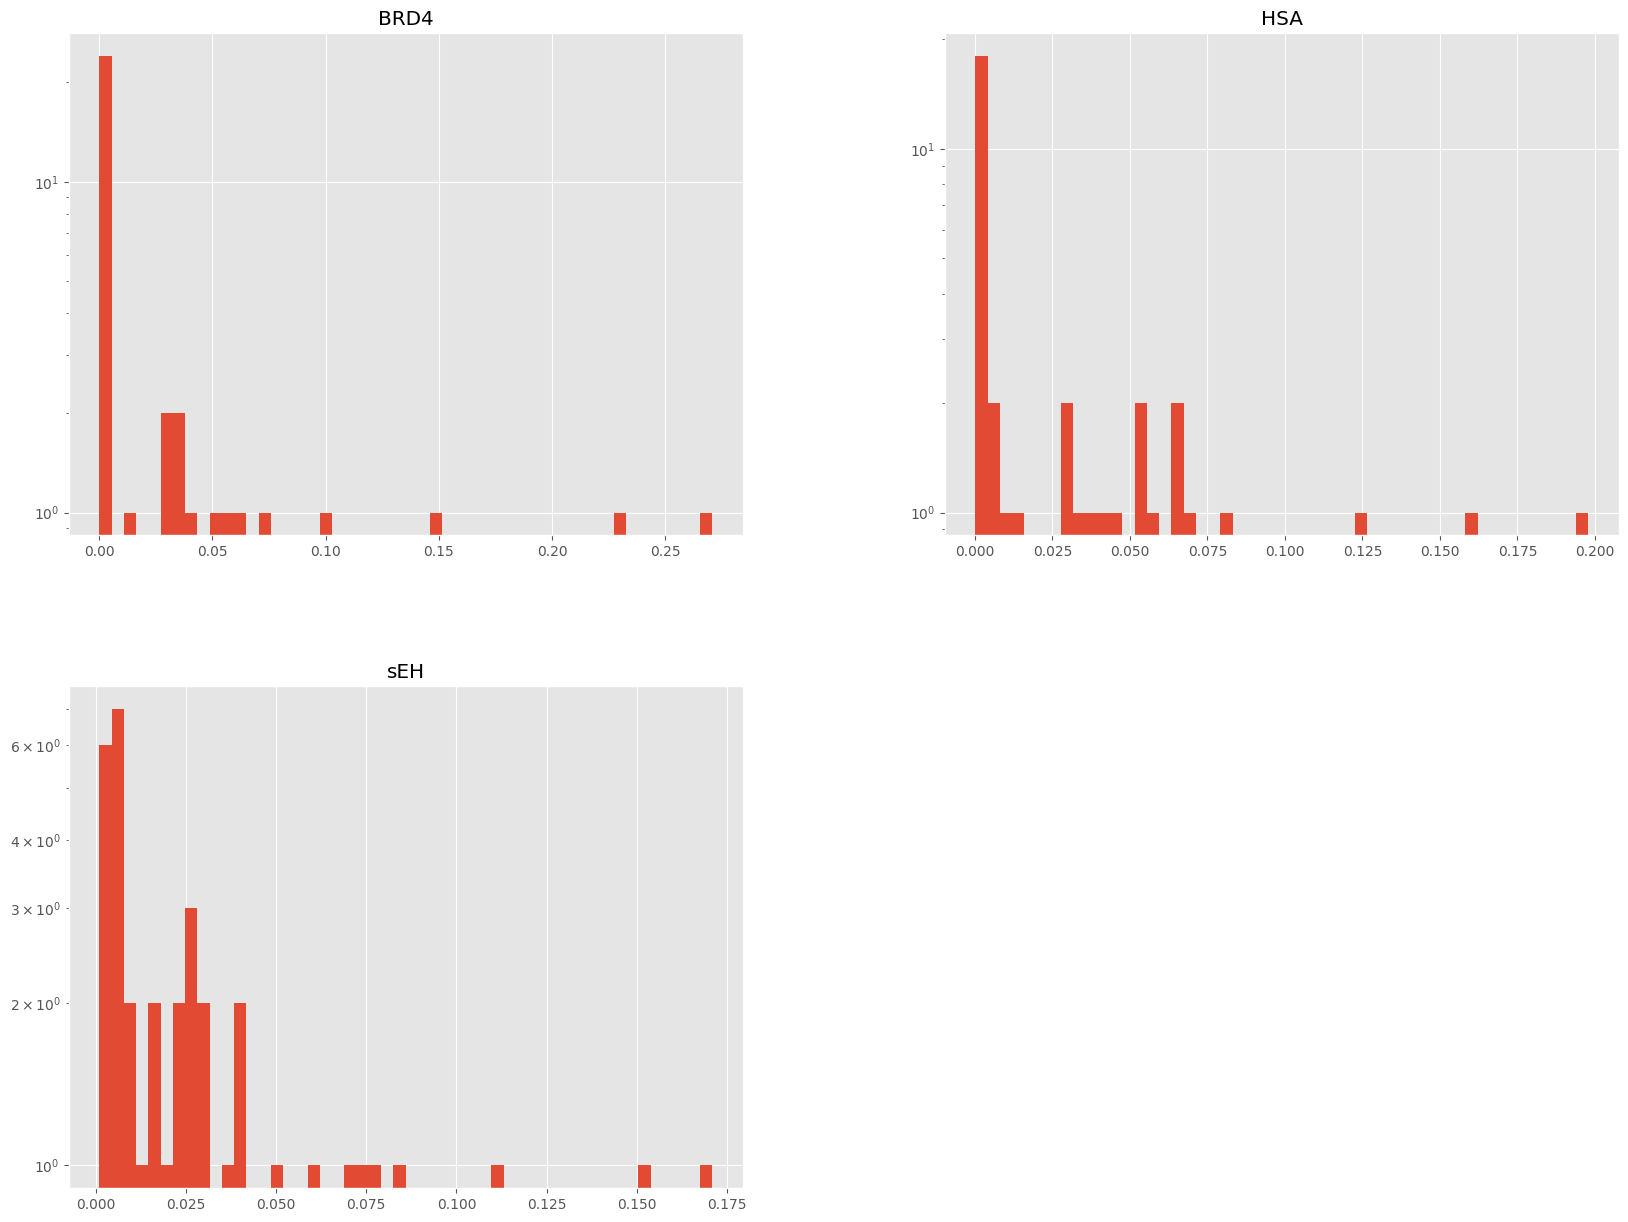

In [21]:
bb23_df.filter(pl.max_horizontal(PROTEINS) > 0.025).to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

In [22]:
bb1_df

bb1,BRD4,HSA,sEH
u16,f64,f64,f64
7,0.000055,0.000099,0.000003
14,0.01517,0.007672,0.006345
21,0.000072,0.001517,0.001145
36,0.000179,0.00044,0.000058
51,0.001432,0.004146,0.001355
…,…,…,…
2058,0.006873,0.001821,0.00162
2059,0.010803,0.00389,0.002753
2061,0.000747,0.001648,0.000557


In [23]:
271 / 16, 691 / 19

(16.9375, 36.36842105263158)

  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 49 / 126: invgauss
 50 / 126: geninvgauss
 51 / 1

<Figure size 1200x800 with 0 Axes>

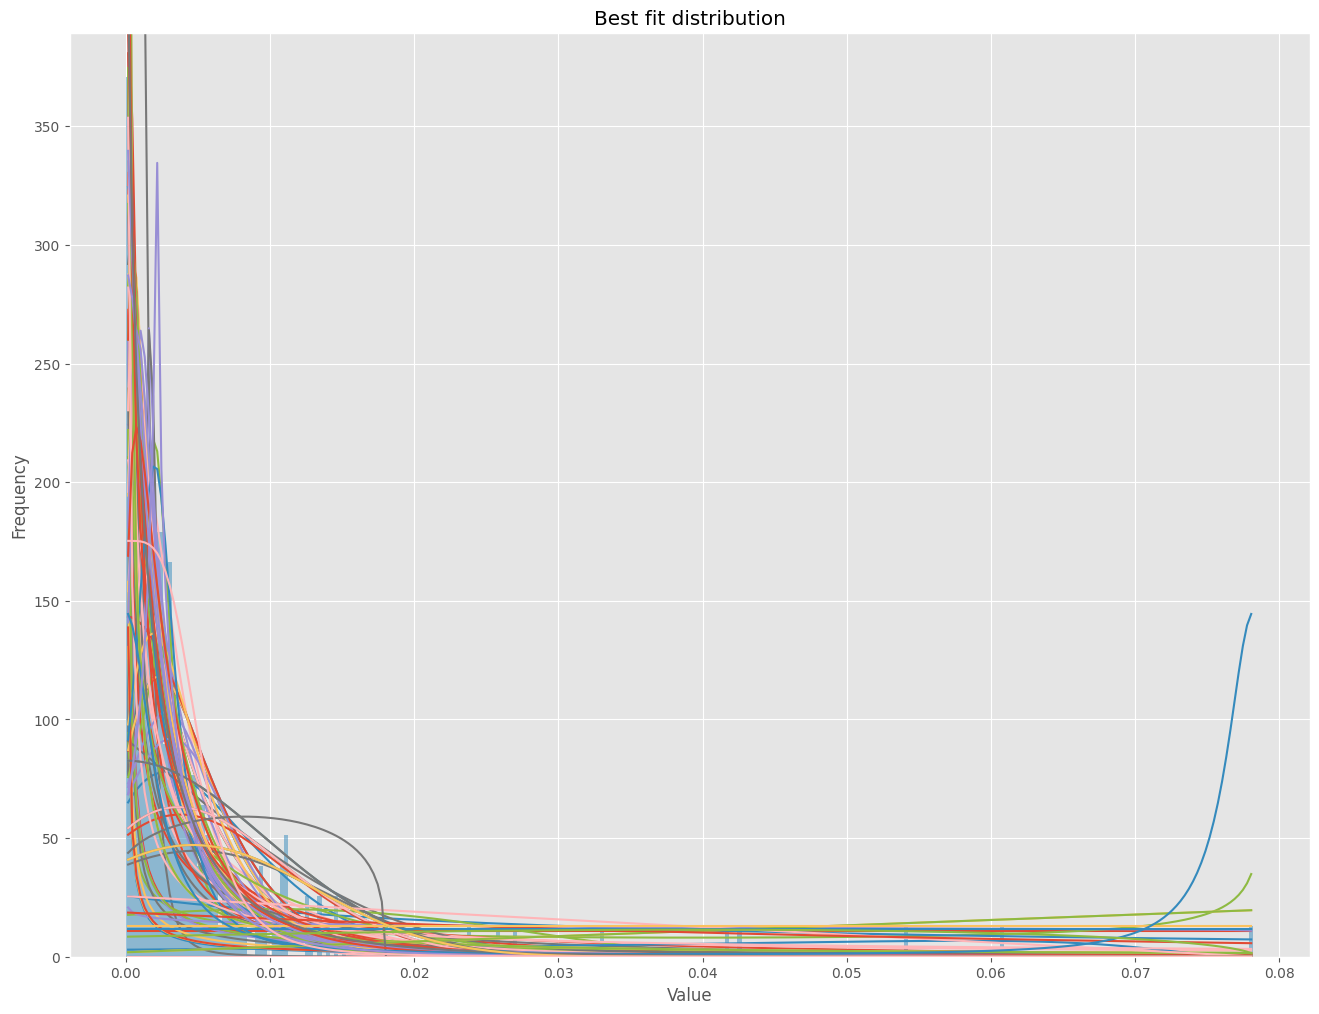

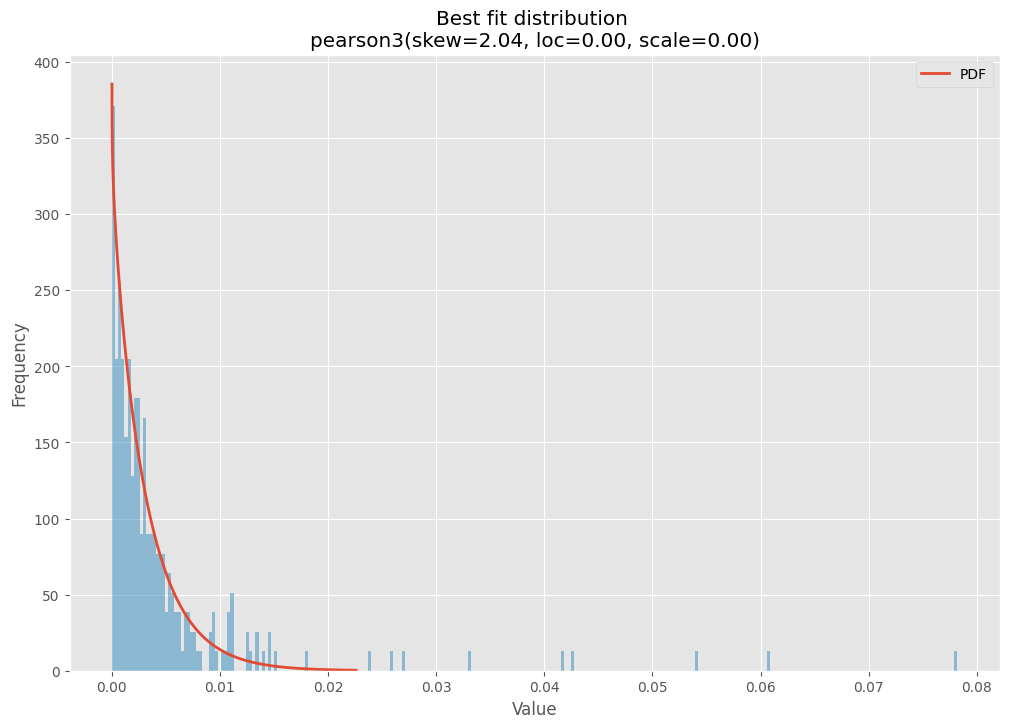

BRD4 3.841121133227885e-05 0.015001337333688827
  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 4

<Figure size 1200x800 with 0 Axes>

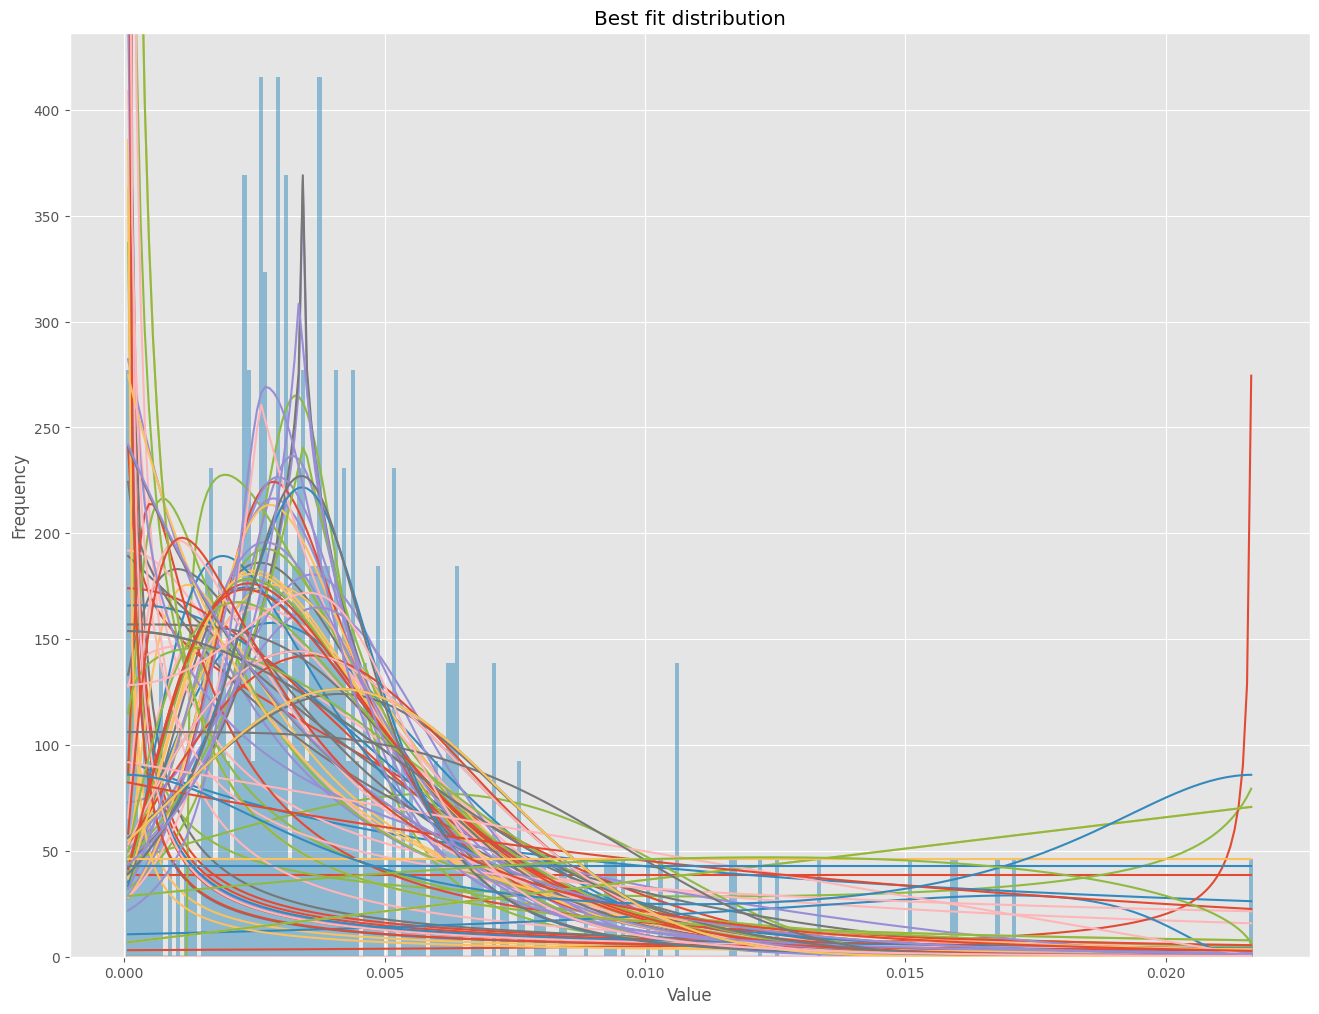

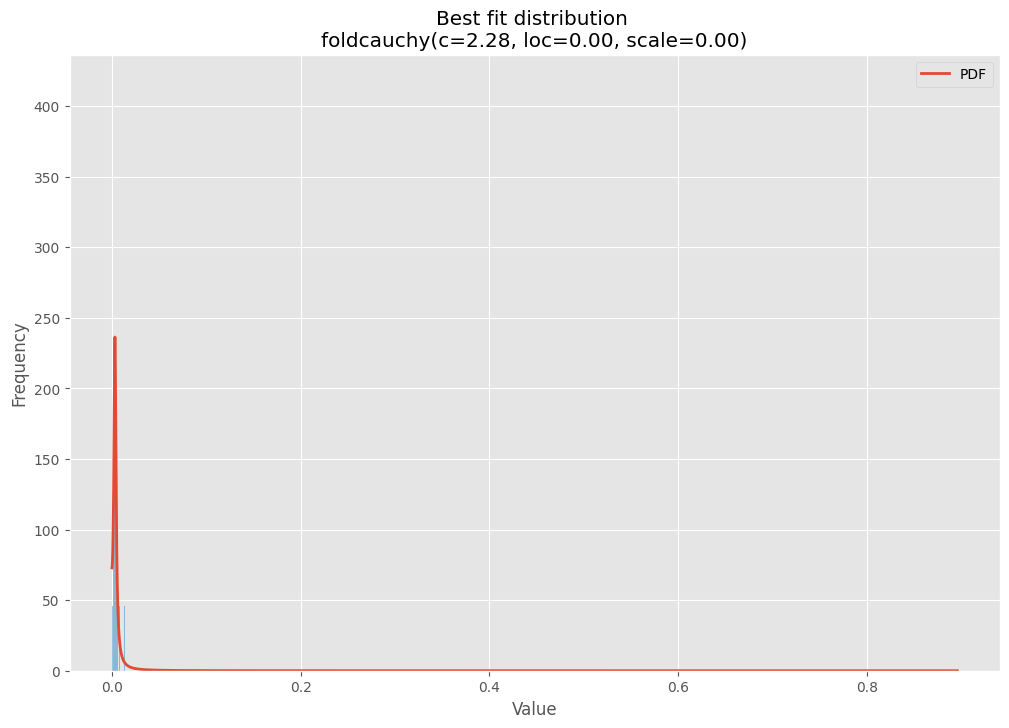

HSA 0.0001700221661855917 0.08971787237427867
  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 49 

<Figure size 1200x800 with 0 Axes>

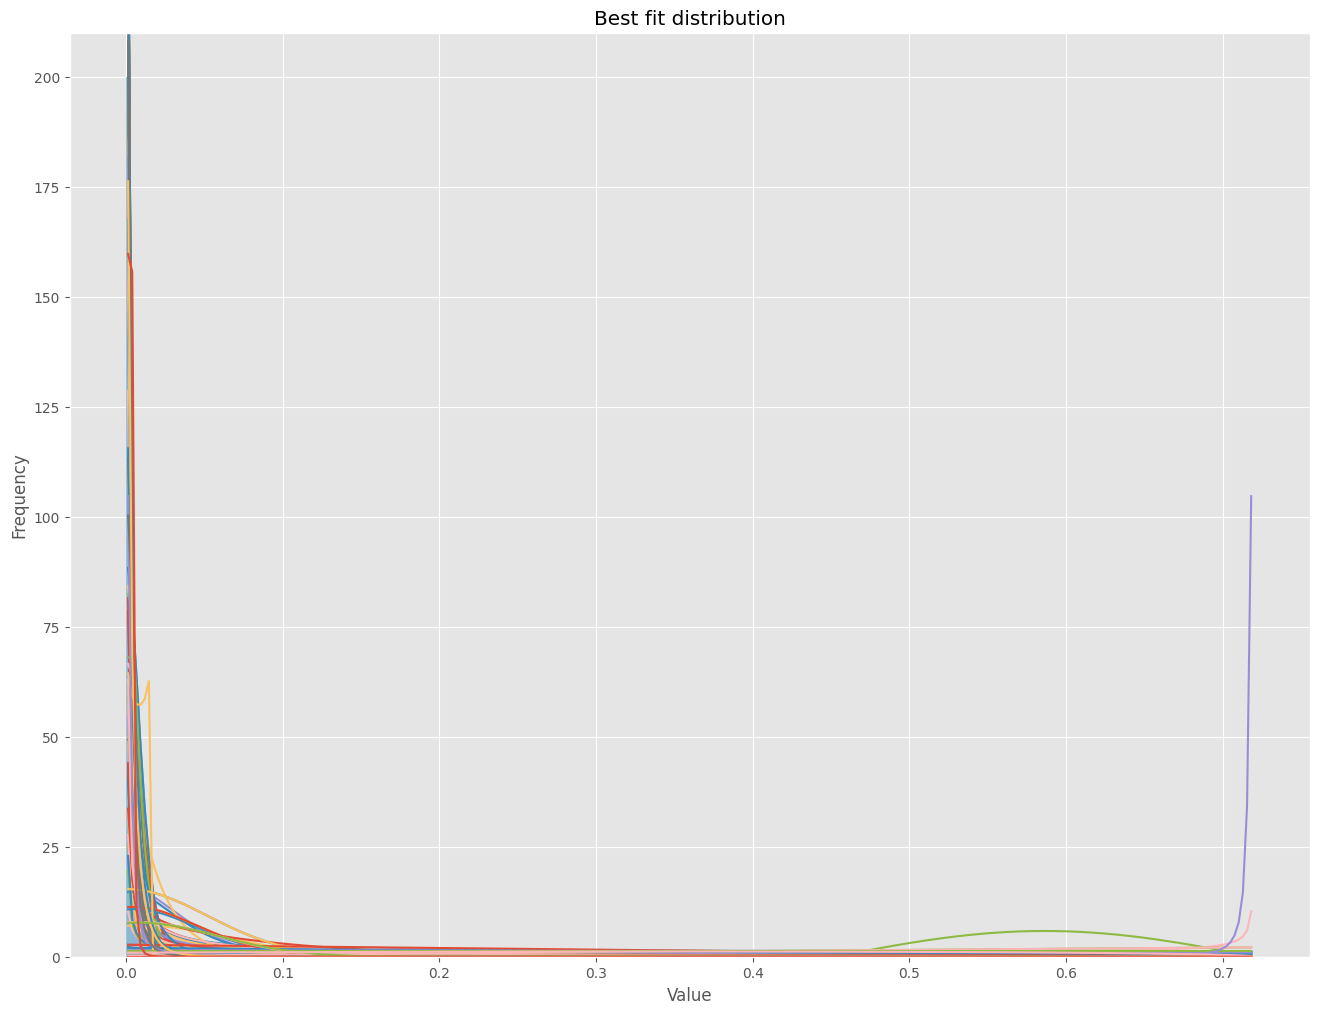

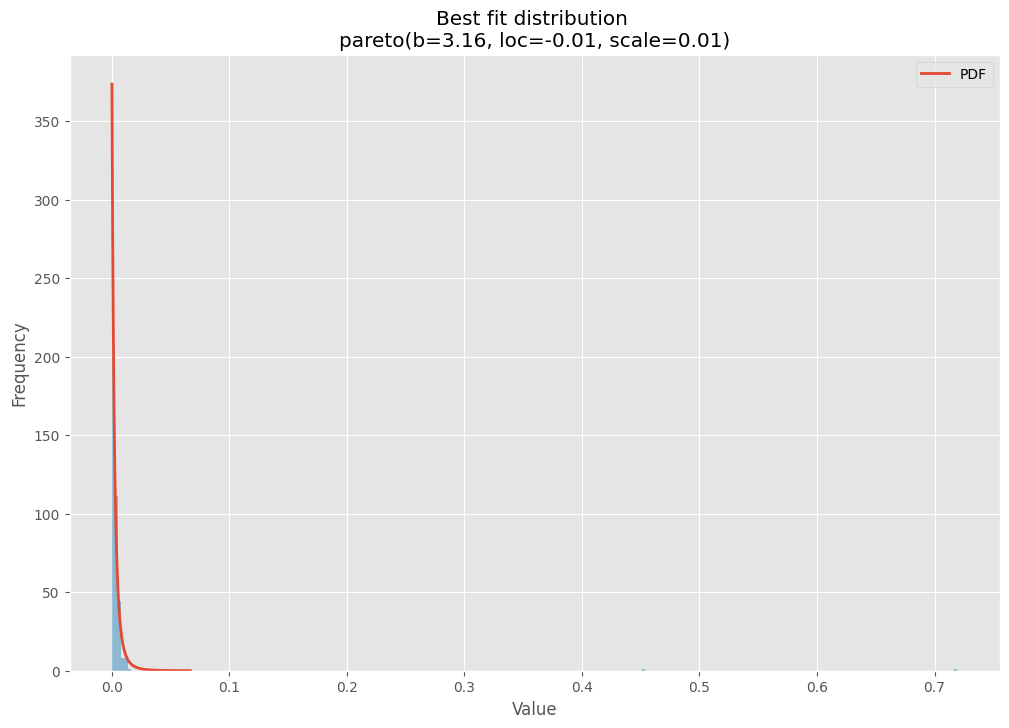

sEH 2.9653333372214527e-05 0.027838808084161275


{'BRD4': 0.015001337333688827,
 'HSA': 0.08971787237427867,
 'sEH': 0.027838808084161275}

In [156]:
df = bb1_df
START = 0.01
END = 0.99

cutoff = {}
for protein in PROTEINS:
    all_dists, best_dist = fit_dist(df[protein], bins = len(df))
    dist, params, sse = best_dist
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    # Get sane start and end points of distribution
    start = dist.ppf(START, *arg, loc=loc, scale=scale) if arg else dist.ppf(START, loc=loc, scale=scale)
    end = dist.ppf(END, *arg, loc=loc, scale=scale) if arg else dist.ppf(END, loc=loc, scale=scale)
    print(protein, start, end)
    cutoff[protein] = end
cutoff

In [158]:
cutoff

{'BRD4': 0.015001337333688827,
 'HSA': 0.08971787237427867,
 'sEH': 0.027838808084161275}

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

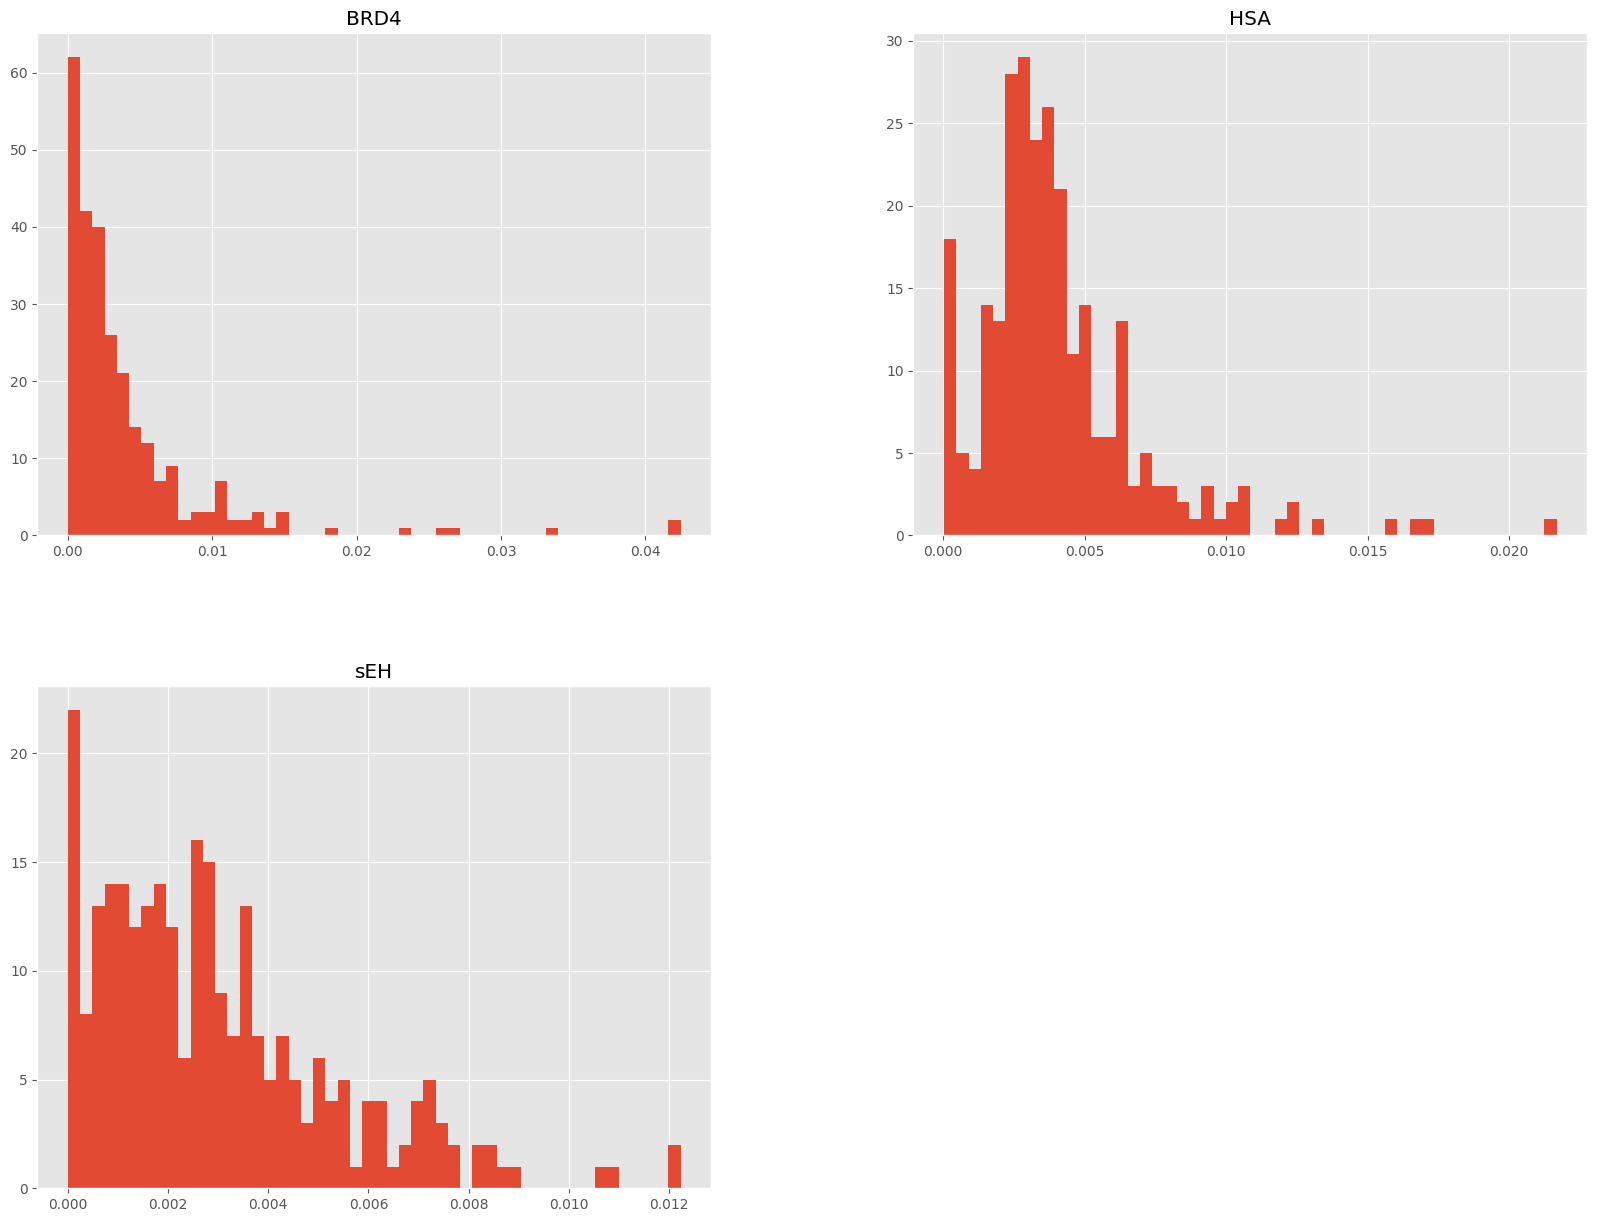

In [128]:
bb1_df.filter(pl.max_horizontal(PROTEINS) < 0.05).to_pandas()[PROTEINS].hist(bins = 50, log = False, figsize = (20, 15))

In [24]:
# cutoff = bb1_df.quantile(0.96)
# cutoff

q1 = bb1_df.quantile(0.25)
q3 = bb1_df.quantile(0.75)
iqr = q3 - q1
cutoff = q3 + 2.65 * iqr
cutoff

bb1,BRD4,HSA,sEH
f64,f64,f64,f64
4363.4,0.014743,0.012371,0.012501


In [25]:
select_bb1s = []
for protein in ['BRD4', 'HSA', 'sEH']:
    print(protein)
    tmp = bb1_df.filter(pl.col(protein) > cutoff[0, protein]).select('bb1', protein).sort(protein)
    select_bb1s.extend(tmp['bb1'].to_list())
    display(tmp)
    print('---------------\n\n')
select_bb1s = sorted(list(set(select_bb1s)))
print(len(select_bb1s))
select_bb1s

BRD4


bb1,BRD4
u16,f64
14,0.01517
742,0.017944
1088,0.023681
582,0.025821
1314,0.026934
…,…
928,0.041714
1126,0.042435
104,0.054174


---------------


HSA


bb1,HSA
u16,f64
364,0.012502
1126,0.013349
104,0.015099
589,0.01589
1779,0.015974
509,0.016754
928,0.017084
1893,0.021685


---------------


sEH


bb1,sEH
u16,f64
1779,0.01287
104,0.014567
558,0.45318
1945,0.719465


---------------


17


[14,
 104,
 346,
 364,
 509,
 558,
 582,
 589,
 742,
 866,
 928,
 1088,
 1126,
 1314,
 1779,
 1893,
 1945]

  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 49 / 126: invgauss
 50 / 126: geninvgauss
 51 / 1

<Figure size 1200x800 with 0 Axes>

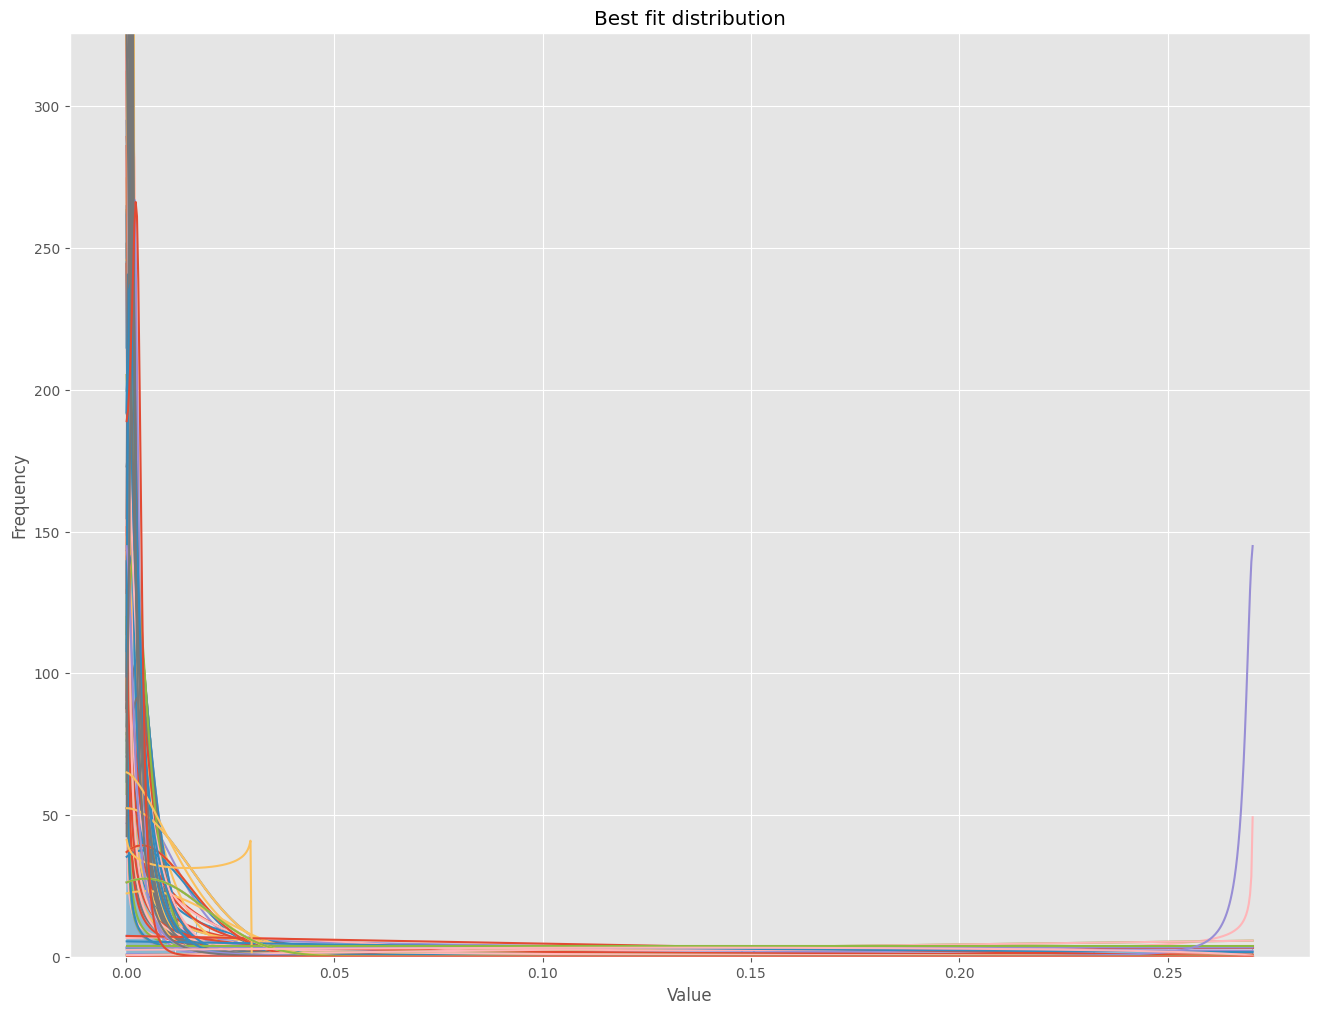

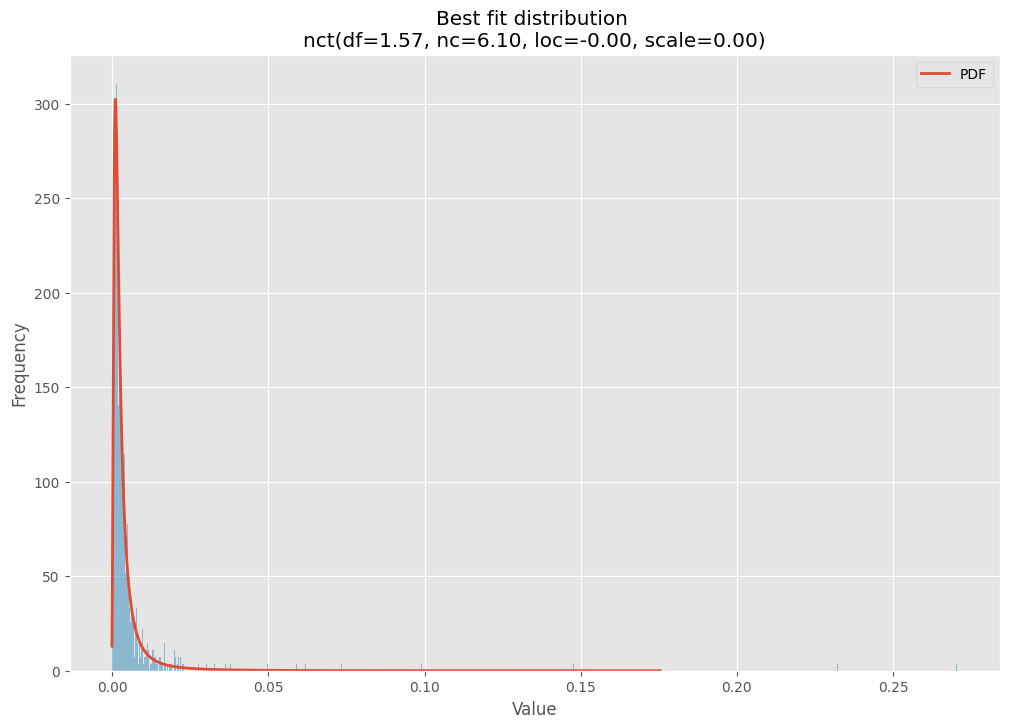

BRD4 0.00014170490751814558 0.03988024810393941
  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 4

<Figure size 1200x800 with 0 Axes>

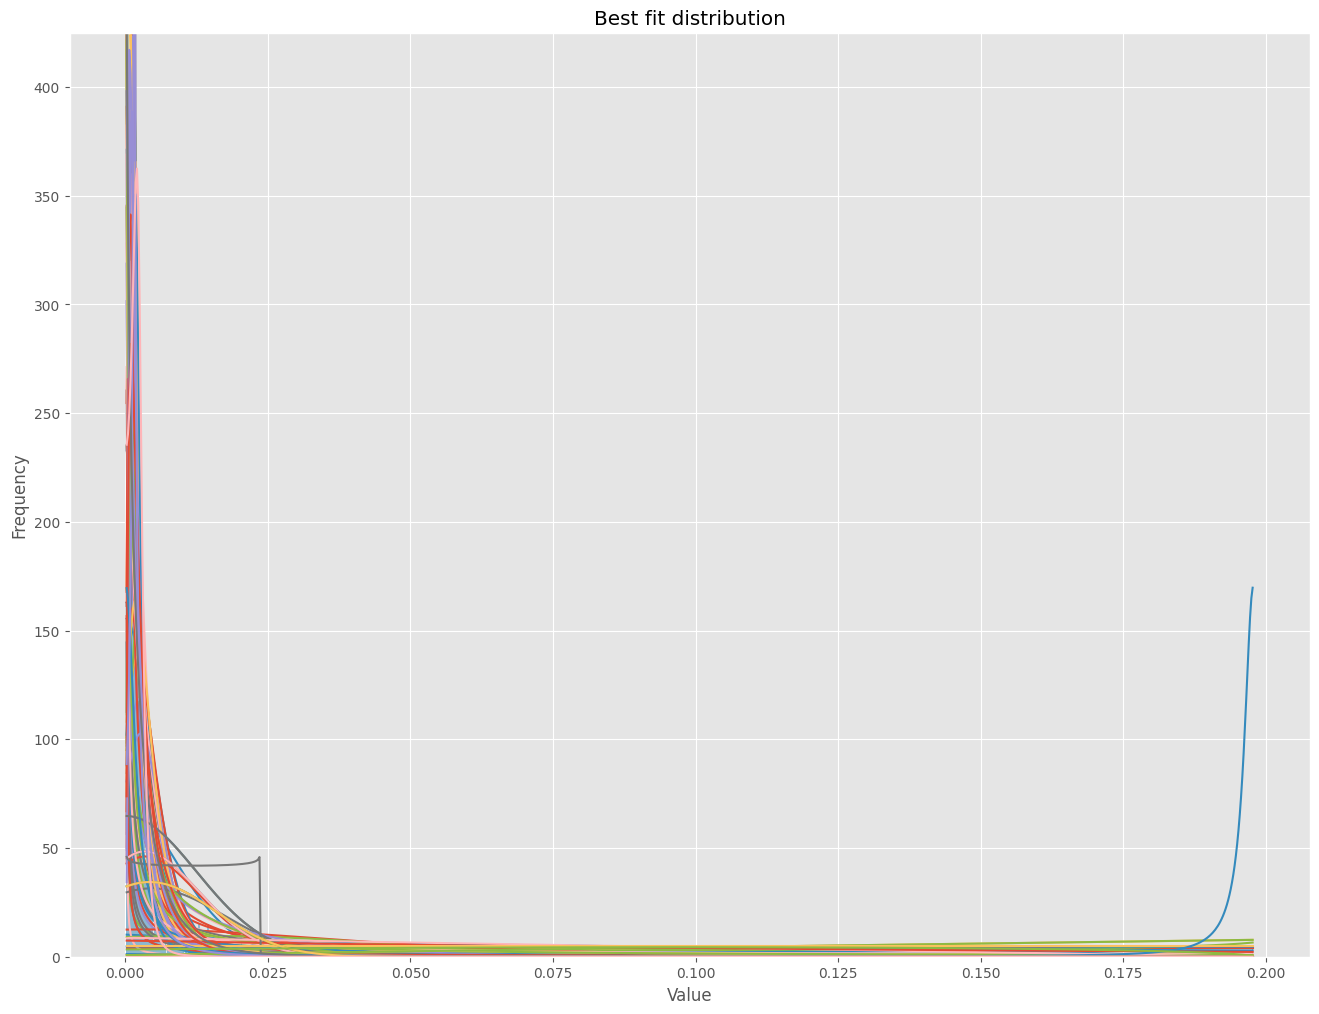

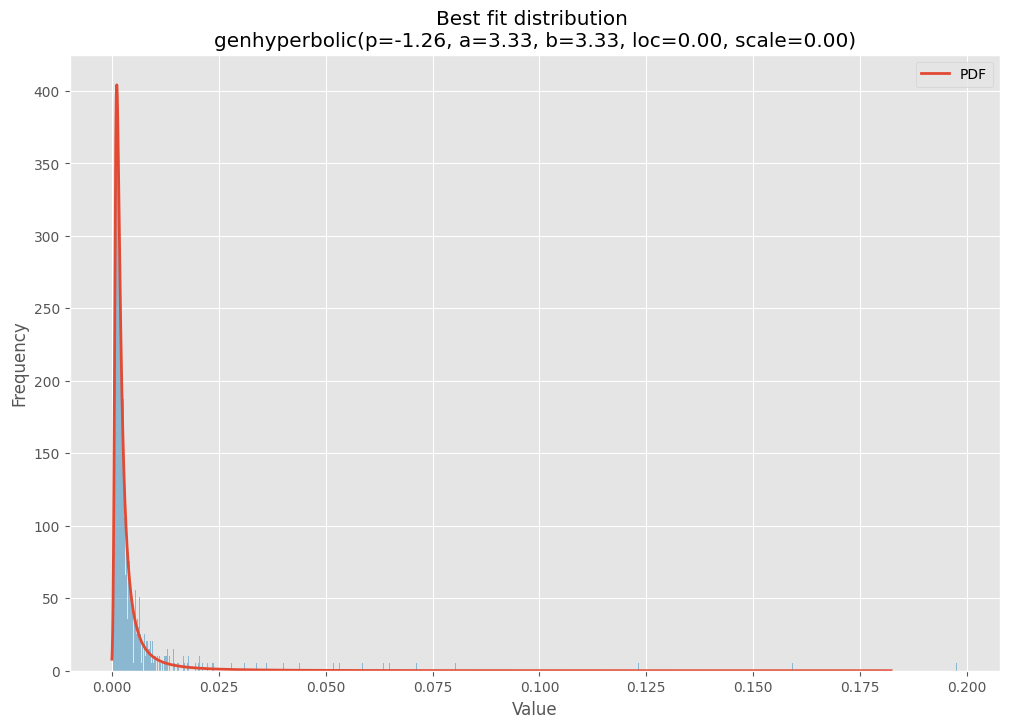

HSA 0.00030081855880911325 0.041435720796056605
  1 / 126: ksone
  2 / 126: kstwo
  3 / 126: kstwobign
  4 / 126: norm
  5 / 126: alpha
  6 / 126: anglit
  7 / 126: arcsine
  8 / 126: beta
  9 / 126: betaprime
 10 / 126: bradford
 11 / 126: burr
 12 / 126: burr12
 13 / 126: fisk
 14 / 126: cauchy
 15 / 126: chi
 16 / 126: chi2
 17 / 126: cosine
 18 / 126: dgamma
 19 / 126: dweibull
 20 / 126: expon
 21 / 126: exponnorm
 22 / 126: exponweib
 23 / 126: exponpow
 24 / 126: fatiguelife
 25 / 126: foldcauchy
 26 / 126: f
 27 / 126: foldnorm
 28 / 126: weibull_min
 29 / 126: truncweibull_min
 30 / 126: weibull_max
 31 / 126: genlogistic
 32 / 126: genpareto
 33 / 126: genexpon
 34 / 126: genextreme
 35 / 126: gamma
 36 / 126: erlang
 37 / 126: gengamma
 38 / 126: genhalflogistic
 39 / 126: genhyperbolic
 40 / 126: gompertz
 41 / 126: gumbel_r
 42 / 126: gumbel_l
 43 / 126: halfcauchy
 44 / 126: halflogistic
 45 / 126: halfnorm
 46 / 126: hypsecant
 47 / 126: gausshyper
 48 / 126: invgamma
 4

<Figure size 1200x800 with 0 Axes>

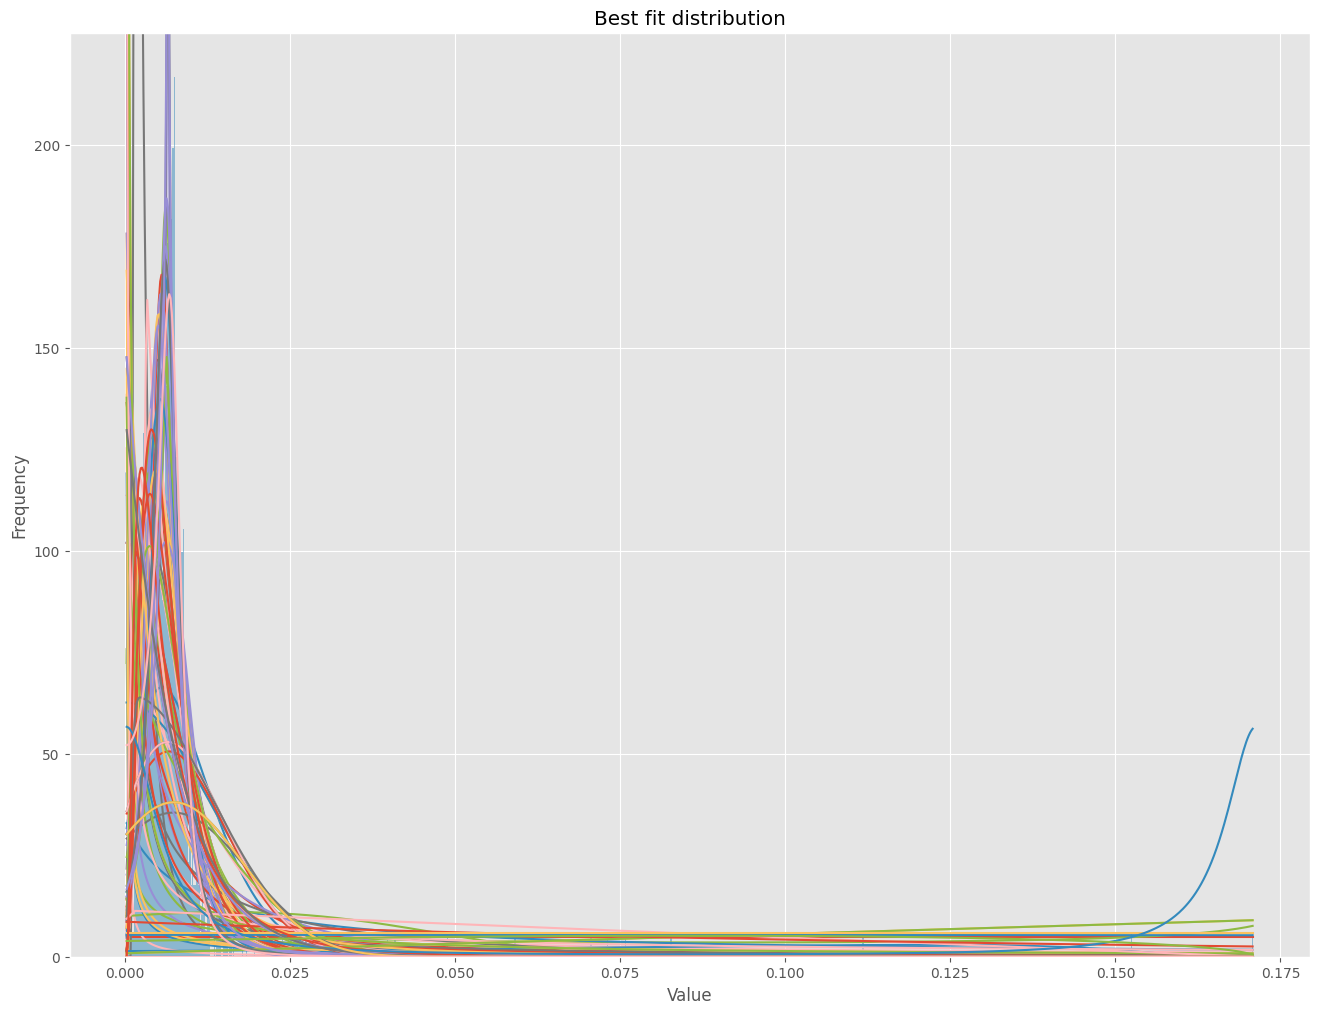

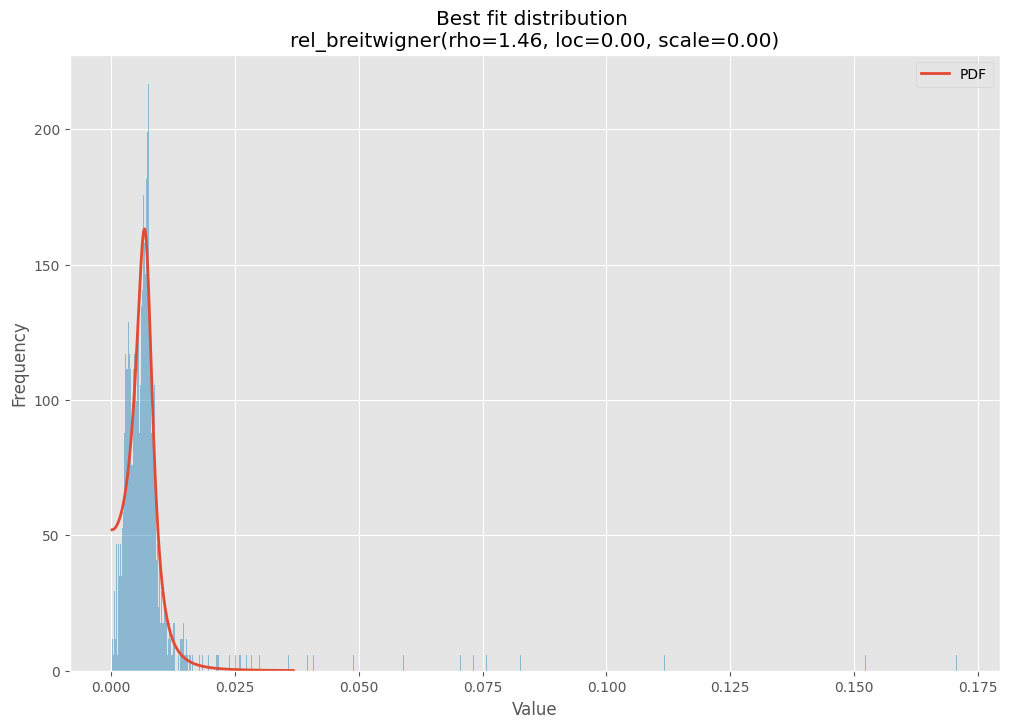

sEH 0.0003362462158464161 0.017925838626489728


{'BRD4': 0.03988024810393941,
 'HSA': 0.041435720796056605,
 'sEH': 0.017925838626489728}

In [26]:
df = bb23_df
START = 0.01
END = 0.99

cutoff = {}
for protein in PROTEINS:
    all_dists, best_dist = fit_dist(df[protein], bins = len(df))
    dist, params, sse = best_dist
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    # Get sane start and end points of distribution
    start = dist.ppf(START, *arg, loc=loc, scale=scale) if arg else dist.ppf(START, loc=loc, scale=scale)
    end = dist.ppf(END, *arg, loc=loc, scale=scale) if arg else dist.ppf(END, loc=loc, scale=scale)
    print(protein, start, end)
    cutoff[protein] = end
cutoff

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

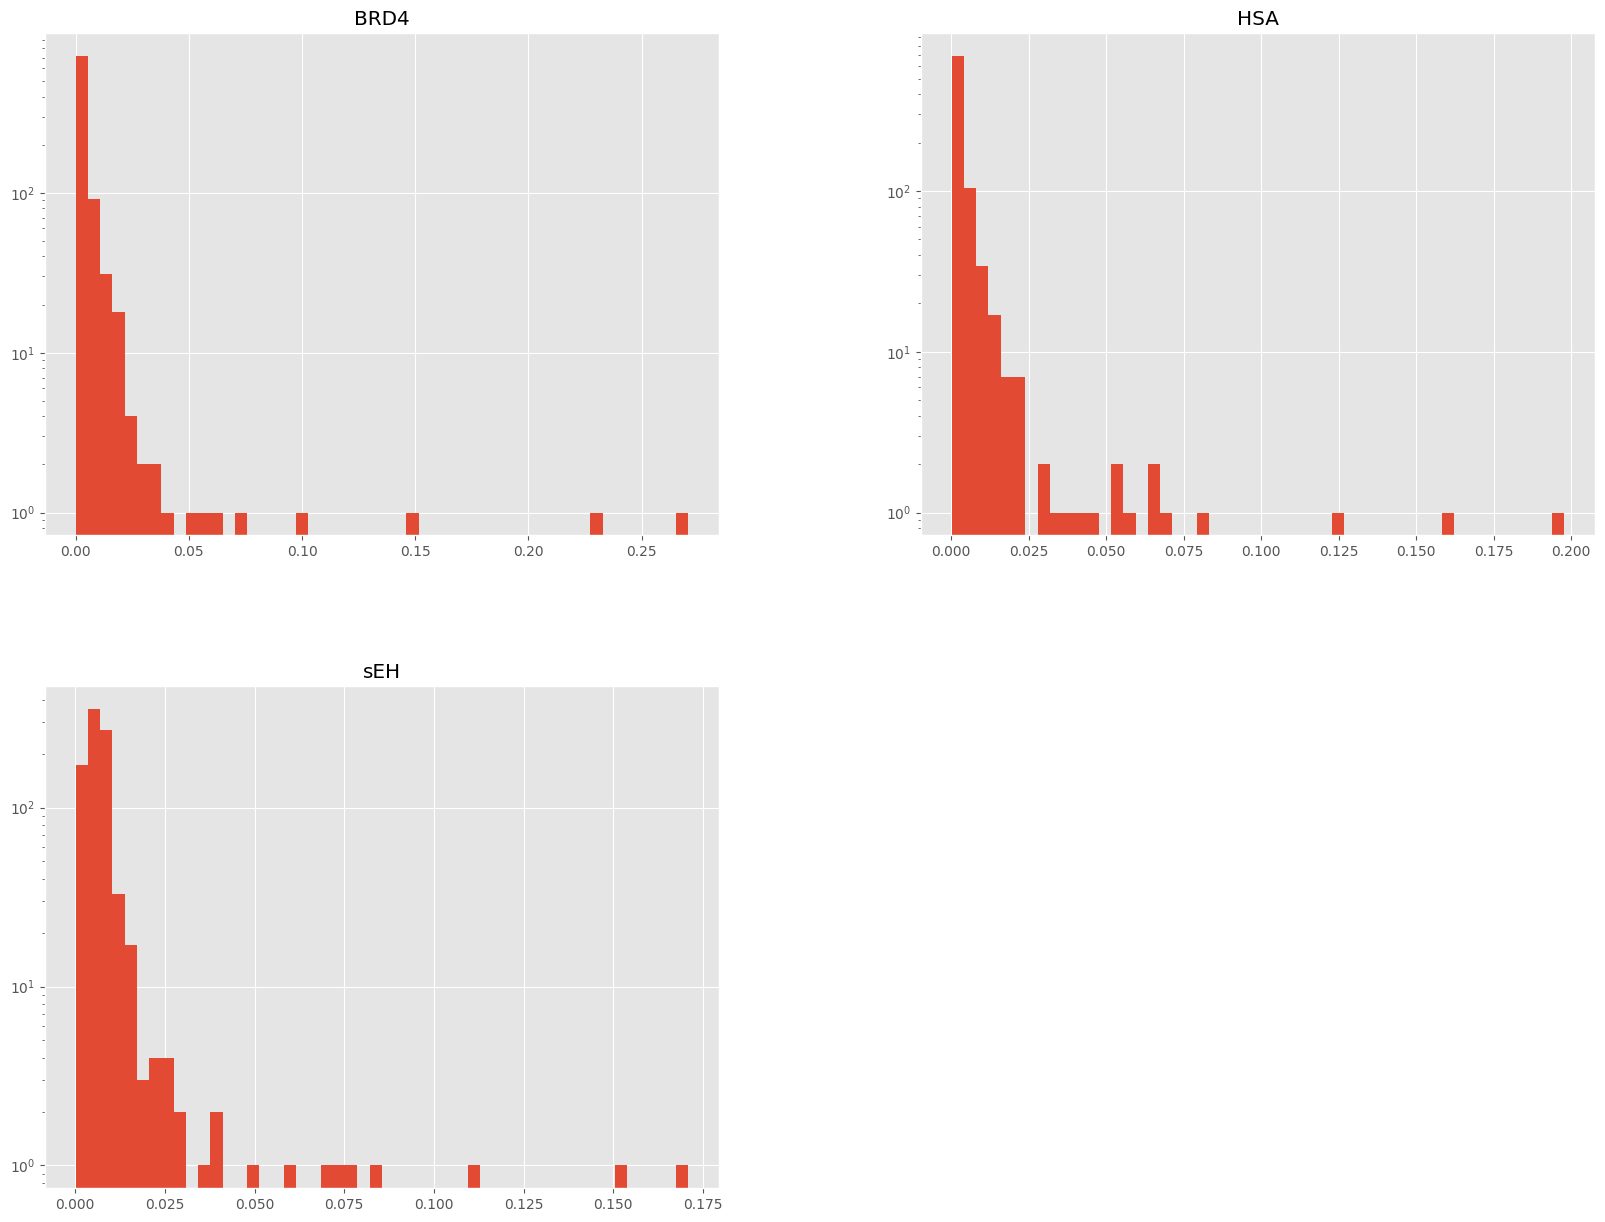

In [27]:
bb23_df.to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4'}>,
        <Axes: title={'center': 'HSA'}>],
       [<Axes: title={'center': 'sEH'}>, <Axes: >]], dtype=object)

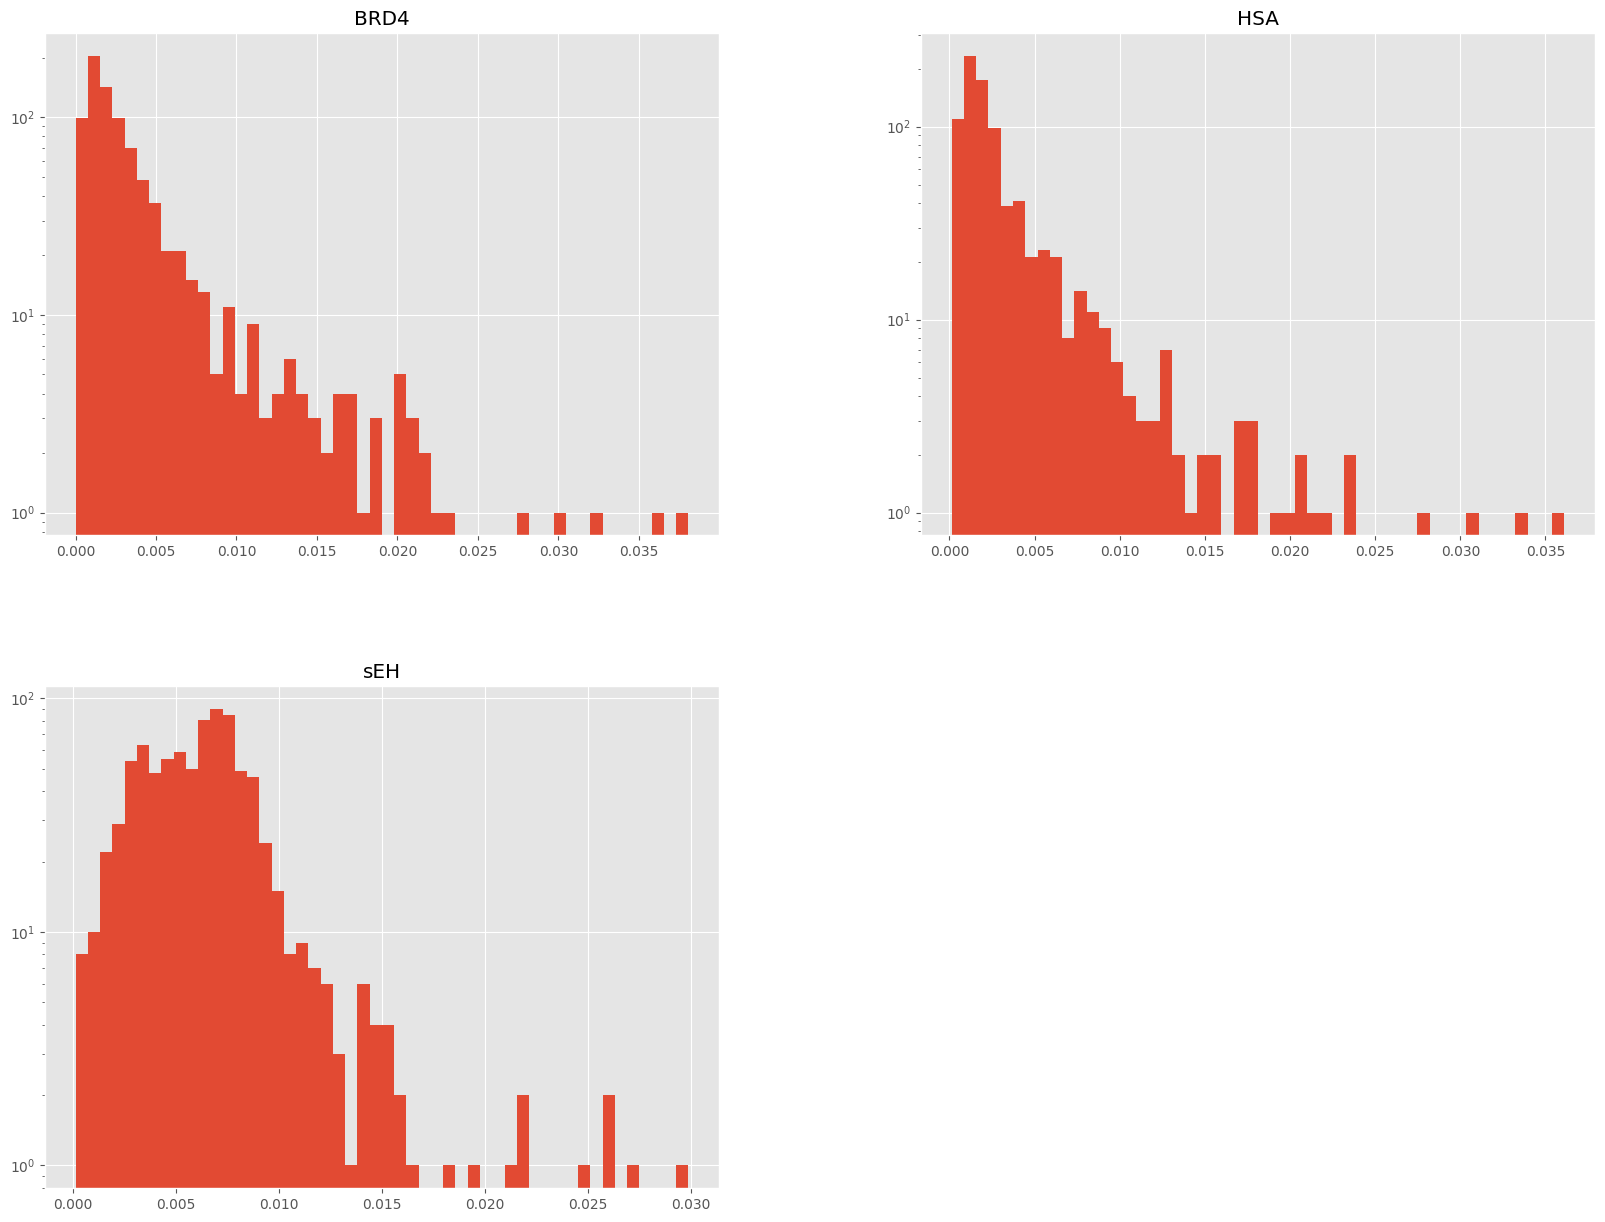

In [28]:
bb23_df.filter(pl.max_horizontal(PROTEINS) < 0.04).to_pandas()[PROTEINS].hist(bins = 50, log = True, figsize = (20, 15))

In [32]:
q1 = bb23_df.quantile(0.25)
q3 = bb23_df.quantile(0.75)
iqr = q3 - q1
cutoff = q3 + 8 * iqr


# cutoff = bb23_df.quantile(0.99) * 1.0

display(cutoff)


select_bb23s = []
for protein in ['BRD4', 'HSA', 'sEH']:
    print(protein)
    tmp = bb23_df.filter(pl.col(protein) > cutoff[0, protein]).select('bb23', protein).sort(protein)
    select_bb23s.extend(tmp['bb23'].to_list())
    display(tmp)
    print('---------------\n\n')
select_bb23s = sorted(list(set(select_bb23s)))
print(len(select_bb23s))
print(select_bb23s)

bb23,BRD4,HSA,sEH
f64,f64,f64,f64
9852.0,0.028565,0.021886,0.038144


BRD4


bb23,BRD4
u16,f64
1711,0.030127
1033,0.032612
809,0.036526
1414,0.038077
882,0.049785
…,…
2101,0.073677
1161,0.098847
2018,0.147727


---------------


HSA


bb23,HSA
u16,f64
1482,0.022355
1308,0.023642
1299,0.023666
1481,0.028037
399,0.030949
…,…
1275,0.071219
638,0.080342
43,0.123223


---------------


sEH


bb23,sEH
u16,f64
119,0.039701
518,0.040853
1158,0.048924
578,0.05906
1707,0.070618
…,…
1372,0.075803
1298,0.082597
1304,0.111853


---------------


36
[43, 119, 266, 399, 518, 578, 638, 809, 829, 882, 954, 1001, 1033, 1091, 1128, 1158, 1161, 1275, 1298, 1299, 1304, 1308, 1366, 1372, 1391, 1414, 1481, 1482, 1488, 1644, 1699, 1707, 1711, 2018, 2025, 2101]


In [33]:
print(select_bb1s)
print(select_bb23s)

[14, 104, 346, 364, 509, 558, 582, 589, 742, 866, 928, 1088, 1126, 1314, 1779, 1893, 1945]
[43, 119, 266, 399, 518, 578, 638, 809, 829, 882, 954, 1001, 1033, 1091, 1128, 1158, 1161, 1275, 1298, 1299, 1304, 1308, 1366, 1372, 1391, 1414, 1481, 1482, 1488, 1644, 1699, 1707, 1711, 2018, 2025, 2101]


In [34]:
selected_nonshare_df = train_df.filter(pl.col('bb1').is_in(select_bb1s) & pl.col('bb2').is_in(select_bb23s) & pl.col('bb3').is_in(select_bb23s))
selected_nonshare_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH
str,u16,u16,u16,u8,u8,u8
"""CC(=O)SCCNc1nc…",1314,954,954,0,0,0
"""CC(=O)SCCNc1nc…",1314,954,1711,0,0,0
"""COC(=O)c1cncc(…",1314,954,1158,0,0,0
"""COc1cncc(Nc2nc…",1314,954,1481,0,0,0
"""COc1cncc(Nc2nc…",1314,954,1001,0,0,0
…,…,…,…,…,…,…
"""O=C1OCc2cc(Nc3…",1126,1699,1033,0,0,0
"""O=C(N[Dy])[C@@…",1126,1699,1128,0,1,0
"""O=C(N[Dy])[C@@…",1126,1699,1488,0,0,0


In [35]:
selected_nonshare_df.select(pl.mean(PROTEINS))

BRD4,HSA,sEH
f64,f64,f64
0.161302,0.191422,0.208416


In [36]:
(0.161302+0.191422+0.208416) / 3

0.18704666666666667

In [20]:
# train_df = train_df.join(
#     bb1_df,
#     how = 'left',
#     left_on = 'bb1',
#     right_on = 'bb1',
#     suffix = '_bb1_pos_pct',
#     validate = 'm:1',
# )
# train_df = train_df.join(
#     bb2_df,
#     how = 'left',
#     left_on = 'bb2',
#     right_on = 'bb2',
#     suffix = '_bb2_pos_pct',
#     validate = 'm:1',
# )
# train_df = train_df.join(
#     bb3_df,
#     how = 'left',
#     left_on = 'bb3',
#     right_on = 'bb3',
#     suffix = '_bb3_pos_pct',
#     validate = 'm:1',
# )
# train_df = train_df.join(
#     bb23_df,
#     how = 'left',
#     left_on = 'bb2',
#     right_on = 'bb23',
#     suffix = '_bb23_2_pos_pct',
#     validate = 'm:1',
# )
# train_df = train_df.join(
#     bb23_df,
#     how = 'left',
#     left_on = 'bb3',
#     right_on = 'bb23',
#     suffix = '_bb23_3_pos_pct',
#     validate = 'm:1',
# )
# train_df

In [21]:
train_df = train_df.join(
    bb1_df,
    how = 'left',
    left_on = 'bb1',
    right_on = 'bb1',
    suffix = '_bb1_pos_pct',
    validate = 'm:1',
)
# train_df = train_df.join(
#     bb2_df,
#     how = 'left',
#     left_on = 'bb2',
#     right_on = 'bb2',
#     suffix = '_bb2_pos_pct',
#     validate = 'm:1',
# )
# train_df = train_df.join(
#     bb3_df,
#     how = 'left',
#     left_on = 'bb3',
#     right_on = 'bb3',
#     suffix = '_bb3_pos_pct',
#     validate = 'm:1',
# )
train_df = train_df.join(
    bb23_df,
    how = 'left',
    left_on = 'bb2',
    right_on = 'bb23',
    suffix = '_bb2_pos_pct',
    validate = 'm:1',
)
train_df = train_df.join(
    bb23_df,
    how = 'left',
    left_on = 'bb3',
    right_on = 'bb23',
    suffix = '_bb3_pos_pct',
    validate = 'm:1',
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,BRD4_bb1_pos_pct,HSA_bb1_pos_pct,sEH_bb1_pos_pct,BRD4_bb2_pos_pct,HSA_bb2_pos_pct,sEH_bb2_pos_pct,BRD4_bb3_pos_pct,HSA_bb3_pos_pct,sEH_bb3_pos_pct
str,u16,u16,u16,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.01377,0.008858,0.008847
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.016879,0.005454,0.009453
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000455,0.00136,0.007313
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000989,0.000208,0.001953
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.002017,0.001066,0.003328
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000285,0.000527,0.00216
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.002822,0.004168,0.004325
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000526,0.033762,0.021758


In [3]:
import numpy as np
import pandas as pd
from typing import Optional, Union
from sklearn.metrics import average_precision_score
import logging
import itertools
from tqdm import tqdm

logger = logging.getLogger(__name__)


def compute_metrics(df, stage='test'):
    df = df.reset_index(drop=True)
    all_metrics = {}
    # COLS = ['BRD4', 'HSA', 'sEH']
    SUBSETS = ['share']
    PROTEINS = ['BRD4', 'HSA', 'sEH']

    logger.info('Computing metrics..')
    for subset in SUBSETS:
        if subset == 'nonshare':
            subset_df = df[df.subset == 0].reset_index(drop=True)
        elif subset == 'share':
            subset_df = df[df.subset != 0].reset_index(drop=True)
        elif subset == 'share1':
            subset_df = df[df.subset == 1].reset_index(drop=True)
        elif subset == 'share2':
            subset_df = df[df.subset.isin([2, 3])].reset_index(drop=True)
        else:
            raise AssertionError

        for protein in PROTEINS:
            filter_name = f'{subset}_{protein}'
            logger.info('%s', filter_name)
            # compute metrics
            metrics = {}
            if len(subset_df
                   ) == 0 or f'target_{protein}' not in subset_df.columns:
                logger.warning(
                    '[METRICS] Skip subset=%s protein=%s and set metric value to None..',
                    subset, protein)
                metrics['AP'] = None
            else:
                preds = subset_df[f'pred_{protein}']
                targets = subset_df[f'target_{protein}']
                metrics['AP'] = average_precision_score(targets,
                                                        preds,
                                                        pos_label=1,
                                                        average='micro')

            # prefix with filter name
            for k, v in metrics.items():
                metric_name = f"{filter_name}_{k}" if filter_name != "" else k
                all_metrics[metric_name] = v
                logger.info('%s=%f', metric_name, v)

#     all_metrics['AP'] = np.mean([
#         all_metrics[k] for k in [
#             f'{subset}_{protein}_AP' for subset, protein in list(
#                 itertools.product(['nonshare', 'share'], PROTEINS))
#         ] if all_metrics[k] is not None
#     ])
    all_metrics['share_AP'] = np.mean([
        all_metrics[k] for k in [
            f'{subset}_{protein}_AP'
            for subset, protein in list(itertools.product(['share'], PROTEINS))
        ] if all_metrics[k] is not None
    ])

    # remove non-exist metrics
    all_metrics = {
        k: v
        for k, v in all_metrics.items() if v is not None and not np.isnan(v)
    }
    return all_metrics


In [23]:
target_df = train_df.select(pl.lit(3).alias('subset'),
                            pl.col('BRD4').alias('target_BRD4'),
                            pl.col('HSA').alias('target_HSA'),
                            pl.col('sEH').alias('target_sEH')
                           )
target_df

subset,target_BRD4,target_HSA,target_sEH
i32,u8,u8,u8
3,0,0,0
3,0,0,0
3,0,0,0
3,0,0,0
3,0,0,0
…,…,…,…
3,0,0,0
3,0,0,0
3,0,0,0


In [46]:
pred_df = train_df.select(
                        *[
                            (pl.col(f'{protein}_bb1_pos_pct') * pl.col(f'{protein}_bb2_pos_pct') * pl.col(f'{protein}_bb3_pos_pct')).alias(f'pred_{protein}')
                        for protein in PROTEINS]
)
pred_df


# pred_df = train_df.select(
#                         *[
#                             (pl.col(f'{protein}_bb1_pos_pct') * pl.max_horizontal(pl.col(f'{protein}_bb2_pos_pct'), pl.col(f'{protein}_bb3_pos_pct'))).alias(f'pred_{protein}')
#                         for protein in PROTEINS]
# )


# pred_df = train_df.select(
#                         *[
#                             (1.0 - 
#                              (1.0 - pl.col(f'{protein}_bb1_pos_pct')) * \
#                              (1.0 - pl.col(f'{protein}_bb2_pos_pct')) * \
#                              (1.0 - pl.col(f'{protein}_bb3_pos_pct'))
#                             ).alias(f'pred_{protein}')
#                         for protein in PROTEINS]
# )
# pred_df


# pred_df = train_df.select(
#                         *[
#                             (
#                                 pl.col(f'{protein}_bb1_pos_pct') * \
#                                 (1.0 - 
#                                      (1.0 - pl.col(f'{protein}_bb2_pos_pct')) * \
#                                      (1.0 - pl.col(f'{protein}_bb3_pos_pct'))
#                                 )
#                             ).alias(f'pred_{protein}')
#                         for protein in PROTEINS]
# )
# pred_df


pred_df

pred_BRD4,pred_HSA,pred_sEH
f64,f64,f64
1.1293e-8,4.0034e-8,1.6088e-7
1.3843e-8,2.4649e-8,1.7190e-7
3.7286e-10,6.1453e-9,1.3298e-7
8.1121e-10,9.4016e-10,3.5512e-8
1.6539e-9,4.8163e-9,6.0529e-8
…,…,…
5.2977e-10,2.1212e-9,2.3600e-8
5.2485e-9,1.6768e-8,4.7254e-8
9.7880e-10,1.3583e-7,2.3774e-7


In [47]:
tmp_df = pl.concat([target_df, pred_df], how = 'horizontal')
tmp_df

subset,target_BRD4,target_HSA,target_sEH,pred_BRD4,pred_HSA,pred_sEH
i32,u8,u8,u8,f64,f64,f64
3,0,0,0,1.1293e-8,4.0034e-8,1.6088e-7
3,0,0,0,1.3843e-8,2.4649e-8,1.7190e-7
3,0,0,0,3.7286e-10,6.1453e-9,1.3298e-7
3,0,0,0,8.1121e-10,9.4016e-10,3.5512e-8
3,0,0,0,1.6539e-9,4.8163e-9,6.0529e-8
…,…,…,…,…,…,…
3,0,0,0,5.2977e-10,2.1212e-9,2.3600e-8
3,0,0,0,5.2485e-9,1.6768e-8,4.7254e-8
3,0,0,0,9.7880e-10,1.3583e-7,2.3774e-7


In [48]:
if 0:
    metrics = compute_metrics(tmp_df.to_pandas())
    print(metrics)

In [49]:
metrics

{'share_BRD4_AP': 0.32679979649927776,
 'share_HSA_AP': 0.16572141182450303,
 'share_sEH_AP': 0.6082587841274191,
 'share_AP': 0.36692666415039993}

## Importance notes

with this naive "Naive Bayes", score on train set (share) is:

- BB1 * BB2 * BB3

*every bb is bind**
```
{'share_BRD4_AP': 0.38123245367431846,
 'share_HSA_AP': 0.198123874710923,
 'share_sEH_AP': 0.6310909791530412,
 'share_AP': 0.4034824358460942}
```

- 1 - (1-BB1) * (1-BB2) * (1-BB3)

*at least one BB is bind*
```
{'share_BRD4_AP': 0.22050264420850701,
 'share_HSA_AP': 0.13222102820665013,
 'share_sEH_AP': 0.598923303186953,
 'share_AP': 0.3172156585340367}
```

- BB1 * (1.0 - (1.0 - BB2) * (1.0 - BB3) )

*bb1 is bind + at least bb2 or bb3 is bind*
```
{'share_BRD4_AP': 0.32679979649927776,
 'share_HSA_AP': 0.16572141182450303,
 'share_sEH_AP': 0.6082587841274191,
 'share_AP': 0.36692666415039993}
```

- BB1 * (BB2 + BB3):
```
{'share_BRD4_AP': 0.327579402053454,
 'share_HSA_AP': 0.16631628135350124,
 'share_sEH_AP': 0.6084889641344282,
 'share_AP': 0.36746154918046114}
```


- BB1 * min(BB2, BB3):
```
{'share_BRD4_AP': 0.13894949866916878,
 'share_HSA_AP': 0.08646205630056848,
 'share_sEH_AP': 0.5639920209016267,
 'share_AP': 0.26313452529045467}
```


- BB1 * max(BB2, BB3):
```
'share_BRD4_AP': 0.31613395991057935,
 'share_HSA_AP': 0.15623136438034244,
 'share_sEH_AP': 0.583136198138388,
 'share_AP': 0.3518338408097699
```

In [31]:
train_df = train_df.with_columns(**{f'{protein}_baseline': pred_df[f'pred_{protein}'] for protein in PROTEINS})
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,BRD4_bb1_pos_pct,HSA_bb1_pos_pct,sEH_bb1_pos_pct,BRD4_bb2_pos_pct,HSA_bb2_pos_pct,sEH_bb2_pos_pct,BRD4_bb3_pos_pct,HSA_bb3_pos_pct,sEH_bb3_pos_pct,BRD4_baseline,HSA_baseline,sEH_baseline
str,u16,u16,u16,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.01377,0.008858,0.008847,1.1293e-8,4.0034e-8,1.6088e-7
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.016879,0.005454,0.009453,1.3843e-8,2.4649e-8,1.7190e-7
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000455,0.00136,0.007313,3.7286e-10,6.1453e-9,1.3298e-7
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000989,0.000208,0.001953,8.1121e-10,9.4016e-10,3.5512e-8
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.002017,0.001066,0.003328,1.6539e-9,4.8163e-9,6.0529e-8
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000285,0.000527,0.00216,5.2977e-10,2.1212e-9,2.3600e-8
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.002822,0.004168,0.004325,5.2485e-9,1.6768e-8,4.7254e-8
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000526,0.033762,0.021758,9.7880e-10,1.3583e-7,2.3774e-7


In [35]:
BASELINE_COLS = [f'{protein}_baseline' for protein in PROTEINS]

In [36]:
tmp_min = train_df.select(pl.min(BASELINE_COLS))
tmp_min

BRD4_baseline,HSA_baseline,sEH_baseline
f64,f64,f64
9.9932e-16,6.4915e-13,1.7063e-13


In [37]:
tmp_max = train_df.select(pl.max(BASELINE_COLS))
tmp_max

BRD4_baseline,HSA_baseline,sEH_baseline
f64,f64,f64
0.005725,0.000848,0.021009


In [38]:
# min-max normalize to [0, 1]
train_df = train_df.with_columns(
    *[(pl.col(col_name) - tmp_min[col_name]) / (tmp_max[col_name] - tmp_min[col_name]) for col_name in BASELINE_COLS]
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,BRD4_bb1_pos_pct,HSA_bb1_pos_pct,sEH_bb1_pos_pct,BRD4_bb2_pos_pct,HSA_bb2_pos_pct,sEH_bb2_pos_pct,BRD4_bb3_pos_pct,HSA_bb3_pos_pct,sEH_bb3_pos_pct,BRD4_baseline,HSA_baseline,sEH_baseline
str,u16,u16,u16,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.01377,0.008858,0.008847,0.000002,0.000047,0.000008
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.016879,0.005454,0.009453,0.000002,0.000029,0.000008
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000455,0.00136,0.007313,6.5125e-8,0.000007,0.000006
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000989,0.000208,0.001953,1.4169e-7,0.000001,0.000002
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.002017,0.001066,0.003328,2.8887e-7,0.000006,0.000003
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000285,0.000527,0.00216,9.2532e-8,0.000002,0.000001
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.002822,0.004168,0.004325,9.1673e-7,0.00002,0.000002
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000526,0.033762,0.021758,1.7096e-7,0.00016,0.000011


In [52]:
train_df.select(pl.min(BASELINE_COLS))

BRD4_baseline,HSA_baseline,sEH_baseline
f64,f64,f64
0.0,0.0,0.0


In [51]:
train_df.select(pl.max(BASELINE_COLS))

BRD4_baseline,HSA_baseline,sEH_baseline
f64,f64,f64
1.0,1.0,1.0


array([[<Axes: title={'center': 'BRD4_baseline'}>,
        <Axes: title={'center': 'HSA_baseline'}>],
       [<Axes: title={'center': 'sEH_baseline'}>, <Axes: >]], dtype=object)

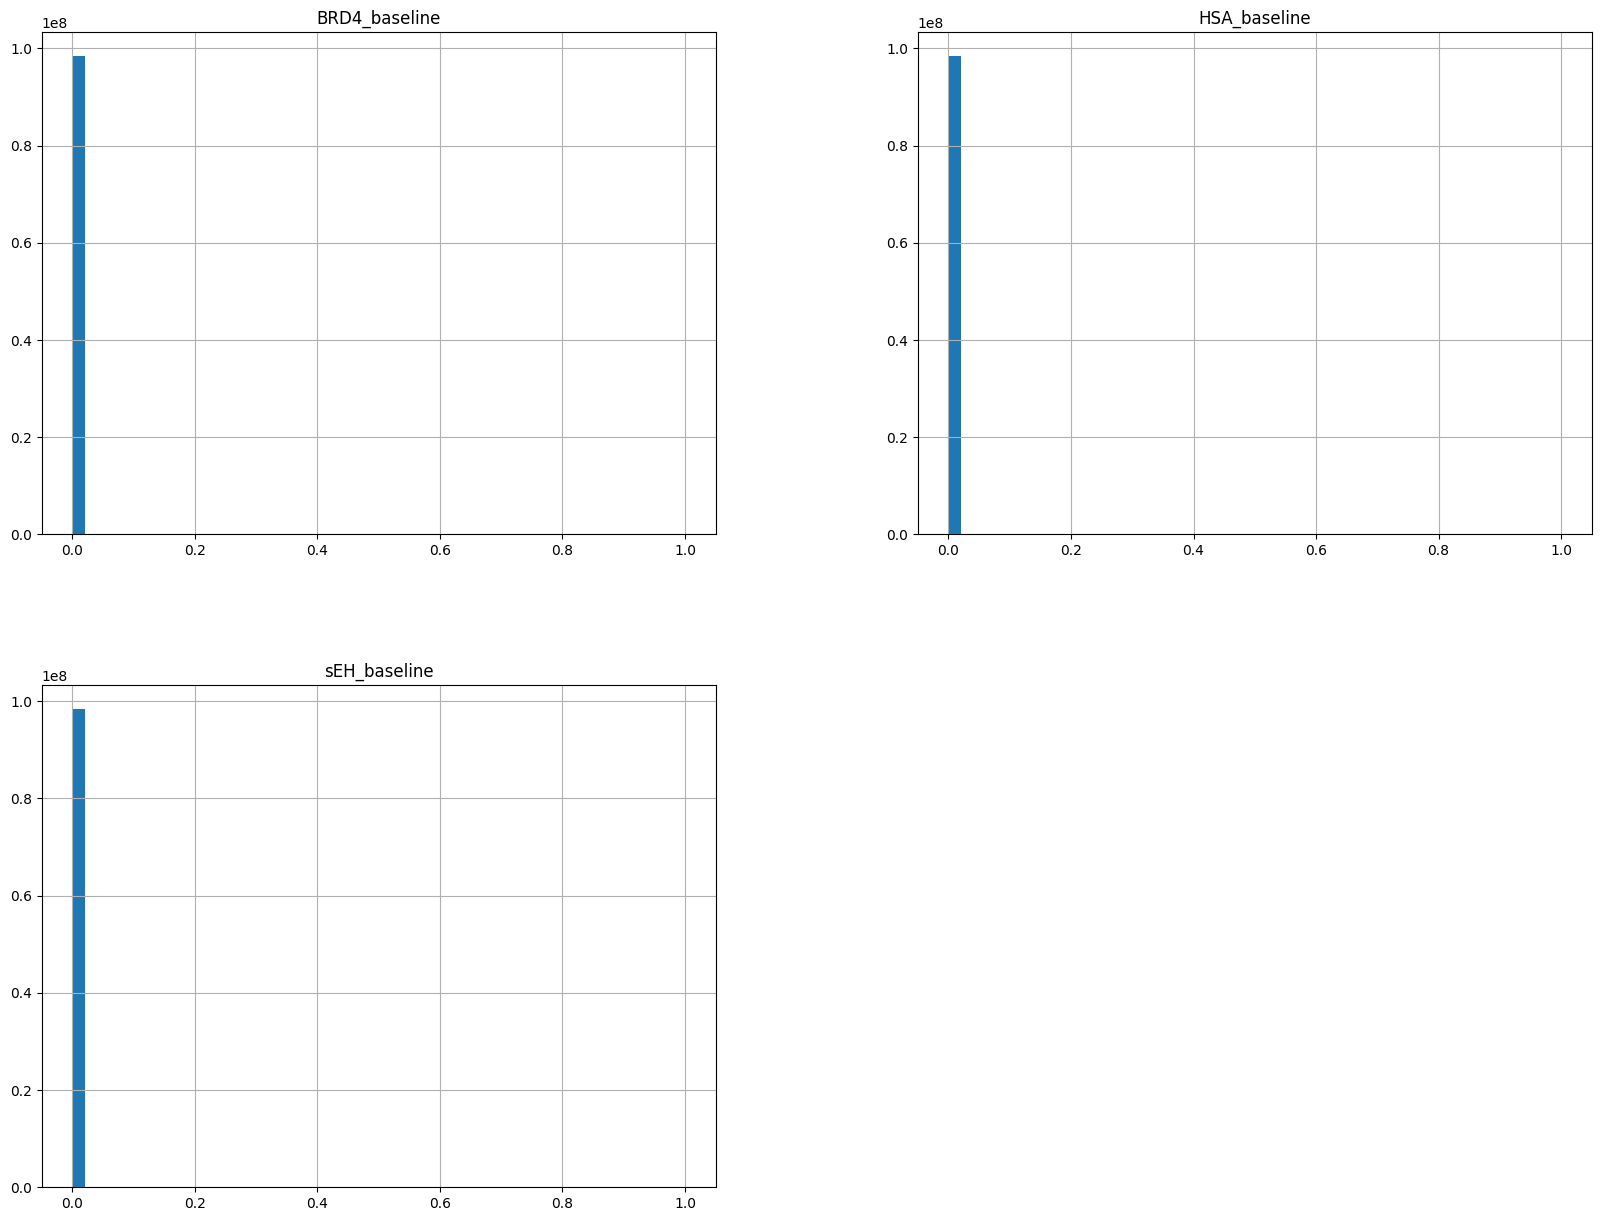

In [53]:
train_df[BASELINE_COLS].to_pandas().hist(bins = 50, log = False, figsize = (20, 15))

array([[<Axes: title={'center': 'BRD4_baseline'}>,
        <Axes: title={'center': 'HSA_baseline'}>],
       [<Axes: title={'center': 'sEH_baseline'}>, <Axes: >]], dtype=object)

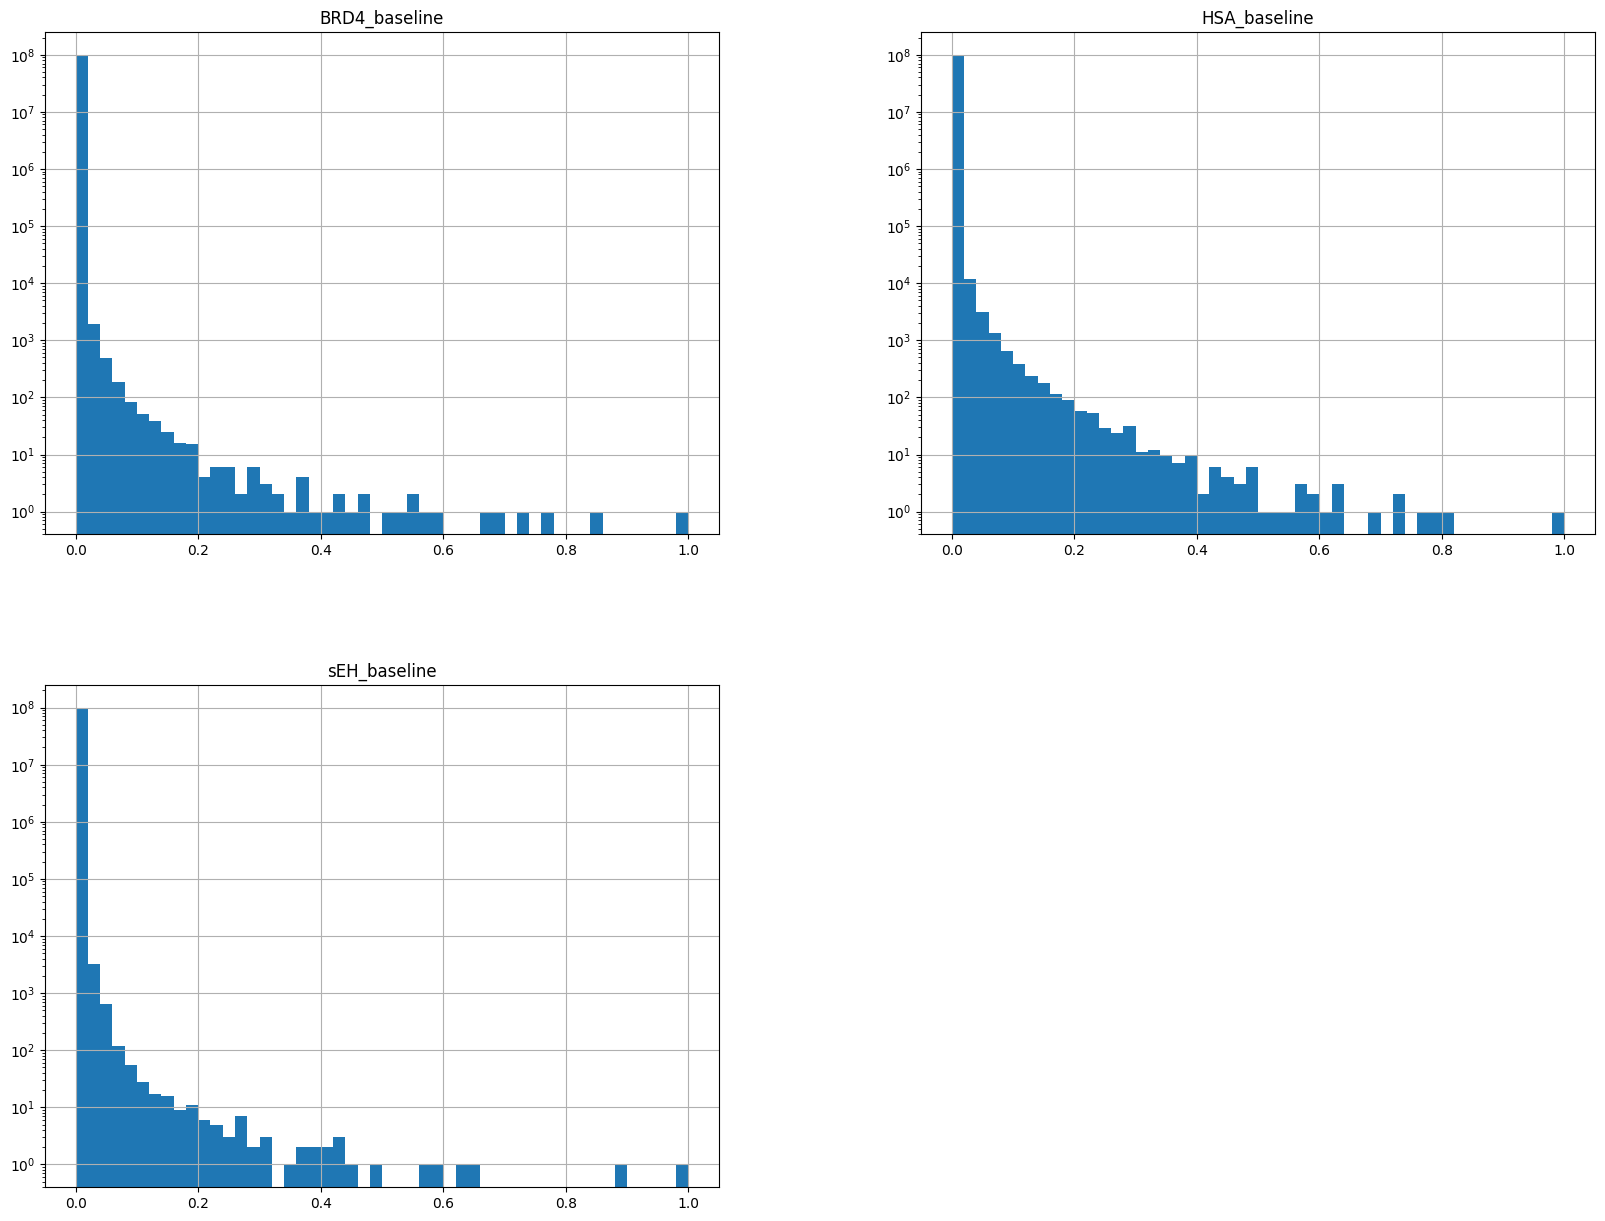

In [54]:
train_df[BASELINE_COLS].to_pandas().hist(bins = 50, log = True, figsize = (20, 15))

BRD4 0
0.0 0.2319383578804058 1.21703145197984e-05


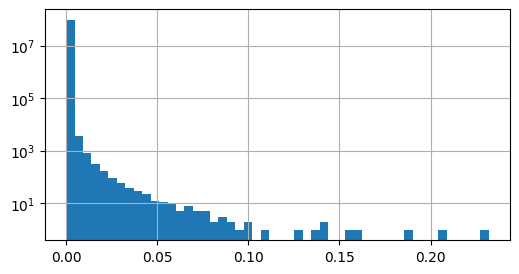

BRD4 1
6.6922285907775166e-09 1.0 0.0011595681654285508


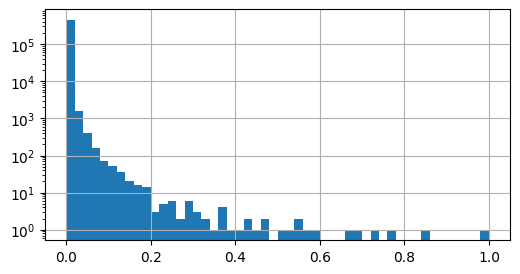

HSA 0
0.0 0.7878213630484644 7.050479991999031e-05


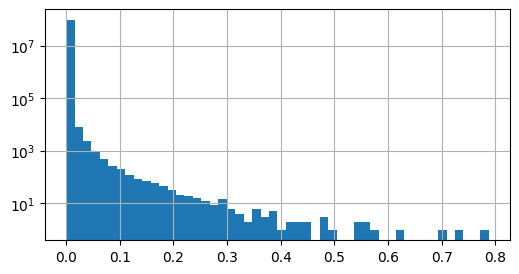

HSA 1
8.164342733692624e-08 1.0 0.0030195041265980286


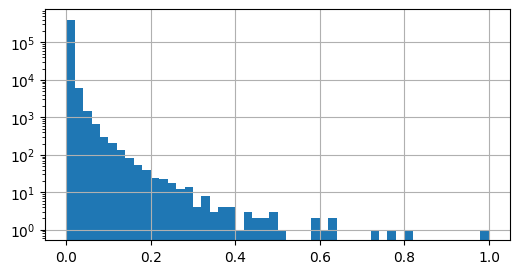

sEH 0
0.0 1.0 1.0208292331307074e-05


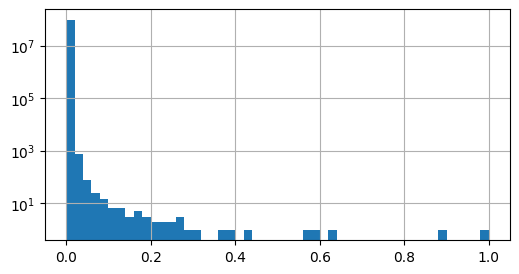

sEH 1
1.0330062682202643e-07 0.6545664804719714 0.001209581275573999


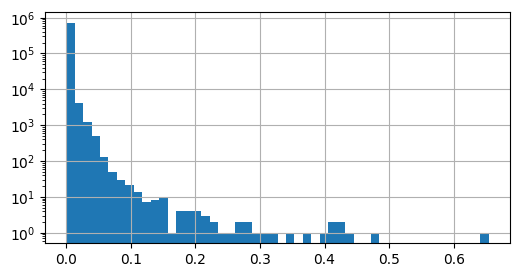

In [55]:
for protein in PROTEINS:
    for label in [0, 1]:
        print(protein, label)
        tmp = train_df.filter(pl.col(protein) == label)[f'{protein}_baseline']
        print(tmp.min(), tmp.max(), tmp.mean())
        tmp.to_pandas().hist(bins = 50, log = True, figsize = (6, 3))
        plt.show()

In [71]:
def label_smooth(x, smooth_base = 0.05, smooth_mul = 0.15, label = 0, cutoff = 1.0):
    # cutoff is selected as 95/99% percentile
    assert smooth_base + smooth_mul < 0.5
    if label == 0:
        return smooth_base +  min(x, cutoff) * (smooth_mul / cutoff)
    else:
        return (1.0 - smooth_base - smooth_mul) + min(x, cutoff) * (smooth_mul / cutoff)
    

def label_smooth_polars(x, smooth_base = 0.05, smooth_mul = 0.15, label = 0, cutoff = 1.0):
    # cutoff is selected as 95/99% percentile
    assert smooth_base + smooth_mul < 0.5
    if label == 0:
        return smooth_base +  pl.min_horizontal(x, cutoff) * (smooth_mul / cutoff)
    else:
        return (1.0 - smooth_base - smooth_mul) + pl.min_horizontal(x, cutoff) * (smooth_mul / cutoff)

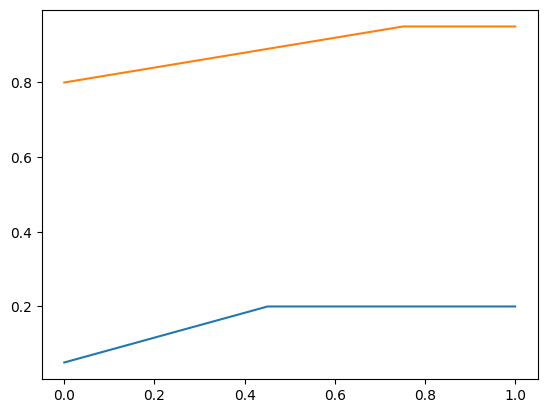

In [72]:
xs = np.arange(0, 1.0, 0.0001)
plt.plot(xs, [label_smooth(x, smooth_base = 0.05, smooth_mul = 0.15, label = 0, cutoff = 0.45) for x in xs])
plt.plot(xs, [label_smooth(x, smooth_base = 0.05, smooth_mul = 0.15, label = 1, cutoff = 0.75) for x in xs])

In [84]:
CUTOFF_DICT = {}
for protein in PROTEINS:
    CUTOFF_DICT[protein] = {}
    for label in [0, 1]:
        tmp = train_df.filter(pl.col(protein) == label)[f'{protein}_baseline']
        CUTOFF_DICT[protein][label] = tmp.quantile(0.99)
CUTOFF_DICT

{'BRD4': {0: 0.00017149973831406243, 1: 0.012792630279480384},
 'HSA': {0: 0.0009380243193755984, 1: 0.033118138349205455},
 'sEH': {0: 8.436829650460108e-05, 1: 0.011706071790051883}}

In [85]:
for protein in PROTEINS:
    train_df = train_df.with_columns(
        pl.when(pl.col(protein) == 0).\
        then(label_smooth_polars(pl.col(f'{protein}_baseline'), smooth_base = 0.05, smooth_mul = 0.15, label = 0, cutoff = CUTOFF_DICT[protein][0])).\
        otherwise(label_smooth_polars(pl.col(f'{protein}_baseline'), smooth_base = 0.05, smooth_mul = 0.15, label = 1, cutoff = CUTOFF_DICT[protein][1])).\
        alias(f'_smooth_label_{protein}')
    )
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,BRD4_bb1_pos_pct,HSA_bb1_pos_pct,sEH_bb1_pos_pct,BRD4_bb2_pos_pct,HSA_bb2_pos_pct,sEH_bb2_pos_pct,BRD4_bb3_pos_pct,HSA_bb3_pos_pct,sEH_bb3_pos_pct,BRD4_baseline,HSA_baseline,sEH_baseline,literal,_smooth_label_BRD4,_smooth_label_HSA,_smooth_label_sEH
str,u16,u16,u16,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.01377,0.008858,0.008847,0.000002,0.000047,0.000008,0.051725,0.051725,0.057547,0.063615
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.016879,0.005454,0.009453,0.000002,0.000029,0.000008,0.052115,0.052115,0.054646,0.064548
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000455,0.00136,0.007313,6.5125e-8,0.000007,0.000006,0.050057,0.050057,0.051158,0.061254
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000989,0.000208,0.001953,1.4169e-7,0.000001,0.000002,0.050124,0.050124,0.050177,0.053005
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.002017,0.001066,0.003328,2.8887e-7,0.000006,0.000003,0.050253,0.050253,0.050908,0.055122
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000285,0.000527,0.00216,9.2532e-8,0.000002,0.000001,0.050081,0.050081,0.0504,0.051997
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.002822,0.004168,0.004325,9.1673e-7,0.00002,0.000002,0.050802,0.050802,0.053161,0.053999
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000526,0.033762,0.021758,1.7096e-7,0.00016,0.000011,0.05015,0.05015,0.075606,0.070119


BRD4 0
0.05 0.2 0.05787081151279252


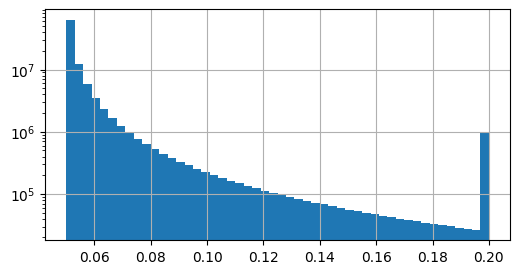

BRD4 1
0.8000000784697334 0.95 0.8111626790274534


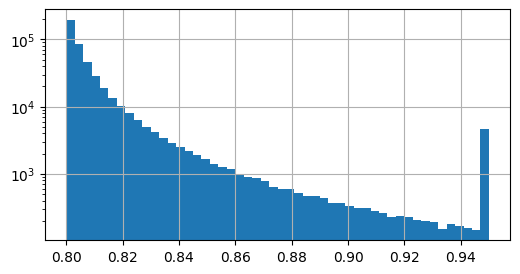

HSA 0
0.05 0.2 0.05835999632557953


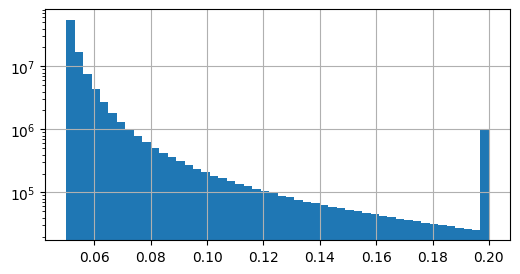

HSA 1
0.8000003697826843 0.95 0.8119678219162215


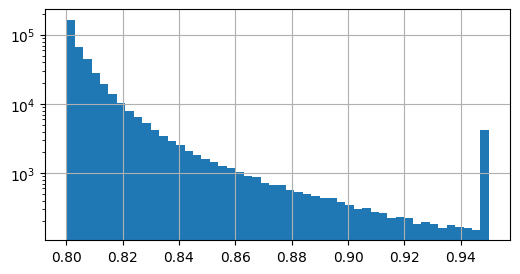

sEH 0
0.05 0.2 0.06249250854151476


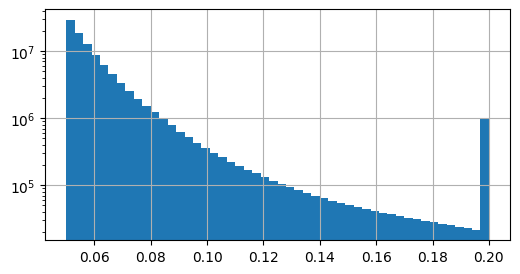

sEH 1
0.8000013236800783 0.95 0.8137988792355566


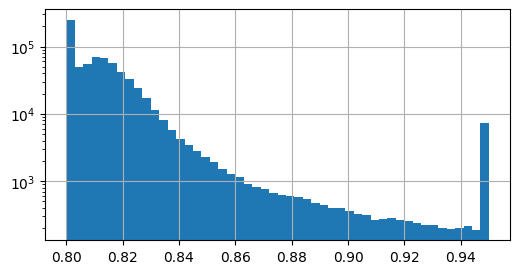

In [86]:
for protein in PROTEINS:
    for label in [0, 1]:
        print(protein, label)
        tmp = train_df.filter(pl.col(protein) == label)[f'_smooth_label_{protein}']
        print(tmp.min(), tmp.max(), tmp.mean())
        tmp.to_pandas().hist(bins = 50, log = True, figsize = (6, 3))
        plt.show()

In [89]:
train_df.columns

['molecule',
 'bb1',
 'bb2',
 'bb3',
 'BRD4',
 'HSA',
 'sEH',
 'BRD4_bb1_pos_pct',
 'HSA_bb1_pos_pct',
 'sEH_bb1_pos_pct',
 'BRD4_bb2_pos_pct',
 'HSA_bb2_pos_pct',
 'sEH_bb2_pos_pct',
 'BRD4_bb3_pos_pct',
 'HSA_bb3_pos_pct',
 'sEH_bb3_pos_pct',
 'BRD4_baseline',
 'HSA_baseline',
 'sEH_baseline',
 '_smooth_label_BRD4',
 '_smooth_label_HSA',
 '_smooth_label_sEH']

In [91]:
tmp_df = train_df.select(pl.col('*').exclude('_smooth_label_BRD4', '_smooth_label_HSA', '_smooth_label_sEH'))
tmp_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,BRD4_bb1_pos_pct,HSA_bb1_pos_pct,sEH_bb1_pos_pct,BRD4_bb2_pos_pct,HSA_bb2_pos_pct,sEH_bb2_pos_pct,BRD4_bb3_pos_pct,HSA_bb3_pos_pct,sEH_bb3_pos_pct,BRD4_baseline,HSA_baseline,sEH_baseline
str,u16,u16,u16,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.01377,0.008858,0.008847,0.000002,0.000047,0.000008
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.016879,0.005454,0.009453,0.000002,0.000029,0.000008
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000455,0.00136,0.007313,6.5125e-8,0.000007,0.000006
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.000989,0.000208,0.001953,1.4169e-7,0.000001,0.000002
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,0.001804,0.003324,0.002487,0.000455,0.00136,0.007313,0.002017,0.001066,0.003328,2.8887e-7,0.000006,0.000003
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000285,0.000527,0.00216,9.2532e-8,0.000002,0.000001
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.002822,0.004168,0.004325,9.1673e-7,0.00002,0.000002
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,0.002978,0.002416,0.001735,0.000625,0.001665,0.006296,0.000526,0.033762,0.021758,1.7096e-7,0.00016,0.000011


In [92]:
tmp_df.write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v3.csv')

## Test 

In [7]:
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v3.csv').select(
                                     pl.col('BRD4', 'HSA',
                                            'sEH').cast(pl.UInt8),
                                     pl.col('BRD4_baseline', 'HSA_baseline',
                                            'sEH_baseline'))


def _label_smooth_polars(x,
                         smooth_base=0.05,
                         smooth_mul=0.15,
                         label=0,
                         cutoff=1.0):
    # cutoff is selected as 95/99% percentile
    assert smooth_base + smooth_mul < 0.5
    if label == 0:
        return smooth_base + pl.min_horizontal(
            x, cutoff) * (smooth_mul / cutoff)
    else:
        return (1.0 -
                smooth_base - smooth_mul) + pl.min_horizontal(
                    x, cutoff) * (smooth_mul / cutoff)

# 99% percentile
# CUTOFF_DICT = {}
# for protein in cls.PROTEINS:
#     CUTOFF_DICT[protein] = {}
#     for label in [0, 1]:
#         tmp = train_df.filter(pl.col(protein) == label)[f'{protein}_baseline']
#         CUTOFF_DICT[protein][label] = tmp.quantile(0.99)
CUTOFF_DICT = {
    'BRD4': {
        0: 0.00017149973831406243,
        1: 0.012792630279480384
    },
    'HSA': {
        0: 0.0009380243193755984,
        1: 0.033118138349205455
    },
    'sEH': {
        0: 8.436829650460108e-05,
        1: 0.011706071790051883
    }
}
train_df = train_df.with_columns(*[
    pl.when(pl.col(protein) == 0).then(
        _label_smooth_polars(pl.col(f'{protein}_baseline'),
                             smooth_base=0.05,
                             smooth_mul=0.15,
                             label=0,
                             cutoff=CUTOFF_DICT[protein][0])).
    otherwise(
        _label_smooth_polars(pl.col(f'{protein}_baseline'),
                             smooth_base=0.05,
                             smooth_mul=0.15,
                             label=1,
                             cutoff=CUTOFF_DICT[protein]
                             [1])).alias(f'_smooth_label_{protein}')
    for protein in PROTEINS
])
train_df = train_df.collect()
train_df

BRD4,HSA,sEH,BRD4_baseline,HSA_baseline,sEH_baseline,_smooth_label_BRD4,_smooth_label_HSA,_smooth_label_sEH
u8,u8,u8,f64,f64,f64,f64,f64,f64
0,0,0,0.000002,0.000047,0.000008,0.051725,0.057547,0.063615
0,0,0,0.000002,0.000029,0.000008,0.052115,0.054646,0.064548
0,0,0,6.5125e-8,0.000007,0.000006,0.050057,0.051158,0.061254
0,0,0,1.4169e-7,0.000001,0.000002,0.050124,0.050177,0.053005
0,0,0,2.8887e-7,0.000006,0.000003,0.050253,0.050908,0.055122
…,…,…,…,…,…,…,…,…
0,0,0,9.2532e-8,0.000002,0.000001,0.050081,0.0504,0.051997
0,0,0,9.1673e-7,0.00002,0.000002,0.050802,0.053161,0.053999
0,0,0,1.7096e-7,0.00016,0.000011,0.05015,0.075606,0.070119


BRD4 0
0.05 0.2 0.05787081151279252


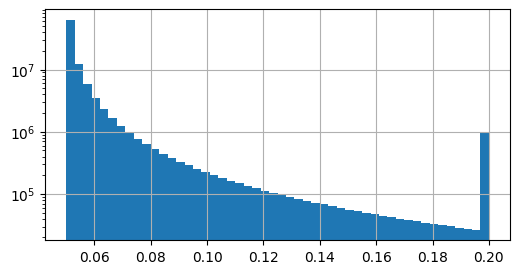

BRD4 1
0.8000000784697334 0.95 0.8111626790274535


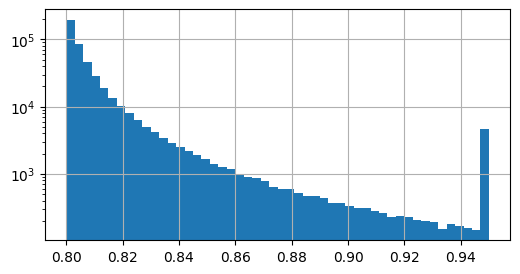

HSA 0
0.05 0.2 0.05835999632557951


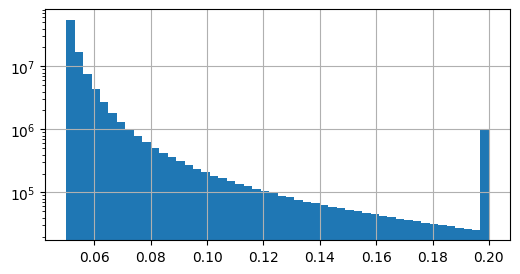

HSA 1
0.8000003697826843 0.95 0.8119678219162212


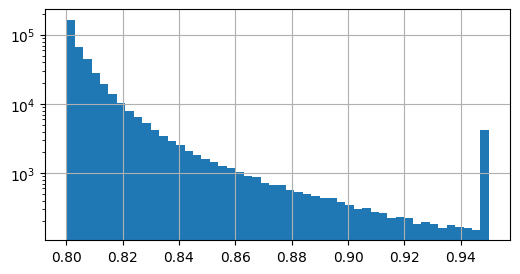

sEH 0
0.05 0.2 0.06249250854151478


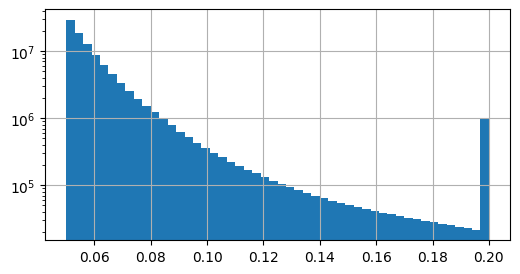

sEH 1
0.8000013236800783 0.95 0.8137988792355566


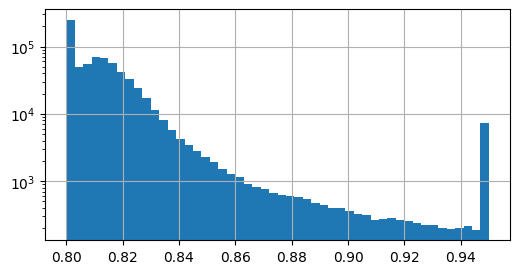

In [8]:
for protein in PROTEINS:
    for label in [0, 1]:
        print(protein, label)
        tmp = train_df.filter(pl.col(protein) == label)[f'_smooth_label_{protein}']
        print(tmp.min(), tmp.max(), tmp.mean())
        tmp.to_pandas().hist(bins = 50, log = True, figsize = (6, 3))
        plt.show()

In [9]:
train_df = train_df.to_pandas()
train_df

,BRD4,HSA,sEH,BRD4_baseline,HSA_baseline,sEH_baseline,_smooth_label_BRD4,_smooth_label_HSA,_smooth_label_sEH
0,0,0,0,1.972445e-06,0.000047,0.000008,0.051725,0.057547,0.063615
1,0,0,0,2.417900e-06,0.000029,0.000008,0.052115,0.054646,0.064548
2,0,0,0,6.512534e-08,0.000007,0.000006,0.050057,0.051158,0.061254
3,0,0,0,1.416888e-07,0.000001,0.000002,0.050124,0.050177,0.053005
4,0,0,0,2.888703e-07,0.000006,0.000003,0.050253,0.050908,0.055122
...,...,...,...,...,...,...,...,...,...
98415605,0,0,0,9.253175e-08,0.000002,0.000001,0.050081,0.050400,0.051997
98415606,0,0,0,9.167298e-07,0.000020,0.000002,0.050802,0.053161,0.053999
98415607,0,0,0,1.709622e-07,0.000160,0.000011,0.050150,0.075606,0.070119
98415608,0,0,0,2.525084e-06,0.000112,0.000007,0.052209,0.067931,0.061864


In [16]:
train_df[[f'{protein}_tmp' for protein in PROTEINS]] = (train_df[[f'_smooth_label_{protein}' for protein in PROTEINS]] > 0.5).astype('uint8')
train_df

,BRD4,HSA,sEH,BRD4_baseline,HSA_baseline,sEH_baseline,_smooth_label_BRD4,_smooth_label_HSA,_smooth_label_sEH,tmp,BRD4_tmp,HSA_tmp,sEH_tmp
0,0,0,0,1.972445e-06,0.000047,0.000008,0.051725,0.057547,0.063615,0,0,0,0
1,0,0,0,2.417900e-06,0.000029,0.000008,0.052115,0.054646,0.064548,0,0,0,0
2,0,0,0,6.512534e-08,0.000007,0.000006,0.050057,0.051158,0.061254,0,0,0,0
3,0,0,0,1.416888e-07,0.000001,0.000002,0.050124,0.050177,0.053005,0,0,0,0
4,0,0,0,2.888703e-07,0.000006,0.000003,0.050253,0.050908,0.055122,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98415605,0,0,0,9.253175e-08,0.000002,0.000001,0.050081,0.050400,0.051997,0,0,0,0
98415606,0,0,0,9.167298e-07,0.000020,0.000002,0.050802,0.053161,0.053999,0,0,0,0
98415607,0,0,0,1.709622e-07,0.000160,0.000011,0.050150,0.075606,0.070119,0,0,0,0
98415608,0,0,0,2.525084e-06,0.000112,0.000007,0.052209,0.067931,0.061864,0,0,0,0


In [17]:
train_df[[f'{protein}_tmp' for protein in PROTEINS]].mean()

BRD4_tmp    0.004643
HSA_tmp     0.004150
sEH_tmp     0.007362
dtype: float64